In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [10]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
#     hh = generate_h(n_beta, t_len, normalize)
#     bb = generate_beta(n_beta, t_len, normalize)
#     total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    x = t
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [11]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 15, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [12]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [13]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>10:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [14]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

    beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [15]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [16]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [17]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [18]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target[1:4], n_beta, t_len, normalize=True)

Dimension - time and Cm:  (15000, 2)
Dimension - x:  (15000, 1)
Dimension - y:  (15000, 1)


In [19]:
x -=10

In [20]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [21]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [22]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=1)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [23]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               512       
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [25]:
model_directory = "D:\\TrainedModels\\20221227_3Flaps_randomState50"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [26]:
ckpt_name = model_directory + "20221227unsteadyPrediction_MLP_3Flaps_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_randomState50_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, min_delta=1e-07,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-8, min_lr=1e-06, verbose=1)

In [27]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [28]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
 1/10 [==>...........................] - ETA: 15s - loss: 0.1865 - rmse: 0.4318
Epoch 1: val_loss improved from inf to 0.09719, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 2s 29ms/step - loss: 0.1292 - rmse: 0.3592 - val_loss: 0.0972 - val_rmse: 0.3116 - lr: 1.0000e-04
Epoch 2/10000
 1/10 [==>...........................] - ETA: 0s - loss: 0.0905 - rmse: 0.3007
Epoch 2: val_loss improved from 0.09719 to 0.09714, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 13ms/step - loss: 0.1001 - rmse: 0.3162 - val_loss: 0.0971 - val_rmse: 0.3115 - lr: 1.0000e-04
Epoch 3/10000
 1/10 [==>...........................] - ETA: 0s - loss: 0.0979 - rmse: 0.3127
Epoch 3: val_loss im

Epoch 20/10000
 1/10 [==>...........................] - ETA: 0s - loss: 0.0649 - rmse: 0.2546
Epoch 20: val_loss did not improve from 0.06677
10/10 [==============================] - 0s 7ms/step - loss: 0.0668 - rmse: 0.2582 - val_loss: 0.0669 - val_rmse: 0.2584 - lr: 1.0000e-04
Epoch 21/10000
 1/10 [==>...........................] - ETA: 0s - loss: 0.0648 - rmse: 0.2544
Epoch 21: val_loss improved from 0.06677 to 0.06626, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 12ms/step - loss: 0.0659 - rmse: 0.2564 - val_loss: 0.0663 - val_rmse: 0.2572 - lr: 1.0000e-04
Epoch 22/10000
 1/10 [==>...........................] - ETA: 0s - loss: 0.0657 - rmse: 0.2561
Epoch 22: val_loss improved from 0.06626 to 0.06606, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_25

 9/10 [==========================>...] - ETA: 0s - loss: 0.0595 - rmse: 0.2437
Epoch 39: val_loss improved from 0.05922 to 0.05879, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 15ms/step - loss: 0.0592 - rmse: 0.2432 - val_loss: 0.0588 - val_rmse: 0.2423 - lr: 1.0000e-04
Epoch 40/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0595 - rmse: 0.2437
Epoch 40: val_loss improved from 0.05879 to 0.05861, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 19ms/step - loss: 0.0591 - rmse: 0.2429 - val_loss: 0.0586 - val_rmse: 0.2419 - lr: 1.0000e-04
Epoch 41/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0567 - rmse: 0.2379
Epoch 41: val_loss improved

Epoch 60/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0547 - rmse: 0.2336
Epoch 60: val_loss improved from 0.05583 to 0.05582, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 0.0546 - rmse: 0.2334 - val_loss: 0.0558 - val_rmse: 0.2361 - lr: 1.0000e-04
Epoch 61/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0558 - rmse: 0.2360
Epoch 61: val_loss did not improve from 0.05582
10/10 [==============================] - 0s 10ms/step - loss: 0.0553 - rmse: 0.2350 - val_loss: 0.0562 - val_rmse: 0.2368 - lr: 1.0000e-04
Epoch 62/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0552 - rmse: 0.2347
Epoch 62: val_loss did not improve from 0.05582
10/10 [==============================] - 0s 10ms/step - loss: 0.0553 - rmse: 0.2349 - val_loss: 0.0559 - val_rmse: 0.2362 - lr: 1.

 9/10 [==========================>...] - ETA: 0s - loss: 0.0538 - rmse: 0.2318
Epoch 83: val_loss improved from 0.05523 to 0.05523, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0540 - rmse: 0.2321 - val_loss: 0.0552 - val_rmse: 0.2348 - lr: 1.0000e-04
Epoch 84/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0551 - rmse: 0.2345
Epoch 84: val_loss improved from 0.05523 to 0.05520, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 0.0546 - rmse: 0.2335 - val_loss: 0.0552 - val_rmse: 0.2347 - lr: 1.0000e-04
Epoch 85/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0534 - rmse: 0.2310
Epoch 85: val_loss did not 

 8/10 [=======================>......] - ETA: 0s - loss: 0.0539 - rmse: 0.2319
Epoch 108: val_loss did not improve from 0.05488
10/10 [==============================] - 0s 10ms/step - loss: 0.0534 - rmse: 0.2309 - val_loss: 0.0552 - val_rmse: 0.2348 - lr: 1.0000e-04
Epoch 109/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0545 - rmse: 0.2333
Epoch 109: val_loss improved from 0.05488 to 0.05483, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 20ms/step - loss: 0.0549 - rmse: 0.2342 - val_loss: 0.0548 - val_rmse: 0.2339 - lr: 1.0000e-04
Epoch 110/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0533 - rmse: 0.2308
Epoch 110: val_loss did not improve from 0.05483
10/10 [==============================] - 0s 10ms/step - loss: 0.0535 - rmse: 0.2311 - val_loss: 0.0549 - val_rmse: 0.2342 - lr: 1.0000e-04
E

 9/10 [==========================>...] - ETA: 0s - loss: 0.0534 - rmse: 0.2310
Epoch 132: val_loss improved from 0.05450 to 0.05447, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 15ms/step - loss: 0.0536 - rmse: 0.2314 - val_loss: 0.0545 - val_rmse: 0.2332 - lr: 1.0000e-04
Epoch 133/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0533 - rmse: 0.2307
Epoch 133: val_loss did not improve from 0.05447
10/10 [==============================] - 0s 10ms/step - loss: 0.0535 - rmse: 0.2311 - val_loss: 0.0545 - val_rmse: 0.2333 - lr: 1.0000e-04
Epoch 134/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0542 - rmse: 0.2325
Epoch 134: val_loss improved from 0.05447 to 0.05444, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_ra

 9/10 [==========================>...] - ETA: 0s - loss: 0.0529 - rmse: 0.2298
Epoch 155: val_loss improved from 0.05407 to 0.05399, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 0.0532 - rmse: 0.2304 - val_loss: 0.0540 - val_rmse: 0.2322 - lr: 1.0000e-04
Epoch 156/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0524 - rmse: 0.2287
Epoch 156: val_loss did not improve from 0.05399
10/10 [==============================] - 0s 10ms/step - loss: 0.0526 - rmse: 0.2290 - val_loss: 0.0543 - val_rmse: 0.2329 - lr: 1.0000e-04
Epoch 157/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0543 - rmse: 0.2328
Epoch 157: val_loss improved from 0.05399 to 0.05398, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_ra

Epoch 179/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0521 - rmse: 0.2281
Epoch 179: val_loss improved from 0.05330 to 0.05328, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0526 - rmse: 0.2291 - val_loss: 0.0533 - val_rmse: 0.2306 - lr: 1.0000e-04
Epoch 180/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0520 - rmse: 0.2278
Epoch 180: val_loss improved from 0.05328 to 0.05315, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 0.0521 - rmse: 0.2281 - val_loss: 0.0532 - val_rmse: 0.2304 - lr: 1.0000e-04
Epoch 181/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0522 - rmse: 0.2282
Epoch 1

10/10 [==============================] - 0s 16ms/step - loss: 0.0521 - rmse: 0.2281 - val_loss: 0.0525 - val_rmse: 0.2289 - lr: 1.0000e-04
Epoch 201/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0516 - rmse: 0.2270
Epoch 201: val_loss did not improve from 0.05248
10/10 [==============================] - 0s 10ms/step - loss: 0.0519 - rmse: 0.2276 - val_loss: 0.0527 - val_rmse: 0.2293 - lr: 1.0000e-04
Epoch 202/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0506 - rmse: 0.2249
Epoch 202: val_loss improved from 0.05248 to 0.05233, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 0.0504 - rmse: 0.2243 - val_loss: 0.0523 - val_rmse: 0.2286 - lr: 1.0000e-04
Epoch 203/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0518 - rmse: 0.2274
Epoch 203: val_loss did not improv

 8/10 [=======================>......] - ETA: 0s - loss: 0.0501 - rmse: 0.2237
Epoch 221: val_loss did not improve from 0.05123
10/10 [==============================] - 0s 11ms/step - loss: 0.0504 - rmse: 0.2243 - val_loss: 0.0512 - val_rmse: 0.2262 - lr: 1.0000e-04
Epoch 222/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0494 - rmse: 0.2221
Epoch 222: val_loss did not improve from 0.05123
10/10 [==============================] - 0s 10ms/step - loss: 0.0500 - rmse: 0.2235 - val_loss: 0.0514 - val_rmse: 0.2265 - lr: 1.0000e-04
Epoch 223/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0511 - rmse: 0.2258
Epoch 223: val_loss did not improve from 0.05123
10/10 [==============================] - 0s 10ms/step - loss: 0.0506 - rmse: 0.2247 - val_loss: 0.0513 - val_rmse: 0.2262 - lr: 1.0000e-04
Epoch 224/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0498 - rmse: 0.2230
Epoch 224: val_loss improved from 0.05123 to 0.05082, saving model to D:

Epoch 245/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0489 - rmse: 0.2209
Epoch 245: val_loss improved from 0.04969 to 0.04958, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0488 - rmse: 0.2207 - val_loss: 0.0496 - val_rmse: 0.2225 - lr: 1.0000e-04
Epoch 246/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0492 - rmse: 0.2217
Epoch 246: val_loss improved from 0.04958 to 0.04947, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0488 - rmse: 0.2208 - val_loss: 0.0495 - val_rmse: 0.2222 - lr: 1.0000e-04
Epoch 247/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0480 - rmse: 0.2189
Epoch 2

Epoch 266/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0470 - rmse: 0.2165
Epoch 266: val_loss did not improve from 0.04684
10/10 [==============================] - 0s 10ms/step - loss: 0.0464 - rmse: 0.2151 - val_loss: 0.0481 - val_rmse: 0.2191 - lr: 1.0000e-04
Epoch 267/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0468 - rmse: 0.2161
Epoch 267: val_loss improved from 0.04684 to 0.04654, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 32ms/step - loss: 0.0474 - rmse: 0.2176 - val_loss: 0.0465 - val_rmse: 0.2155 - lr: 1.0000e-04
Epoch 268/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0463 - rmse: 0.2149
Epoch 268: val_loss did not improve from 0.04654
10/10 [==============================] - 0s 11ms/step - loss: 0.0462 - rmse: 0.2148 - val_loss: 0.0468 - val_rmse: 0.2160 - 

10/10 [==============================] - 0s 16ms/step - loss: 0.0424 - rmse: 0.2057 - val_loss: 0.0433 - val_rmse: 0.2079 - lr: 1.0000e-04
Epoch 287/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0430 - rmse: 0.2071
Epoch 287: val_loss did not improve from 0.04330
10/10 [==============================] - 0s 11ms/step - loss: 0.0428 - rmse: 0.2067 - val_loss: 0.0433 - val_rmse: 0.2080 - lr: 1.0000e-04
Epoch 288/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0420 - rmse: 0.2047
Epoch 288: val_loss improved from 0.04330 to 0.04276, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 0.0423 - rmse: 0.2054 - val_loss: 0.0428 - val_rmse: 0.2066 - lr: 1.0000e-04
Epoch 289/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0412 - rmse: 0.2027
Epoch 289: val_loss did not improv

Epoch 308/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0388 - rmse: 0.1969
Epoch 308: val_loss improved from 0.03981 to 0.03970, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 0.0386 - rmse: 0.1964 - val_loss: 0.0397 - val_rmse: 0.1991 - lr: 1.0000e-04
Epoch 309/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0380 - rmse: 0.1947
Epoch 309: val_loss did not improve from 0.03970
10/10 [==============================] - 0s 10ms/step - loss: 0.0383 - rmse: 0.1955 - val_loss: 0.0397 - val_rmse: 0.1992 - lr: 1.0000e-04
Epoch 310/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0384 - rmse: 0.1957
Epoch 310: val_loss improved from 0.03970 to 0.03955, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5la

 9/10 [==========================>...] - ETA: 0s - loss: 0.0357 - rmse: 0.1887
Epoch 331: val_loss improved from 0.03724 to 0.03711, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0359 - rmse: 0.1892 - val_loss: 0.0371 - val_rmse: 0.1924 - lr: 1.0000e-04
Epoch 332/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0355 - rmse: 0.1882
Epoch 332: val_loss improved from 0.03711 to 0.03687, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 0.0352 - rmse: 0.1875 - val_loss: 0.0369 - val_rmse: 0.1918 - lr: 1.0000e-04
Epoch 333/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0362 - rmse: 0.1902
Epoch 333: val_loss imp

Epoch 353/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0335 - rmse: 0.1828
Epoch 353: val_loss improved from 0.03494 to 0.03466, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0333 - rmse: 0.1824 - val_loss: 0.0347 - val_rmse: 0.1860 - lr: 1.0000e-04
Epoch 354/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0350 - rmse: 0.1868
Epoch 354: val_loss did not improve from 0.03466
10/10 [==============================] - 0s 11ms/step - loss: 0.0346 - rmse: 0.1859 - val_loss: 0.0349 - val_rmse: 0.1867 - lr: 1.0000e-04
Epoch 355/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0331 - rmse: 0.1817
Epoch 355: val_loss improved from 0.03466 to 0.03451, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5la

10/10 [==============================] - 0s 15ms/step - loss: 0.0314 - rmse: 0.1770 - val_loss: 0.0328 - val_rmse: 0.1808 - lr: 1.0000e-04
Epoch 377/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0314 - rmse: 0.1769
Epoch 377: val_loss improved from 0.03276 to 0.03265, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 0.0314 - rmse: 0.1769 - val_loss: 0.0327 - val_rmse: 0.1805 - lr: 1.0000e-04
Epoch 378/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0308 - rmse: 0.1753
Epoch 378: val_loss did not improve from 0.03265
10/10 [==============================] - 0s 11ms/step - loss: 0.0310 - rmse: 0.1759 - val_loss: 0.0330 - val_rmse: 0.1816 - lr: 1.0000e-04
Epoch 379/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0317 - rmse: 0.1780
Epoch 379: val_loss improved from 

10/10 [==============================] - 0s 17ms/step - loss: 0.0295 - rmse: 0.1716 - val_loss: 0.0307 - val_rmse: 0.1750 - lr: 1.0000e-04
Epoch 399/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0307 - rmse: 0.1749
Epoch 399: val_loss did not improve from 0.03068
10/10 [==============================] - 0s 10ms/step - loss: 0.0304 - rmse: 0.1742 - val_loss: 0.0339 - val_rmse: 0.1840 - lr: 1.0000e-04
Epoch 400/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0305 - rmse: 0.1743
Epoch 400: val_loss did not improve from 0.03068
10/10 [==============================] - 0s 10ms/step - loss: 0.0304 - rmse: 0.1741 - val_loss: 0.0313 - val_rmse: 0.1766 - lr: 1.0000e-04
Epoch 401/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0295 - rmse: 0.1715
Epoch 401: val_loss improved from 0.03068 to 0.03050, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50

Epoch 423/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0282 - rmse: 0.1677
Epoch 423: val_loss did not improve from 0.02871
10/10 [==============================] - 0s 11ms/step - loss: 0.0278 - rmse: 0.1664 - val_loss: 0.0291 - val_rmse: 0.1703 - lr: 1.0000e-04
Epoch 424/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0268 - rmse: 0.1636
Epoch 424: val_loss improved from 0.02871 to 0.02865, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 15ms/step - loss: 0.0271 - rmse: 0.1643 - val_loss: 0.0287 - val_rmse: 0.1691 - lr: 1.0000e-04
Epoch 425/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0275 - rmse: 0.1657
Epoch 425: val_loss improved from 0.02865 to 0.02814, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5la

 9/10 [==========================>...] - ETA: 0s - loss: 0.0261 - rmse: 0.1614
Epoch 447: val_loss did not improve from 0.02626
10/10 [==============================] - 0s 10ms/step - loss: 0.0258 - rmse: 0.1604 - val_loss: 0.0275 - val_rmse: 0.1655 - lr: 1.0000e-04
Epoch 448/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0259 - rmse: 0.1608
Epoch 448: val_loss did not improve from 0.02626
10/10 [==============================] - 0s 10ms/step - loss: 0.0259 - rmse: 0.1608 - val_loss: 0.0264 - val_rmse: 0.1623 - lr: 1.0000e-04
Epoch 449/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0251 - rmse: 0.1583
Epoch 449: val_loss improved from 0.02626 to 0.02601, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0250 - rmse: 0.1577 - val_loss: 0.0260 - val_rmse: 0.1611 - lr: 1.0000e-04
E

 8/10 [=======================>......] - ETA: 0s - loss: 0.0245 - rmse: 0.1563
Epoch 471: val_loss did not improve from 0.02452
10/10 [==============================] - 0s 11ms/step - loss: 0.0242 - rmse: 0.1552 - val_loss: 0.0257 - val_rmse: 0.1602 - lr: 1.0000e-04
Epoch 472/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0243 - rmse: 0.1557
Epoch 472: val_loss did not improve from 0.02452
10/10 [==============================] - 0s 11ms/step - loss: 0.0244 - rmse: 0.1560 - val_loss: 0.0249 - val_rmse: 0.1577 - lr: 1.0000e-04
Epoch 473/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0232 - rmse: 0.1522
Epoch 473: val_loss did not improve from 0.02452
10/10 [==============================] - 0s 11ms/step - loss: 0.0235 - rmse: 0.1530 - val_loss: 0.0267 - val_rmse: 0.1632 - lr: 1.0000e-04
Epoch 474/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0236 - rmse: 0.1534
Epoch 474: val_loss improved from 0.02452 to 0.02412, saving model to D:

 9/10 [==========================>...] - ETA: 0s - loss: 0.0215 - rmse: 0.1465
Epoch 495: val_loss did not improve from 0.02261
10/10 [==============================] - 0s 10ms/step - loss: 0.0215 - rmse: 0.1465 - val_loss: 0.0227 - val_rmse: 0.1505 - lr: 1.0000e-04
Epoch 496/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0216 - rmse: 0.1467
Epoch 496: val_loss did not improve from 0.02261
10/10 [==============================] - 0s 10ms/step - loss: 0.0216 - rmse: 0.1467 - val_loss: 0.0231 - val_rmse: 0.1517 - lr: 1.0000e-04
Epoch 497/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0207 - rmse: 0.1435
Epoch 497: val_loss improved from 0.02261 to 0.02212, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 0.0207 - rmse: 0.1437 - val_loss: 0.0221 - val_rmse: 0.1485 - lr: 1.0000e-04
E

Epoch 519/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0202 - rmse: 0.1417
Epoch 519: val_loss improved from 0.02079 to 0.02074, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0199 - rmse: 0.1408 - val_loss: 0.0207 - val_rmse: 0.1438 - lr: 1.0000e-04
Epoch 520/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0202 - rmse: 0.1419
Epoch 520: val_loss did not improve from 0.02074
10/10 [==============================] - 0s 10ms/step - loss: 0.0199 - rmse: 0.1408 - val_loss: 0.0209 - val_rmse: 0.1444 - lr: 1.0000e-04
Epoch 521/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0194 - rmse: 0.1392
Epoch 521: val_loss improved from 0.02074 to 0.02060, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5la

Epoch 544/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0196 - rmse: 0.1396
Epoch 544: val_loss did not improve from 0.01960
10/10 [==============================] - 0s 10ms/step - loss: 0.0194 - rmse: 0.1390 - val_loss: 0.0198 - val_rmse: 0.1406 - lr: 1.0000e-04
Epoch 545/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0187 - rmse: 0.1364
Epoch 545: val_loss did not improve from 0.01960
10/10 [==============================] - 0s 11ms/step - loss: 0.0187 - rmse: 0.1365 - val_loss: 0.0204 - val_rmse: 0.1428 - lr: 1.0000e-04
Epoch 546/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0182 - rmse: 0.1347
Epoch 546: val_loss did not improve from 0.01960
10/10 [==============================] - 0s 10ms/step - loss: 0.0183 - rmse: 0.1351 - val_loss: 0.0198 - val_rmse: 0.1405 - lr: 1.0000e-04
Epoch 547/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0186 - rmse: 0.1361
Epoch 547: val_loss improved from 0.01960 to 0.01924, sa

10/10 [==============================] - 0s 17ms/step - loss: 0.0172 - rmse: 0.1311 - val_loss: 0.0181 - val_rmse: 0.1342 - lr: 1.0000e-04
Epoch 569/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0174 - rmse: 0.1316
Epoch 569: val_loss did not improve from 0.01807
10/10 [==============================] - 0s 10ms/step - loss: 0.0173 - rmse: 0.1312 - val_loss: 0.0182 - val_rmse: 0.1348 - lr: 1.0000e-04
Epoch 570/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0171 - rmse: 0.1303
Epoch 570: val_loss did not improve from 0.01807
10/10 [==============================] - 0s 10ms/step - loss: 0.0169 - rmse: 0.1297 - val_loss: 0.0189 - val_rmse: 0.1372 - lr: 1.0000e-04
Epoch 571/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0177 - rmse: 0.1328
Epoch 571: val_loss did not improve from 0.01807
10/10 [==============================] - 0s 10ms/step - loss: 0.0177 - rmse: 0.1326 - val_loss: 0.0184 - val_rmse: 0.1355 - lr: 1.0000e-04
Epoch 572/10

10/10 [==============================] - 0s 16ms/step - loss: 0.0158 - rmse: 0.1253 - val_loss: 0.0163 - val_rmse: 0.1274 - lr: 1.0000e-04
Epoch 594/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0154 - rmse: 0.1239
Epoch 594: val_loss did not improve from 0.01630
10/10 [==============================] - 0s 10ms/step - loss: 0.0153 - rmse: 0.1236 - val_loss: 0.0172 - val_rmse: 0.1308 - lr: 1.0000e-04
Epoch 595/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0158 - rmse: 0.1255
Epoch 595: val_loss improved from 0.01630 to 0.01619, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 0.0157 - rmse: 0.1251 - val_loss: 0.0162 - val_rmse: 0.1270 - lr: 1.0000e-04
Epoch 596/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0159 - rmse: 0.1258
Epoch 596: val_loss did not improv

10/10 [==============================] - 0s 16ms/step - loss: 0.0143 - rmse: 0.1193 - val_loss: 0.0146 - val_rmse: 0.1205 - lr: 1.0000e-04
Epoch 618/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0135 - rmse: 0.1160
Epoch 618: val_loss improved from 0.01459 to 0.01452, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 0.0138 - rmse: 0.1171 - val_loss: 0.0145 - val_rmse: 0.1202 - lr: 1.0000e-04
Epoch 619/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0132 - rmse: 0.1147
Epoch 619: val_loss did not improve from 0.01452
10/10 [==============================] - 0s 11ms/step - loss: 0.0137 - rmse: 0.1167 - val_loss: 0.0146 - val_rmse: 0.1207 - lr: 1.0000e-04
Epoch 620/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0137 - rmse: 0.1169
Epoch 620: val_loss improved from 

10/10 [==============================] - 0s 10ms/step - loss: 0.0134 - rmse: 0.1153 - val_loss: 0.0149 - val_rmse: 0.1216 - lr: 1.0000e-04
Epoch 643/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0140 - rmse: 0.1179
Epoch 643: val_loss did not improve from 0.01343
10/10 [==============================] - 0s 10ms/step - loss: 0.0140 - rmse: 0.1179 - val_loss: 0.0138 - val_rmse: 0.1172 - lr: 1.0000e-04
Epoch 644/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0131 - rmse: 0.1141
Epoch 644: val_loss did not improve from 0.01343
10/10 [==============================] - 0s 10ms/step - loss: 0.0132 - rmse: 0.1146 - val_loss: 0.0138 - val_rmse: 0.1173 - lr: 1.0000e-04
Epoch 645/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0128 - rmse: 0.1130
Epoch 645: val_loss improved from 0.01343 to 0.01334, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50

10/10 [==============================] - 0s 15ms/step - loss: 0.0123 - rmse: 0.1108 - val_loss: 0.0125 - val_rmse: 0.1115 - lr: 1.0000e-04
Epoch 668/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0125 - rmse: 0.1114
Epoch 668: val_loss did not improve from 0.01249
10/10 [==============================] - 0s 10ms/step - loss: 0.0125 - rmse: 0.1117 - val_loss: 0.0130 - val_rmse: 0.1136 - lr: 1.0000e-04
Epoch 669/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0120 - rmse: 0.1092
Epoch 669: val_loss did not improve from 0.01249
10/10 [==============================] - 0s 10ms/step - loss: 0.0120 - rmse: 0.1094 - val_loss: 0.0131 - val_rmse: 0.1141 - lr: 1.0000e-04
Epoch 670/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0124 - rmse: 0.1110
Epoch 670: val_loss did not improve from 0.01249
10/10 [==============================] - 0s 11ms/step - loss: 0.0123 - rmse: 0.1105 - val_loss: 0.0136 - val_rmse: 0.1164 - lr: 1.0000e-04
Epoch 671/10

Epoch 694/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0111 - rmse: 0.1050
Epoch 694: val_loss did not improve from 0.01174
10/10 [==============================] - 0s 11ms/step - loss: 0.0112 - rmse: 0.1057 - val_loss: 0.0119 - val_rmse: 0.1087 - lr: 1.0000e-04
Epoch 695/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0116 - rmse: 0.1076
Epoch 695: val_loss did not improve from 0.01174
10/10 [==============================] - 0s 10ms/step - loss: 0.0117 - rmse: 0.1077 - val_loss: 0.0122 - val_rmse: 0.1102 - lr: 1.0000e-04
Epoch 696/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0117 - rmse: 0.1078
Epoch 696: val_loss improved from 0.01174 to 0.01161, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0116 - rmse: 0.1073 - val_loss: 0.0116 - val_rmse: 0.1075 - 

Epoch 721/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0107 - rmse: 0.1030
Epoch 721: val_loss improved from 0.01129 to 0.01107, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 18ms/step - loss: 0.0107 - rmse: 0.1034 - val_loss: 0.0111 - val_rmse: 0.1049 - lr: 1.0000e-04
Epoch 722/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0105 - rmse: 0.1022
Epoch 722: val_loss did not improve from 0.01107
10/10 [==============================] - 0s 11ms/step - loss: 0.0109 - rmse: 0.1039 - val_loss: 0.0113 - val_rmse: 0.1060 - lr: 1.0000e-04
Epoch 723/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0106 - rmse: 0.1028
Epoch 723: val_loss did not improve from 0.01107
10/10 [==============================] - 0s 11ms/step - loss: 0.0106 - rmse: 0.1027 - val_loss: 0.0117 - val_rmse: 0.1081 - 

 9/10 [==========================>...] - ETA: 0s - loss: 0.0107 - rmse: 0.1033
Epoch 748: val_loss improved from 0.01076 to 0.01069, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 15ms/step - loss: 0.0108 - rmse: 0.1035 - val_loss: 0.0107 - val_rmse: 0.1031 - lr: 1.0000e-04
Epoch 749/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0103 - rmse: 0.1011
Epoch 749: val_loss did not improve from 0.01069
10/10 [==============================] - 0s 11ms/step - loss: 0.0103 - rmse: 0.1009 - val_loss: 0.0107 - val_rmse: 0.1034 - lr: 1.0000e-04
Epoch 750/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0104 - rmse: 0.1018
Epoch 750: val_loss did not improve from 0.01069
10/10 [==============================] - 0s 10ms/step - loss: 0.0104 - rmse: 0.1019 - val_loss: 0.0108 - val_rmse: 0.1036 - lr: 1.0000e-04
E

10/10 [==============================] - 0s 10ms/step - loss: 0.0102 - rmse: 0.1006 - val_loss: 0.0104 - val_rmse: 0.1017 - lr: 1.0000e-04
Epoch 774/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0101 - rmse: 0.1002
Epoch 774: val_loss did not improve from 0.01032
10/10 [==============================] - 0s 10ms/step - loss: 0.0101 - rmse: 0.1002 - val_loss: 0.0110 - val_rmse: 0.1046 - lr: 1.0000e-04
Epoch 775/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0107 - rmse: 0.1029
Epoch 775: val_loss did not improve from 0.01032
10/10 [==============================] - 0s 11ms/step - loss: 0.0103 - rmse: 0.1012 - val_loss: 0.0106 - val_rmse: 0.1026 - lr: 1.0000e-04
Epoch 776/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0097 - rmse: 0.0981
Epoch 776: val_loss did not improve from 0.01032
10/10 [==============================] - 0s 10ms/step - loss: 0.0097 - rmse: 0.0979 - val_loss: 0.0104 - val_rmse: 0.1016 - lr: 1.0000e-04
Epoch 777/10

Epoch 800/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0103 - rmse: 0.1012
Epoch 800: val_loss did not improve from 0.00986
10/10 [==============================] - 0s 10ms/step - loss: 0.0102 - rmse: 0.1008 - val_loss: 0.0101 - val_rmse: 0.1000 - lr: 1.0000e-04
Epoch 801/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0098 - rmse: 0.0986
Epoch 801: val_loss did not improve from 0.00986
10/10 [==============================] - 0s 10ms/step - loss: 0.0097 - rmse: 0.0984 - val_loss: 0.0102 - val_rmse: 0.1007 - lr: 1.0000e-04
Epoch 802/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0097 - rmse: 0.0982
Epoch 802: val_loss did not improve from 0.00986
10/10 [==============================] - 0s 10ms/step - loss: 0.0096 - rmse: 0.0979 - val_loss: 0.0102 - val_rmse: 0.1005 - lr: 1.0000e-04
Epoch 803/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0099 - rmse: 0.0989
Epoch 803: val_loss did not improve from 0.00986
10/10 [

 8/10 [=======================>......] - ETA: 0s - loss: 0.0101 - rmse: 0.1004
Epoch 826: val_loss did not improve from 0.00963
10/10 [==============================] - 0s 10ms/step - loss: 0.0102 - rmse: 0.1008 - val_loss: 0.0098 - val_rmse: 0.0989 - lr: 1.0000e-04
Epoch 827/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0102 - rmse: 0.1006
Epoch 827: val_loss did not improve from 0.00963
10/10 [==============================] - 0s 10ms/step - loss: 0.0101 - rmse: 0.1001 - val_loss: 0.0100 - val_rmse: 0.0995 - lr: 1.0000e-04
Epoch 828/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0106 - rmse: 0.1027
Epoch 828: val_loss did not improve from 0.00963
10/10 [==============================] - 0s 10ms/step - loss: 0.0105 - rmse: 0.1024 - val_loss: 0.0102 - val_rmse: 0.1008 - lr: 1.0000e-04
Epoch 829/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0106 - rmse: 0.1027
Epoch 829: val_loss did not improve from 0.00963
10/10 [================

10/10 [==============================] - 0s 11ms/step - loss: 0.0099 - rmse: 0.0990 - val_loss: 0.0098 - val_rmse: 0.0987 - lr: 1.0000e-04
Epoch 855/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0094 - rmse: 0.0968
Epoch 855: val_loss improved from 0.00962 to 0.00957, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0090 - rmse: 0.0948 - val_loss: 0.0096 - val_rmse: 0.0975 - lr: 1.0000e-04
Epoch 856/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0094 - rmse: 0.0969
Epoch 856: val_loss did not improve from 0.00957
10/10 [==============================] - 0s 10ms/step - loss: 0.0095 - rmse: 0.0972 - val_loss: 0.0102 - val_rmse: 0.1009 - lr: 1.0000e-04
Epoch 857/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0095 - rmse: 0.0970
Epoch 857: val_loss did not improv

Epoch 881/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0090 - rmse: 0.0948
Epoch 881: val_loss did not improve from 0.00924
10/10 [==============================] - 0s 11ms/step - loss: 0.0090 - rmse: 0.0946 - val_loss: 0.0094 - val_rmse: 0.0965 - lr: 1.0000e-04
Epoch 882/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0092 - rmse: 0.0955
Epoch 882: val_loss did not improve from 0.00924
10/10 [==============================] - 0s 10ms/step - loss: 0.0091 - rmse: 0.0950 - val_loss: 0.0096 - val_rmse: 0.0978 - lr: 1.0000e-04
Epoch 883/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0093 - rmse: 0.0961
Epoch 883: val_loss improved from 0.00924 to 0.00913, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 0.0092 - rmse: 0.0955 - val_loss: 0.0091 - val_rmse: 0.0952 - 

Epoch 908/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0089 - rmse: 0.0939
Epoch 908: val_loss did not improve from 0.00900
10/10 [==============================] - 0s 11ms/step - loss: 0.0088 - rmse: 0.0936 - val_loss: 0.0092 - val_rmse: 0.0957 - lr: 1.0000e-04
Epoch 909/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0094 - rmse: 0.0969
Epoch 909: val_loss improved from 0.00900 to 0.00899, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 15ms/step - loss: 0.0093 - rmse: 0.0963 - val_loss: 0.0090 - val_rmse: 0.0945 - lr: 1.0000e-04
Epoch 910/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0088 - rmse: 0.0936
Epoch 910: val_loss did not improve from 0.00899
10/10 [==============================] - 0s 10ms/step - loss: 0.0090 - rmse: 0.0945 - val_loss: 0.0092 - val_rmse: 0.0957 - 

 8/10 [=======================>......] - ETA: 0s - loss: 0.0088 - rmse: 0.0935
Epoch 935: val_loss did not improve from 0.00877
10/10 [==============================] - 0s 11ms/step - loss: 0.0090 - rmse: 0.0948 - val_loss: 0.0094 - val_rmse: 0.0967 - lr: 1.0000e-04
Epoch 936/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0091 - rmse: 0.0951
Epoch 936: val_loss did not improve from 0.00877
10/10 [==============================] - 0s 11ms/step - loss: 0.0091 - rmse: 0.0953 - val_loss: 0.0097 - val_rmse: 0.0980 - lr: 1.0000e-04
Epoch 937/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0092 - rmse: 0.0956
Epoch 937: val_loss did not improve from 0.00877
10/10 [==============================] - 0s 11ms/step - loss: 0.0092 - rmse: 0.0957 - val_loss: 0.0090 - val_rmse: 0.0946 - lr: 1.0000e-04
Epoch 938/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0086 - rmse: 0.0926
Epoch 938: val_loss did not improve from 0.00877
10/10 [================

Epoch 963/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0085 - rmse: 0.0921
Epoch 963: val_loss did not improve from 0.00871
10/10 [==============================] - 0s 11ms/step - loss: 0.0084 - rmse: 0.0915 - val_loss: 0.0087 - val_rmse: 0.0931 - lr: 1.0000e-04
Epoch 964/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0083 - rmse: 0.0909
Epoch 964: val_loss did not improve from 0.00871
10/10 [==============================] - 0s 11ms/step - loss: 0.0085 - rmse: 0.0917 - val_loss: 0.0091 - val_rmse: 0.0953 - lr: 1.0000e-04
Epoch 965/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0096 - rmse: 0.0975
Epoch 965: val_loss did not improve from 0.00871
10/10 [==============================] - 0s 11ms/step - loss: 0.0092 - rmse: 0.0958 - val_loss: 0.0092 - val_rmse: 0.0958 - lr: 1.0000e-04
Epoch 966/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0088 - rmse: 0.0936
Epoch 966: val_loss did not improve from 0.00871
10/10 [

Epoch 990/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0089 - rmse: 0.0939
Epoch 990: val_loss did not improve from 0.00854
10/10 [==============================] - 0s 11ms/step - loss: 0.0087 - rmse: 0.0928 - val_loss: 0.0088 - val_rmse: 0.0934 - lr: 1.0000e-04
Epoch 991/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0083 - rmse: 0.0909
Epoch 991: val_loss did not improve from 0.00854
10/10 [==============================] - 0s 11ms/step - loss: 0.0084 - rmse: 0.0913 - val_loss: 0.0086 - val_rmse: 0.0923 - lr: 1.0000e-04
Epoch 992/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0083 - rmse: 0.0907
Epoch 992: val_loss did not improve from 0.00854
10/10 [==============================] - 0s 11ms/step - loss: 0.0083 - rmse: 0.0909 - val_loss: 0.0087 - val_rmse: 0.0930 - lr: 1.0000e-04
Epoch 993/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0085 - rmse: 0.0920
Epoch 993: val_loss did not improve from 0.00854
10/10 [

10/10 [==============================] - 0s 17ms/step - loss: 0.0089 - rmse: 0.0943 - val_loss: 0.0084 - val_rmse: 0.0913 - lr: 1.0000e-04
Epoch 1018/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0087 - rmse: 0.0931
Epoch 1018: val_loss improved from 0.00840 to 0.00835, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 0.0088 - rmse: 0.0934 - val_loss: 0.0083 - val_rmse: 0.0911 - lr: 1.0000e-04
Epoch 1019/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0091 - rmse: 0.0948
Epoch 1019: val_loss did not improve from 0.00835
10/10 [==============================] - 0s 11ms/step - loss: 0.0091 - rmse: 0.0952 - val_loss: 0.0087 - val_rmse: 0.0932 - lr: 1.0000e-04
Epoch 1020/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0086 - rmse: 0.0927
Epoch 1020: val_loss did not 

 8/10 [=======================>......] - ETA: 0s - loss: 0.0080 - rmse: 0.0893
Epoch 1045: val_loss did not improve from 0.00828
10/10 [==============================] - 0s 10ms/step - loss: 0.0082 - rmse: 0.0901 - val_loss: 0.0086 - val_rmse: 0.0923 - lr: 1.0000e-04
Epoch 1046/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0080 - rmse: 0.0892
Epoch 1046: val_loss did not improve from 0.00828
10/10 [==============================] - 0s 10ms/step - loss: 0.0081 - rmse: 0.0896 - val_loss: 0.0086 - val_rmse: 0.0924 - lr: 1.0000e-04
Epoch 1047/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0079 - rmse: 0.0884
Epoch 1047: val_loss did not improve from 0.00828
10/10 [==============================] - 0s 10ms/step - loss: 0.0081 - rmse: 0.0896 - val_loss: 0.0083 - val_rmse: 0.0910 - lr: 1.0000e-04
Epoch 1048/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0082 - rmse: 0.0904
Epoch 1048: val_loss did not improve from 0.00828
10/10 [=========

 9/10 [==========================>...] - ETA: 0s - loss: 0.0081 - rmse: 0.0899
Epoch 1072: val_loss improved from 0.00809 to 0.00808, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 18ms/step - loss: 0.0081 - rmse: 0.0897 - val_loss: 0.0081 - val_rmse: 0.0896 - lr: 1.0000e-04
Epoch 1073/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0083 - rmse: 0.0909
Epoch 1073: val_loss did not improve from 0.00808
10/10 [==============================] - 0s 11ms/step - loss: 0.0083 - rmse: 0.0908 - val_loss: 0.0084 - val_rmse: 0.0913 - lr: 1.0000e-04
Epoch 1074/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0079 - rmse: 0.0885
Epoch 1074: val_loss did not improve from 0.00808
10/10 [==============================] - 0s 11ms/step - loss: 0.0080 - rmse: 0.0891 - val_loss: 0.0087 - val_rmse: 0.0927 - lr: 1.0000e

Epoch 1100/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0097 - rmse: 0.0982
Epoch 1100: val_loss did not improve from 0.00801
10/10 [==============================] - 0s 10ms/step - loss: 0.0095 - rmse: 0.0972 - val_loss: 0.0097 - val_rmse: 0.0982 - lr: 1.0000e-04
Epoch 1101/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0087 - rmse: 0.0928
Epoch 1101: val_loss did not improve from 0.00801
10/10 [==============================] - 0s 10ms/step - loss: 0.0086 - rmse: 0.0923 - val_loss: 0.0085 - val_rmse: 0.0916 - lr: 1.0000e-04
Epoch 1102/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0085 - rmse: 0.0916
Epoch 1102: val_loss did not improve from 0.00801
10/10 [==============================] - 0s 10ms/step - loss: 0.0084 - rmse: 0.0913 - val_loss: 0.0081 - val_rmse: 0.0895 - lr: 1.0000e-04
Epoch 1103/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0079 - rmse: 0.0885
Epoch 1103: val_loss improved from 0.00801 to 0.0

Epoch 1127/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0084 - rmse: 0.0911
Epoch 1127: val_loss did not improve from 0.00785
10/10 [==============================] - 0s 10ms/step - loss: 0.0085 - rmse: 0.0917 - val_loss: 0.0097 - val_rmse: 0.0982 - lr: 1.0000e-04
Epoch 1128/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0079 - rmse: 0.0888
Epoch 1128: val_loss did not improve from 0.00785
10/10 [==============================] - 0s 10ms/step - loss: 0.0079 - rmse: 0.0884 - val_loss: 0.0079 - val_rmse: 0.0884 - lr: 1.0000e-04
Epoch 1129/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0082 - rmse: 0.0900
Epoch 1129: val_loss did not improve from 0.00785
10/10 [==============================] - 0s 10ms/step - loss: 0.0083 - rmse: 0.0908 - val_loss: 0.0101 - val_rmse: 0.1001 - lr: 1.0000e-04
Epoch 1130/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0088 - rmse: 0.0936
Epoch 1130: val_loss did not improve from 0.00785

Epoch 1154/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0076 - rmse: 0.0871
Epoch 1154: val_loss did not improve from 0.00769
10/10 [==============================] - 0s 10ms/step - loss: 0.0077 - rmse: 0.0871 - val_loss: 0.0078 - val_rmse: 0.0877 - lr: 1.0000e-04
Epoch 1155/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0077 - rmse: 0.0875
Epoch 1155: val_loss did not improve from 0.00769
10/10 [==============================] - 0s 10ms/step - loss: 0.0076 - rmse: 0.0870 - val_loss: 0.0078 - val_rmse: 0.0883 - lr: 1.0000e-04
Epoch 1156/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0075 - rmse: 0.0861
Epoch 1156: val_loss improved from 0.00769 to 0.00767, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 22ms/step - loss: 0.0076 - rmse: 0.0866 - val_loss: 0.0077 - val_rmse: 0.0

Epoch 1181/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0079 - rmse: 0.0885
Epoch 1181: val_loss did not improve from 0.00749
10/10 [==============================] - 0s 10ms/step - loss: 0.0078 - rmse: 0.0882 - val_loss: 0.0075 - val_rmse: 0.0865 - lr: 1.0000e-04
Epoch 1182/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0077 - rmse: 0.0875
Epoch 1182: val_loss did not improve from 0.00749
10/10 [==============================] - 0s 10ms/step - loss: 0.0077 - rmse: 0.0874 - val_loss: 0.0077 - val_rmse: 0.0873 - lr: 1.0000e-04
Epoch 1183/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0074 - rmse: 0.0856
Epoch 1183: val_loss did not improve from 0.00749
10/10 [==============================] - 0s 10ms/step - loss: 0.0074 - rmse: 0.0858 - val_loss: 0.0085 - val_rmse: 0.0918 - lr: 1.0000e-04
Epoch 1184/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0078 - rmse: 0.0878
Epoch 1184: val_loss did not improve from 0.00749

Epoch 1207/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0073 - rmse: 0.0850
Epoch 1207: val_loss did not improve from 0.00732
10/10 [==============================] - 0s 10ms/step - loss: 0.0072 - rmse: 0.0847 - val_loss: 0.0076 - val_rmse: 0.0869 - lr: 1.0000e-04
Epoch 1208/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0077 - rmse: 0.0873
Epoch 1208: val_loss did not improve from 0.00732
10/10 [==============================] - 0s 10ms/step - loss: 0.0076 - rmse: 0.0871 - val_loss: 0.0076 - val_rmse: 0.0867 - lr: 1.0000e-04
Epoch 1209/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0075 - rmse: 0.0862
Epoch 1209: val_loss did not improve from 0.00732
10/10 [==============================] - 0s 10ms/step - loss: 0.0075 - rmse: 0.0865 - val_loss: 0.0075 - val_rmse: 0.0865 - lr: 1.0000e-04
Epoch 1210/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0074 - rmse: 0.0857
Epoch 1210: val_loss did not improve from 0.00732

Epoch 1233/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0074 - rmse: 0.0856
Epoch 1233: val_loss did not improve from 0.00715
10/10 [==============================] - 0s 10ms/step - loss: 0.0075 - rmse: 0.0865 - val_loss: 0.0074 - val_rmse: 0.0855 - lr: 1.0000e-04
Epoch 1234/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0076 - rmse: 0.0868
Epoch 1234: val_loss did not improve from 0.00715
10/10 [==============================] - 0s 10ms/step - loss: 0.0075 - rmse: 0.0862 - val_loss: 0.0075 - val_rmse: 0.0864 - lr: 1.0000e-04
Epoch 1235/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0072 - rmse: 0.0848
Epoch 1235: val_loss did not improve from 0.00715
10/10 [==============================] - 0s 10ms/step - loss: 0.0073 - rmse: 0.0850 - val_loss: 0.0074 - val_rmse: 0.0858 - lr: 1.0000e-04
Epoch 1236/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0071 - rmse: 0.0840
Epoch 1236: val_loss improved from 0.00715 to 0.0

Epoch 1259/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0071 - rmse: 0.0840
Epoch 1259: val_loss did not improve from 0.00685
10/10 [==============================] - 0s 10ms/step - loss: 0.0071 - rmse: 0.0839 - val_loss: 0.0079 - val_rmse: 0.0888 - lr: 1.0000e-04
Epoch 1260/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0080 - rmse: 0.0890
Epoch 1260: val_loss did not improve from 0.00685
10/10 [==============================] - 0s 10ms/step - loss: 0.0080 - rmse: 0.0889 - val_loss: 0.0078 - val_rmse: 0.0880 - lr: 1.0000e-04
Epoch 1261/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0084 - rmse: 0.0911
Epoch 1261: val_loss did not improve from 0.00685
10/10 [==============================] - 0s 10ms/step - loss: 0.0085 - rmse: 0.0921 - val_loss: 0.0079 - val_rmse: 0.0885 - lr: 1.0000e-04
Epoch 1262/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0081 - rmse: 0.0896
Epoch 1262: val_loss did not improve from 0.00685

Epoch 1285/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0062 - rmse: 0.0784
Epoch 1285: val_loss improved from 0.00667 to 0.00665, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 0.0062 - rmse: 0.0786 - val_loss: 0.0066 - val_rmse: 0.0812 - lr: 1.0000e-04
Epoch 1286/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0066 - rmse: 0.0810
Epoch 1286: val_loss did not improve from 0.00665
10/10 [==============================] - 0s 10ms/step - loss: 0.0066 - rmse: 0.0809 - val_loss: 0.0068 - val_rmse: 0.0821 - lr: 1.0000e-04
Epoch 1287/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0071 - rmse: 0.0840
Epoch 1287: val_loss did not improve from 0.00665
10/10 [==============================] - 0s 10ms/step - loss: 0.0072 - rmse: 0.0842 - val_loss: 0.0074 - val_rmse: 0.0

Epoch 1311/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0064 - rmse: 0.0797
Epoch 1311: val_loss did not improve from 0.00642
10/10 [==============================] - 0s 10ms/step - loss: 0.0064 - rmse: 0.0797 - val_loss: 0.0066 - val_rmse: 0.0810 - lr: 1.0000e-04
Epoch 1312/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0063 - rmse: 0.0789
Epoch 1312: val_loss did not improve from 0.00642
10/10 [==============================] - 0s 10ms/step - loss: 0.0063 - rmse: 0.0792 - val_loss: 0.0064 - val_rmse: 0.0798 - lr: 1.0000e-04
Epoch 1313/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0065 - rmse: 0.0804
Epoch 1313: val_loss improved from 0.00642 to 0.00640, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 18ms/step - loss: 0.0064 - rmse: 0.0799 - val_loss: 0.0064 - val_rmse: 0.0

Epoch 1336/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0064 - rmse: 0.0799
Epoch 1336: val_loss did not improve from 0.00603
10/10 [==============================] - 0s 10ms/step - loss: 0.0064 - rmse: 0.0798 - val_loss: 0.0068 - val_rmse: 0.0819 - lr: 1.0000e-04
Epoch 1337/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0065 - rmse: 0.0804
Epoch 1337: val_loss did not improve from 0.00603
10/10 [==============================] - 0s 10ms/step - loss: 0.0064 - rmse: 0.0795 - val_loss: 0.0067 - val_rmse: 0.0814 - lr: 1.0000e-04
Epoch 1338/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0072 - rmse: 0.0843
Epoch 1338: val_loss did not improve from 0.00603
10/10 [==============================] - 0s 10ms/step - loss: 0.0072 - rmse: 0.0842 - val_loss: 0.0062 - val_rmse: 0.0784 - lr: 1.0000e-04
Epoch 1339/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0061 - rmse: 0.0778
Epoch 1339: val_loss did not improve from 0.00603

10/10 [==============================] - 0s 16ms/step - loss: 0.0065 - rmse: 0.0800 - val_loss: 0.0059 - val_rmse: 0.0763 - lr: 1.0000e-04
Epoch 1363/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0063 - rmse: 0.0790
Epoch 1363: val_loss did not improve from 0.00588
10/10 [==============================] - 0s 10ms/step - loss: 0.0064 - rmse: 0.0798 - val_loss: 0.0059 - val_rmse: 0.0764 - lr: 1.0000e-04
Epoch 1364/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0065 - rmse: 0.0802
Epoch 1364: val_loss did not improve from 0.00588
10/10 [==============================] - 0s 10ms/step - loss: 0.0064 - rmse: 0.0798 - val_loss: 0.0061 - val_rmse: 0.0780 - lr: 1.0000e-04
Epoch 1365/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0067 - rmse: 0.0814
Epoch 1365: val_loss did not improve from 0.00588
10/10 [==============================] - 0s 10ms/step - loss: 0.0067 - rmse: 0.0814 - val_loss: 0.0067 - val_rmse: 0.0813 - lr: 1.0000e-04
Epoch 

Epoch 1389/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0056 - rmse: 0.0748
Epoch 1389: val_loss did not improve from 0.00569
10/10 [==============================] - 0s 10ms/step - loss: 0.0056 - rmse: 0.0744 - val_loss: 0.0065 - val_rmse: 0.0805 - lr: 1.0000e-04
Epoch 1390/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0060 - rmse: 0.0772
Epoch 1390: val_loss did not improve from 0.00569
10/10 [==============================] - 0s 10ms/step - loss: 0.0060 - rmse: 0.0773 - val_loss: 0.0073 - val_rmse: 0.0851 - lr: 1.0000e-04
Epoch 1391/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0063 - rmse: 0.0789
Epoch 1391: val_loss did not improve from 0.00569
10/10 [==============================] - 0s 10ms/step - loss: 0.0063 - rmse: 0.0793 - val_loss: 0.0063 - val_rmse: 0.0789 - lr: 1.0000e-04
Epoch 1392/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0062 - rmse: 0.0782
Epoch 1392: val_loss did not improve from 0.00569

10/10 [==============================] - 0s 16ms/step - loss: 0.0051 - rmse: 0.0707 - val_loss: 0.0053 - val_rmse: 0.0724 - lr: 1.0000e-04
Epoch 1416/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0053 - rmse: 0.0723
Epoch 1416: val_loss did not improve from 0.00530
10/10 [==============================] - 0s 10ms/step - loss: 0.0052 - rmse: 0.0718 - val_loss: 0.0054 - val_rmse: 0.0731 - lr: 1.0000e-04
Epoch 1417/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0054 - rmse: 0.0730
Epoch 1417: val_loss did not improve from 0.00530
10/10 [==============================] - 0s 10ms/step - loss: 0.0054 - rmse: 0.0731 - val_loss: 0.0053 - val_rmse: 0.0726 - lr: 1.0000e-04
Epoch 1418/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0052 - rmse: 0.0720
Epoch 1418: val_loss did not improve from 0.00530
10/10 [==============================] - 0s 10ms/step - loss: 0.0053 - rmse: 0.0722 - val_loss: 0.0054 - val_rmse: 0.0731 - lr: 1.0000e-04
Epoch 

10/10 [==============================] - 0s 10ms/step - loss: 0.0051 - rmse: 0.0711 - val_loss: 0.0053 - val_rmse: 0.0721 - lr: 1.0000e-04
Epoch 1443/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0050 - rmse: 0.0702
Epoch 1443: val_loss did not improve from 0.00514
10/10 [==============================] - 0s 10ms/step - loss: 0.0050 - rmse: 0.0706 - val_loss: 0.0053 - val_rmse: 0.0723 - lr: 1.0000e-04
Epoch 1444/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0054 - rmse: 0.0733
Epoch 1444: val_loss did not improve from 0.00514
10/10 [==============================] - 0s 11ms/step - loss: 0.0055 - rmse: 0.0740 - val_loss: 0.0066 - val_rmse: 0.0811 - lr: 1.0000e-04
Epoch 1445/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0054 - rmse: 0.0734
Epoch 1445: val_loss did not improve from 0.00514
10/10 [==============================] - 0s 10ms/step - loss: 0.0055 - rmse: 0.0740 - val_loss: 0.0054 - val_rmse: 0.0729 - lr: 1.0000e-04
Epoch 

10/10 [==============================] - 0s 10ms/step - loss: 0.0051 - rmse: 0.0711 - val_loss: 0.0054 - val_rmse: 0.0728 - lr: 1.0000e-04
Epoch 1469/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0052 - rmse: 0.0720
Epoch 1469: val_loss did not improve from 0.00480
10/10 [==============================] - 0s 10ms/step - loss: 0.0052 - rmse: 0.0717 - val_loss: 0.0048 - val_rmse: 0.0691 - lr: 1.0000e-04
Epoch 1470/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0048 - rmse: 0.0685
Epoch 1470: val_loss did not improve from 0.00480
10/10 [==============================] - 0s 10ms/step - loss: 0.0048 - rmse: 0.0687 - val_loss: 0.0052 - val_rmse: 0.0719 - lr: 1.0000e-04
Epoch 1471/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0051 - rmse: 0.0710
Epoch 1471: val_loss did not improve from 0.00480
10/10 [==============================] - 0s 10ms/step - loss: 0.0052 - rmse: 0.0717 - val_loss: 0.0069 - val_rmse: 0.0826 - lr: 1.0000e-04
Epoch 

 9/10 [==========================>...] - ETA: 0s - loss: 0.0050 - rmse: 0.0700
Epoch 1496: val_loss did not improve from 0.00466
10/10 [==============================] - 0s 10ms/step - loss: 0.0050 - rmse: 0.0700 - val_loss: 0.0050 - val_rmse: 0.0703 - lr: 1.0000e-04
Epoch 1497/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0048 - rmse: 0.0686
Epoch 1497: val_loss did not improve from 0.00466
10/10 [==============================] - 0s 10ms/step - loss: 0.0048 - rmse: 0.0686 - val_loss: 0.0047 - val_rmse: 0.0684 - lr: 1.0000e-04
Epoch 1498/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0045 - rmse: 0.0669
Epoch 1498: val_loss improved from 0.00466 to 0.00455, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 20ms/step - loss: 0.0045 - rmse: 0.0668 - val_loss: 0.0045 - val_rmse: 0.0670 - lr: 1.0000e

 9/10 [==========================>...] - ETA: 0s - loss: 0.0046 - rmse: 0.0673
Epoch 1523: val_loss did not improve from 0.00434
10/10 [==============================] - 0s 10ms/step - loss: 0.0046 - rmse: 0.0673 - val_loss: 0.0052 - val_rmse: 0.0720 - lr: 1.0000e-04
Epoch 1524/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0045 - rmse: 0.0668
Epoch 1524: val_loss did not improve from 0.00434
10/10 [==============================] - 0s 11ms/step - loss: 0.0046 - rmse: 0.0674 - val_loss: 0.0045 - val_rmse: 0.0668 - lr: 1.0000e-04
Epoch 1525/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0046 - rmse: 0.0676
Epoch 1525: val_loss did not improve from 0.00434
10/10 [==============================] - 0s 10ms/step - loss: 0.0046 - rmse: 0.0677 - val_loss: 0.0050 - val_rmse: 0.0700 - lr: 1.0000e-04
Epoch 1526/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0044 - rmse: 0.0661
Epoch 1526: val_loss did not improve from 0.00434
10/10 [=========

 9/10 [==========================>...] - ETA: 0s - loss: 0.0041 - rmse: 0.0634
Epoch 1550: val_loss did not improve from 0.00412
10/10 [==============================] - 0s 10ms/step - loss: 0.0041 - rmse: 0.0637 - val_loss: 0.0043 - val_rmse: 0.0655 - lr: 1.0000e-04
Epoch 1551/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0041 - rmse: 0.0640
Epoch 1551: val_loss improved from 0.00412 to 0.00408, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 0.0042 - rmse: 0.0640 - val_loss: 0.0041 - val_rmse: 0.0634 - lr: 1.0000e-04
Epoch 1552/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0042 - rmse: 0.0644
Epoch 1552: val_loss did not improve from 0.00408
10/10 [==============================] - 0s 10ms/step - loss: 0.0042 - rmse: 0.0642 - val_loss: 0.0042 - val_rmse: 0.0641 - lr: 1.0000e

Epoch 1576/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0051 - rmse: 0.0710
Epoch 1576: val_loss did not improve from 0.00395
10/10 [==============================] - 0s 10ms/step - loss: 0.0051 - rmse: 0.0707 - val_loss: 0.0043 - val_rmse: 0.0651 - lr: 1.0000e-04
Epoch 1577/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0044 - rmse: 0.0660
Epoch 1577: val_loss did not improve from 0.00395
10/10 [==============================] - 0s 10ms/step - loss: 0.0044 - rmse: 0.0662 - val_loss: 0.0041 - val_rmse: 0.0637 - lr: 1.0000e-04
Epoch 1578/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0041 - rmse: 0.0640
Epoch 1578: val_loss did not improve from 0.00395
10/10 [==============================] - 0s 10ms/step - loss: 0.0041 - rmse: 0.0638 - val_loss: 0.0044 - val_rmse: 0.0660 - lr: 1.0000e-04
Epoch 1579/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0043 - rmse: 0.0648
Epoch 1579: val_loss did not improve from 0.00395

Epoch 1603/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0047 - rmse: 0.0679
Epoch 1603: val_loss did not improve from 0.00371
10/10 [==============================] - 0s 10ms/step - loss: 0.0046 - rmse: 0.0672 - val_loss: 0.0048 - val_rmse: 0.0685 - lr: 1.0000e-04
Epoch 1604/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0045 - rmse: 0.0664
Epoch 1604: val_loss did not improve from 0.00371
10/10 [==============================] - 0s 10ms/step - loss: 0.0044 - rmse: 0.0661 - val_loss: 0.0048 - val_rmse: 0.0692 - lr: 1.0000e-04
Epoch 1605/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0041 - rmse: 0.0634
Epoch 1605: val_loss did not improve from 0.00371
10/10 [==============================] - 0s 10ms/step - loss: 0.0040 - rmse: 0.0631 - val_loss: 0.0039 - val_rmse: 0.0621 - lr: 1.0000e-04
Epoch 1606/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0038 - rmse: 0.0610
Epoch 1606: val_loss did not improve from 0.00371

10/10 [==============================] - 0s 17ms/step - loss: 0.0036 - rmse: 0.0591 - val_loss: 0.0035 - val_rmse: 0.0585 - lr: 1.0000e-04
Epoch 1630/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0033 - rmse: 0.0570
Epoch 1630: val_loss did not improve from 0.00348
10/10 [==============================] - 0s 11ms/step - loss: 0.0033 - rmse: 0.0573 - val_loss: 0.0035 - val_rmse: 0.0585 - lr: 1.0000e-04
Epoch 1631/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0038 - rmse: 0.0610
Epoch 1631: val_loss did not improve from 0.00348
10/10 [==============================] - 0s 11ms/step - loss: 0.0037 - rmse: 0.0602 - val_loss: 0.0036 - val_rmse: 0.0592 - lr: 1.0000e-04
Epoch 1632/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0037 - rmse: 0.0602
Epoch 1632: val_loss did not improve from 0.00348
10/10 [==============================] - 0s 10ms/step - loss: 0.0036 - rmse: 0.0598 - val_loss: 0.0035 - val_rmse: 0.0586 - lr: 1.0000e-04
Epoch 

10/10 [==============================] - 0s 17ms/step - loss: 0.0033 - rmse: 0.0567 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.0000e-04
Epoch 1657/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0033 - rmse: 0.0567
Epoch 1657: val_loss did not improve from 0.00324
10/10 [==============================] - 0s 10ms/step - loss: 0.0033 - rmse: 0.0566 - val_loss: 0.0032 - val_rmse: 0.0565 - lr: 1.0000e-04
Epoch 1658/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0033 - rmse: 0.0570
Epoch 1658: val_loss did not improve from 0.00324
10/10 [==============================] - 0s 10ms/step - loss: 0.0033 - rmse: 0.0568 - val_loss: 0.0034 - val_rmse: 0.0580 - lr: 1.0000e-04
Epoch 1659/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0033 - rmse: 0.0566
Epoch 1659: val_loss did not improve from 0.00324
10/10 [==============================] - 0s 10ms/step - loss: 0.0033 - rmse: 0.0566 - val_loss: 0.0033 - val_rmse: 0.0569 - lr: 1.0000e-04
Epoch 

 9/10 [==========================>...] - ETA: 0s - loss: 0.0033 - rmse: 0.0569
Epoch 1684: val_loss did not improve from 0.00310
10/10 [==============================] - 0s 10ms/step - loss: 0.0033 - rmse: 0.0573 - val_loss: 0.0047 - val_rmse: 0.0679 - lr: 1.0000e-04
Epoch 1685/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 1685: val_loss did not improve from 0.00310
10/10 [==============================] - 0s 10ms/step - loss: 0.0033 - rmse: 0.0571 - val_loss: 0.0033 - val_rmse: 0.0569 - lr: 1.0000e-04
Epoch 1686/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0034 - rmse: 0.0582
Epoch 1686: val_loss did not improve from 0.00310
10/10 [==============================] - 0s 10ms/step - loss: 0.0034 - rmse: 0.0581 - val_loss: 0.0033 - val_rmse: 0.0569 - lr: 1.0000e-04
Epoch 1687/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0031 - rmse: 0.0551
Epoch 1687: val_loss improved from 0.00310 to 0.00306, saving mode

 9/10 [==========================>...] - ETA: 0s - loss: 0.0032 - rmse: 0.0562
Epoch 1711: val_loss did not improve from 0.00290
10/10 [==============================] - 0s 10ms/step - loss: 0.0032 - rmse: 0.0562 - val_loss: 0.0047 - val_rmse: 0.0679 - lr: 1.0000e-04
Epoch 1712/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0036 - rmse: 0.0594
Epoch 1712: val_loss did not improve from 0.00290
10/10 [==============================] - 0s 10ms/step - loss: 0.0035 - rmse: 0.0589 - val_loss: 0.0040 - val_rmse: 0.0626 - lr: 1.0000e-04
Epoch 1713/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0033 - rmse: 0.0574
Epoch 1713: val_loss did not improve from 0.00290
10/10 [==============================] - 0s 10ms/step - loss: 0.0033 - rmse: 0.0569 - val_loss: 0.0030 - val_rmse: 0.0547 - lr: 1.0000e-04
Epoch 1714/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0032 - rmse: 0.0561
Epoch 1714: val_loss did not improve from 0.00290
10/10 [=========

 9/10 [==========================>...] - ETA: 0s - loss: 0.0030 - rmse: 0.0542
Epoch 1738: val_loss did not improve from 0.00275
10/10 [==============================] - 0s 11ms/step - loss: 0.0030 - rmse: 0.0541 - val_loss: 0.0029 - val_rmse: 0.0532 - lr: 1.0000e-04
Epoch 1739/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0029 - rmse: 0.0530
Epoch 1739: val_loss did not improve from 0.00275
10/10 [==============================] - 0s 10ms/step - loss: 0.0029 - rmse: 0.0536 - val_loss: 0.0038 - val_rmse: 0.0609 - lr: 1.0000e-04
Epoch 1740/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0031 - rmse: 0.0554
Epoch 1740: val_loss did not improve from 0.00275
10/10 [==============================] - 0s 10ms/step - loss: 0.0032 - rmse: 0.0557 - val_loss: 0.0029 - val_rmse: 0.0533 - lr: 1.0000e-04
Epoch 1741/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0031 - rmse: 0.0553
Epoch 1741: val_loss did not improve from 0.00275
10/10 [=========

 8/10 [=======================>......] - ETA: 0s - loss: 0.0037 - rmse: 0.0600
Epoch 1765: val_loss did not improve from 0.00253
10/10 [==============================] - 0s 11ms/step - loss: 0.0035 - rmse: 0.0589 - val_loss: 0.0035 - val_rmse: 0.0588 - lr: 1.0000e-04
Epoch 1766/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0030 - rmse: 0.0545
Epoch 1766: val_loss did not improve from 0.00253
10/10 [==============================] - 0s 10ms/step - loss: 0.0030 - rmse: 0.0540 - val_loss: 0.0029 - val_rmse: 0.0536 - lr: 1.0000e-04
Epoch 1767/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0028 - rmse: 0.0524
Epoch 1767: val_loss did not improve from 0.00253
10/10 [==============================] - 0s 10ms/step - loss: 0.0028 - rmse: 0.0520 - val_loss: 0.0028 - val_rmse: 0.0520 - lr: 1.0000e-04
Epoch 1768/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0026 - rmse: 0.0507
Epoch 1768: val_loss did not improve from 0.00253
10/10 [=========

 8/10 [=======================>......] - ETA: 0s - loss: 0.0026 - rmse: 0.0502
Epoch 1793: val_loss did not improve from 0.00241
10/10 [==============================] - 0s 11ms/step - loss: 0.0026 - rmse: 0.0502 - val_loss: 0.0026 - val_rmse: 0.0508 - lr: 1.0000e-04
Epoch 1794/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0026 - rmse: 0.0505
Epoch 1794: val_loss did not improve from 0.00241
10/10 [==============================] - 0s 11ms/step - loss: 0.0026 - rmse: 0.0501 - val_loss: 0.0025 - val_rmse: 0.0489 - lr: 1.0000e-04
Epoch 1795/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 1795: val_loss did not improve from 0.00241
10/10 [==============================] - 0s 11ms/step - loss: 0.0025 - rmse: 0.0490 - val_loss: 0.0024 - val_rmse: 0.0486 - lr: 1.0000e-04
Epoch 1796/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0024 - rmse: 0.0483
Epoch 1796: val_loss did not improve from 0.00241
10/10 [=========

 8/10 [=======================>......] - ETA: 0s - loss: 0.0024 - rmse: 0.0485
Epoch 1821: val_loss did not improve from 0.00235
10/10 [==============================] - 0s 11ms/step - loss: 0.0023 - rmse: 0.0479 - val_loss: 0.0025 - val_rmse: 0.0494 - lr: 1.0000e-04
Epoch 1822/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0026 - rmse: 0.0507
Epoch 1822: val_loss did not improve from 0.00235
10/10 [==============================] - 0s 10ms/step - loss: 0.0027 - rmse: 0.0514 - val_loss: 0.0024 - val_rmse: 0.0487 - lr: 1.0000e-04
Epoch 1823/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0025 - rmse: 0.0494
Epoch 1823: val_loss did not improve from 0.00235
10/10 [==============================] - 0s 11ms/step - loss: 0.0026 - rmse: 0.0507 - val_loss: 0.0040 - val_rmse: 0.0625 - lr: 1.0000e-04
Epoch 1824/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0029 - rmse: 0.0531
Epoch 1824: val_loss did not improve from 0.00235
10/10 [=========

10/10 [==============================] - 0s 11ms/step - loss: 0.0023 - rmse: 0.0472 - val_loss: 0.0022 - val_rmse: 0.0468 - lr: 1.0000e-04
Epoch 1848/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0021 - rmse: 0.0455
Epoch 1848: val_loss did not improve from 0.00215
10/10 [==============================] - 0s 11ms/step - loss: 0.0021 - rmse: 0.0454 - val_loss: 0.0023 - val_rmse: 0.0470 - lr: 1.0000e-04
Epoch 1849/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0025 - rmse: 0.0499
Epoch 1849: val_loss did not improve from 0.00215
10/10 [==============================] - 0s 12ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-04
Epoch 1850/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0023 - rmse: 0.0469
Epoch 1850: val_loss did not improve from 0.00215
10/10 [==============================] - 0s 11ms/step - loss: 0.0023 - rmse: 0.0474 - val_loss: 0.0029 - val_rmse: 0.0531 - lr: 1.0000e-04
Epoch 

10/10 [==============================] - 0s 22ms/step - loss: 0.0021 - rmse: 0.0447 - val_loss: 0.0020 - val_rmse: 0.0444 - lr: 1.0000e-04
Epoch 1875/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0022 - rmse: 0.0465
Epoch 1875: val_loss did not improve from 0.00203
10/10 [==============================] - 0s 11ms/step - loss: 0.0022 - rmse: 0.0466 - val_loss: 0.0025 - val_rmse: 0.0492 - lr: 1.0000e-04
Epoch 1876/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0028 - rmse: 0.0520
Epoch 1876: val_loss did not improve from 0.00203
10/10 [==============================] - 0s 11ms/step - loss: 0.0030 - rmse: 0.0542 - val_loss: 0.0049 - val_rmse: 0.0695 - lr: 1.0000e-04
Epoch 1877/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0044 - rmse: 0.0659
Epoch 1877: val_loss did not improve from 0.00203
10/10 [==============================] - 0s 10ms/step - loss: 0.0045 - rmse: 0.0666 - val_loss: 0.0031 - val_rmse: 0.0554 - lr: 1.0000e-04
Epoch 

Epoch 1901/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0023 - rmse: 0.0469
Epoch 1901: val_loss did not improve from 0.00191
10/10 [==============================] - 0s 10ms/step - loss: 0.0023 - rmse: 0.0474 - val_loss: 0.0047 - val_rmse: 0.0683 - lr: 1.0000e-04
Epoch 1902/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0032 - rmse: 0.0565
Epoch 1902: val_loss did not improve from 0.00191
10/10 [==============================] - 0s 10ms/step - loss: 0.0032 - rmse: 0.0561 - val_loss: 0.0021 - val_rmse: 0.0452 - lr: 1.0000e-04
Epoch 1903/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0026 - rmse: 0.0504
Epoch 1903: val_loss did not improve from 0.00191
10/10 [==============================] - 0s 10ms/step - loss: 0.0026 - rmse: 0.0506 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-04
Epoch 1904/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0021 - rmse: 0.0453
Epoch 1904: val_loss did not improve from 0.00191

Epoch 1928/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0027 - rmse: 0.0518
Epoch 1928: val_loss did not improve from 0.00176
10/10 [==============================] - 0s 10ms/step - loss: 0.0028 - rmse: 0.0521 - val_loss: 0.0036 - val_rmse: 0.0596 - lr: 1.0000e-04
Epoch 1929/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0029 - rmse: 0.0530
Epoch 1929: val_loss did not improve from 0.00176
10/10 [==============================] - 0s 10ms/step - loss: 0.0029 - rmse: 0.0534 - val_loss: 0.0022 - val_rmse: 0.0465 - lr: 1.0000e-04
Epoch 1930/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0020 - rmse: 0.0446
Epoch 1930: val_loss did not improve from 0.00176
10/10 [==============================] - 0s 10ms/step - loss: 0.0020 - rmse: 0.0440 - val_loss: 0.0019 - val_rmse: 0.0424 - lr: 1.0000e-04
Epoch 1931/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0018 - rmse: 0.0423
Epoch 1931: val_loss did not improve from 0.00176

10/10 [==============================] - 0s 11ms/step - loss: 0.0020 - rmse: 0.0447 - val_loss: 0.0028 - val_rmse: 0.0520 - lr: 1.0000e-04
Epoch 1955/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0022 - rmse: 0.0468
Epoch 1955: val_loss did not improve from 0.00164
10/10 [==============================] - 0s 11ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0019 - val_rmse: 0.0427 - lr: 1.0000e-04
Epoch 1956/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0018 - rmse: 0.0421
Epoch 1956: val_loss did not improve from 0.00164
10/10 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0422 - val_loss: 0.0017 - val_rmse: 0.0410 - lr: 1.0000e-04
Epoch 1957/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0018 - rmse: 0.0414
Epoch 1957: val_loss did not improve from 0.00164
10/10 [==============================] - 0s 10ms/step - loss: 0.0018 - rmse: 0.0415 - val_loss: 0.0028 - val_rmse: 0.0521 - lr: 1.0000e-04
Epoch 

 9/10 [==========================>...] - ETA: 0s - loss: 0.0020 - rmse: 0.0444
Epoch 1982: val_loss did not improve from 0.00158
10/10 [==============================] - 0s 10ms/step - loss: 0.0020 - rmse: 0.0439 - val_loss: 0.0018 - val_rmse: 0.0413 - lr: 1.0000e-04
Epoch 1983/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0019 - rmse: 0.0433
Epoch 1983: val_loss did not improve from 0.00158
10/10 [==============================] - 0s 11ms/step - loss: 0.0019 - rmse: 0.0429 - val_loss: 0.0017 - val_rmse: 0.0409 - lr: 1.0000e-04
Epoch 1984/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0019 - rmse: 0.0426
Epoch 1984: val_loss did not improve from 0.00158
10/10 [==============================] - 0s 10ms/step - loss: 0.0018 - rmse: 0.0422 - val_loss: 0.0018 - val_rmse: 0.0416 - lr: 1.0000e-04
Epoch 1985/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0019 - rmse: 0.0424
Epoch 1985: val_loss did not improve from 0.00158
10/10 [=========

Epoch 2010/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0018 - rmse: 0.0412
Epoch 2010: val_loss did not improve from 0.00144
10/10 [==============================] - 0s 11ms/step - loss: 0.0017 - rmse: 0.0409 - val_loss: 0.0016 - val_rmse: 0.0391 - lr: 1.0000e-04
Epoch 2011/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0015 - rmse: 0.0384
Epoch 2011: val_loss did not improve from 0.00144
10/10 [==============================] - 0s 11ms/step - loss: 0.0015 - rmse: 0.0385 - val_loss: 0.0016 - val_rmse: 0.0397 - lr: 1.0000e-04
Epoch 2012/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0015 - rmse: 0.0383
Epoch 2012: val_loss did not improve from 0.00144
10/10 [==============================] - 0s 10ms/step - loss: 0.0015 - rmse: 0.0382 - val_loss: 0.0016 - val_rmse: 0.0387 - lr: 1.0000e-04
Epoch 2013/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0018 - rmse: 0.0418
Epoch 2013: val_loss did not improve from 0.00144

 9/10 [==========================>...] - ETA: 0s - loss: 0.0019 - rmse: 0.0435
Epoch 2038: val_loss did not improve from 0.00139
10/10 [==============================] - 0s 10ms/step - loss: 0.0020 - rmse: 0.0439 - val_loss: 0.0019 - val_rmse: 0.0425 - lr: 1.0000e-04
Epoch 2039/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0018 - rmse: 0.0414
Epoch 2039: val_loss did not improve from 0.00139
10/10 [==============================] - 0s 10ms/step - loss: 0.0018 - rmse: 0.0414 - val_loss: 0.0024 - val_rmse: 0.0487 - lr: 1.0000e-04
Epoch 2040/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0023 - rmse: 0.0475
Epoch 2040: val_loss did not improve from 0.00139
10/10 [==============================] - 0s 10ms/step - loss: 0.0023 - rmse: 0.0471 - val_loss: 0.0020 - val_rmse: 0.0438 - lr: 1.0000e-04
Epoch 2041/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0017 - rmse: 0.0407
Epoch 2041: val_loss did not improve from 0.00139
10/10 [=========

Epoch 2066/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0019 - rmse: 0.0429
Epoch 2066: val_loss did not improve from 0.00132
10/10 [==============================] - 0s 10ms/step - loss: 0.0018 - rmse: 0.0422 - val_loss: 0.0018 - val_rmse: 0.0416 - lr: 1.0000e-04
Epoch 2067/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0018 - rmse: 0.0420
Epoch 2067: val_loss improved from 0.00132 to 0.00126, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 18ms/step - loss: 0.0018 - rmse: 0.0415 - val_loss: 0.0013 - val_rmse: 0.0347 - lr: 1.0000e-04
Epoch 2068/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0015 - rmse: 0.0374
Epoch 2068: val_loss did not improve from 0.00126
10/10 [==============================] - 0s 10ms/step - loss: 0.0015 - rmse: 0.0374 - val_loss: 0.0018 - val_rmse: 0.0

Epoch 2094/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0014 - rmse: 0.0369
Epoch 2094: val_loss did not improve from 0.00122
10/10 [==============================] - 0s 10ms/step - loss: 0.0014 - rmse: 0.0367 - val_loss: 0.0016 - val_rmse: 0.0389 - lr: 1.0000e-04
Epoch 2095/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0015 - rmse: 0.0378
Epoch 2095: val_loss did not improve from 0.00122
10/10 [==============================] - 0s 10ms/step - loss: 0.0015 - rmse: 0.0375 - val_loss: 0.0017 - val_rmse: 0.0401 - lr: 1.0000e-04
Epoch 2096/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0019 - rmse: 0.0426
Epoch 2096: val_loss did not improve from 0.00122
10/10 [==============================] - 0s 10ms/step - loss: 0.0018 - rmse: 0.0417 - val_loss: 0.0013 - val_rmse: 0.0354 - lr: 1.0000e-04
Epoch 2097/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0016 - rmse: 0.0387
Epoch 2097: val_loss did not improve from 0.00122

 9/10 [==========================>...] - ETA: 0s - loss: 0.0014 - rmse: 0.0367
Epoch 2122: val_loss did not improve from 0.00120
10/10 [==============================] - 0s 10ms/step - loss: 0.0014 - rmse: 0.0367 - val_loss: 0.0020 - val_rmse: 0.0446 - lr: 1.0000e-04
Epoch 2123/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0015 - rmse: 0.0386
Epoch 2123: val_loss did not improve from 0.00120
10/10 [==============================] - 0s 10ms/step - loss: 0.0015 - rmse: 0.0386 - val_loss: 0.0018 - val_rmse: 0.0417 - lr: 1.0000e-04
Epoch 2124/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0013 - rmse: 0.0356
Epoch 2124: val_loss did not improve from 0.00120
10/10 [==============================] - 0s 10ms/step - loss: 0.0013 - rmse: 0.0357 - val_loss: 0.0014 - val_rmse: 0.0361 - lr: 1.0000e-04
Epoch 2125/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0012 - rmse: 0.0342
Epoch 2125: val_loss improved from 0.00120 to 0.00113, saving mode

Epoch 2150/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0013 - rmse: 0.0352
Epoch 2150: val_loss did not improve from 0.00109
10/10 [==============================] - 0s 10ms/step - loss: 0.0013 - rmse: 0.0350 - val_loss: 0.0011 - val_rmse: 0.0327 - lr: 1.0000e-04
Epoch 2151/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0014 - rmse: 0.0363
Epoch 2151: val_loss did not improve from 0.00109
10/10 [==============================] - 0s 10ms/step - loss: 0.0014 - rmse: 0.0364 - val_loss: 0.0011 - val_rmse: 0.0323 - lr: 1.0000e-04
Epoch 2152/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0016 - rmse: 0.0399    
Epoch 2152: val_loss did not improve from 0.00109
10/10 [==============================] - 0s 10ms/step - loss: 0.0017 - rmse: 0.0402 - val_loss: 0.0016 - val_rmse: 0.0390 - lr: 1.0000e-04
Epoch 2153/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0020 - rmse: 0.0445
Epoch 2153: val_loss did not improve from 0.0

 9/10 [==========================>...] - ETA: 0s - loss: 0.0012 - rmse: 0.0340
Epoch 2178: val_loss did not improve from 0.00104
10/10 [==============================] - 0s 10ms/step - loss: 0.0012 - rmse: 0.0338 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-04
Epoch 2179/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0013 - rmse: 0.0353
Epoch 2179: val_loss did not improve from 0.00104
10/10 [==============================] - 0s 10ms/step - loss: 0.0013 - rmse: 0.0353 - val_loss: 0.0011 - val_rmse: 0.0321 - lr: 1.0000e-04
Epoch 2180/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0011 - rmse: 0.0325
Epoch 2180: val_loss did not improve from 0.00104
10/10 [==============================] - 0s 10ms/step - loss: 0.0011 - rmse: 0.0325 - val_loss: 0.0011 - val_rmse: 0.0316 - lr: 1.0000e-04
Epoch 2181/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0014 - rmse: 0.0369
Epoch 2181: val_loss did not improve from 0.00104
10/10 [=========

Epoch 2205/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0307    
Epoch 2205: val_loss did not improve from 0.00094
10/10 [==============================] - 0s 10ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 0.0012 - val_rmse: 0.0341 - lr: 1.0000e-04
Epoch 2206/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0013 - rmse: 0.0352
Epoch 2206: val_loss did not improve from 0.00094
10/10 [==============================] - 0s 10ms/step - loss: 0.0013 - rmse: 0.0346 - val_loss: 0.0011 - val_rmse: 0.0322 - lr: 1.0000e-04
Epoch 2207/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0012 - rmse: 0.0332
Epoch 2207: val_loss did not improve from 0.00094
10/10 [==============================] - 0s 10ms/step - loss: 0.0012 - rmse: 0.0332 - val_loss: 9.5745e-04 - val_rmse: 0.0300 - lr: 1.0000e-04
Epoch 2208/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0011 - rmse: 0.0321    
Epoch 2208: val_loss improved from 0.

 9/10 [==========================>...] - ETA: 0s - loss: 0.0015 - rmse: 0.0375
Epoch 2232: val_loss did not improve from 0.00090
10/10 [==============================] - 0s 10ms/step - loss: 0.0014 - rmse: 0.0368 - val_loss: 0.0012 - val_rmse: 0.0337 - lr: 1.0000e-04
Epoch 2233/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0013 - rmse: 0.0346
Epoch 2233: val_loss did not improve from 0.00090
10/10 [==============================] - 0s 10ms/step - loss: 0.0012 - rmse: 0.0345 - val_loss: 0.0013 - val_rmse: 0.0360 - lr: 1.0000e-04
Epoch 2234/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0012 - rmse: 0.0341
Epoch 2234: val_loss did not improve from 0.00090
10/10 [==============================] - 0s 10ms/step - loss: 0.0012 - rmse: 0.0341 - val_loss: 0.0012 - val_rmse: 0.0340 - lr: 1.0000e-04
Epoch 2235/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0314
Epoch 2235: val_loss did not improve from 0.00090
10/10 [=========

 9/10 [==========================>...] - ETA: 0s - loss: 0.0011 - rmse: 0.0322
Epoch 2260: val_loss improved from 0.00088 to 0.00085, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 0.0011 - rmse: 0.0320 - val_loss: 8.4688e-04 - val_rmse: 0.0281 - lr: 1.0000e-04
Epoch 2261/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.8456e-04 - rmse: 0.0288
Epoch 2261: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 10ms/step - loss: 9.0116e-04 - rmse: 0.0291 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-04
Epoch 2262/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0011 - rmse: 0.0317
Epoch 2262: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 10ms/step - loss: 0.0011 - rmse: 0.0319 - val_loss: 8.8951e-04 - val_rmse: 0.02

 9/10 [==========================>...] - ETA: 0s - loss: 9.0080e-04 - rmse: 0.0291
Epoch 2287: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 10ms/step - loss: 9.0267e-04 - rmse: 0.0291 - val_loss: 0.0010 - val_rmse: 0.0311 - lr: 1.0000e-04
Epoch 2288/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.9741e-04 - rmse: 0.0290
Epoch 2288: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 10ms/step - loss: 8.9715e-04 - rmse: 0.0290 - val_loss: 9.2977e-04 - val_rmse: 0.0296 - lr: 1.0000e-04
Epoch 2289/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.3607e-04 - rmse: 0.0297
Epoch 2289: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 10ms/step - loss: 9.5255e-04 - rmse: 0.0299 - val_loss: 0.0011 - val_rmse: 0.0322 - lr: 1.0000e-04
Epoch 2290/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0307
Epoch 2290: val_loss did not improve f

Epoch 2315/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0011 - rmse: 0.0326
Epoch 2315: val_loss did not improve from 0.00080
10/10 [==============================] - 0s 10ms/step - loss: 0.0011 - rmse: 0.0327 - val_loss: 0.0012 - val_rmse: 0.0337 - lr: 1.0000e-04
Epoch 2316/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0315
Epoch 2316: val_loss did not improve from 0.00080
10/10 [==============================] - 0s 10ms/step - loss: 0.0010 - rmse: 0.0313 - val_loss: 8.5641e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 2317/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.5780e-04 - rmse: 0.0300
Epoch 2317: val_loss did not improve from 0.00080
10/10 [==============================] - 0s 10ms/step - loss: 9.3725e-04 - rmse: 0.0297 - val_loss: 9.7392e-04 - val_rmse: 0.0303 - lr: 1.0000e-04
Epoch 2318/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0012 - rmse: 0.0340    
Epoch 2318: val_loss did not 

Epoch 2343/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0311
Epoch 2343: val_loss did not improve from 0.00077
10/10 [==============================] - 0s 10ms/step - loss: 0.0010 - rmse: 0.0311 - val_loss: 0.0010 - val_rmse: 0.0308 - lr: 1.0000e-04
Epoch 2344/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.1156e-04 - rmse: 0.0293
Epoch 2344: val_loss did not improve from 0.00077
10/10 [==============================] - 0s 10ms/step - loss: 9.0582e-04 - rmse: 0.0292 - val_loss: 0.0011 - val_rmse: 0.0319 - lr: 1.0000e-04
Epoch 2345/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0017 - rmse: 0.0409
Epoch 2345: val_loss did not improve from 0.00077
10/10 [==============================] - 0s 10ms/step - loss: 0.0018 - rmse: 0.0414 - val_loss: 0.0014 - val_rmse: 0.0366 - lr: 1.0000e-04
Epoch 2346/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0014 - rmse: 0.0361
Epoch 2346: val_loss did not improve from

10/10 [==============================] - 0s 10ms/step - loss: 8.0161e-04 - rmse: 0.0273 - val_loss: 9.2244e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 2370/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0311    
Epoch 2370: val_loss did not improve from 0.00072
10/10 [==============================] - 0s 10ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 8.5403e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 2371/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.9945e-04 - rmse: 0.0290
Epoch 2371: val_loss did not improve from 0.00072
10/10 [==============================] - 0s 10ms/step - loss: 8.9854e-04 - rmse: 0.0290 - val_loss: 9.1278e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 2372/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.2222e-04 - rmse: 0.0294
Epoch 2372: val_loss did not improve from 0.00072
10/10 [==============================] - 0s 10ms/step - loss: 9.2561e-04 - rmse: 0.0295 - val_loss: 0.0013 - val_

 9/10 [==========================>...] - ETA: 0s - loss: 9.6974e-04 - rmse: 0.0302
Epoch 2396: val_loss did not improve from 0.00070
10/10 [==============================] - 0s 10ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 0.0016 - val_rmse: 0.0392 - lr: 1.0000e-04
Epoch 2397/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0012 - rmse: 0.0338
Epoch 2397: val_loss did not improve from 0.00070
10/10 [==============================] - 0s 10ms/step - loss: 0.0012 - rmse: 0.0335 - val_loss: 7.8643e-04 - val_rmse: 0.0270 - lr: 1.0000e-04
Epoch 2398/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0012 - rmse: 0.0331    
Epoch 2398: val_loss did not improve from 0.00070
10/10 [==============================] - 0s 10ms/step - loss: 0.0011 - rmse: 0.0328 - val_loss: 8.8786e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 2399/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0012 - rmse: 0.0345    
Epoch 2399: val_loss did not improve from 0.00

 9/10 [==========================>...] - ETA: 0s - loss: 0.0026 - rmse: 0.0501
Epoch 2423: val_loss did not improve from 0.00067
10/10 [==============================] - 0s 10ms/step - loss: 0.0027 - rmse: 0.0515 - val_loss: 0.0022 - val_rmse: 0.0458 - lr: 1.0000e-04
Epoch 2424/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0016 - rmse: 0.0390
Epoch 2424: val_loss did not improve from 0.00067
10/10 [==============================] - 0s 10ms/step - loss: 0.0016 - rmse: 0.0390 - val_loss: 7.3354e-04 - val_rmse: 0.0260 - lr: 1.0000e-04
Epoch 2425/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.0941e-04 - rmse: 0.0292
Epoch 2425: val_loss did not improve from 0.00067
10/10 [==============================] - 0s 10ms/step - loss: 9.1641e-04 - rmse: 0.0293 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-04
Epoch 2426/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0011 - rmse: 0.0322
Epoch 2426: val_loss did not improve from 0.00067
10/1

Epoch 2450/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.4557e-04 - rmse: 0.0281
Epoch 2450: val_loss did not improve from 0.00065
10/10 [==============================] - 0s 10ms/step - loss: 8.3832e-04 - rmse: 0.0280 - val_loss: 0.0013 - val_rmse: 0.0351 - lr: 1.0000e-04
Epoch 2451/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0311
Epoch 2451: val_loss did not improve from 0.00065
10/10 [==============================] - 0s 10ms/step - loss: 0.0010 - rmse: 0.0307 - val_loss: 7.7137e-04 - val_rmse: 0.0267 - lr: 1.0000e-04
Epoch 2452/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.1583e-04 - rmse: 0.0276
Epoch 2452: val_loss did not improve from 0.00065
10/10 [==============================] - 0s 10ms/step - loss: 8.8323e-04 - rmse: 0.0288 - val_loss: 0.0015 - val_rmse: 0.0385 - lr: 1.0000e-04
Epoch 2453/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0013 - rmse: 0.0347
Epoch 2453: val_loss did not 

Epoch 2477/10000
 9/10 [==========================>...] - ETA: 0s - loss: 6.4194e-04 - rmse: 0.0242
Epoch 2477: val_loss improved from 0.00064 to 0.00063, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 6.4585e-04 - rmse: 0.0243 - val_loss: 6.2865e-04 - val_rmse: 0.0239 - lr: 1.0000e-04
Epoch 2478/10000
 9/10 [==========================>...] - ETA: 0s - loss: 7.1911e-04 - rmse: 0.0258
Epoch 2478: val_loss did not improve from 0.00063
10/10 [==============================] - 0s 10ms/step - loss: 7.2423e-04 - rmse: 0.0259 - val_loss: 7.9473e-04 - val_rmse: 0.0272 - lr: 1.0000e-04
Epoch 2479/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.3636e-04 - rmse: 0.0279
Epoch 2479: val_loss did not improve from 0.00063
10/10 [==============================] - 0s 10ms/step - loss: 8.3459e-04 - rmse: 0.0279 - 

 9/10 [==========================>...] - ETA: 0s - loss: 7.3999e-04 - rmse: 0.0262
Epoch 2504: val_loss did not improve from 0.00063
10/10 [==============================] - 0s 10ms/step - loss: 7.5238e-04 - rmse: 0.0264 - val_loss: 0.0012 - val_rmse: 0.0339 - lr: 1.0000e-04
Epoch 2505/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.6286e-04 - rmse: 0.0301
Epoch 2505: val_loss did not improve from 0.00063
10/10 [==============================] - 0s 10ms/step - loss: 9.6587e-04 - rmse: 0.0302 - val_loss: 0.0010 - val_rmse: 0.0308 - lr: 1.0000e-04
Epoch 2506/10000
 9/10 [==========================>...] - ETA: 0s - loss: 7.2595e-04 - rmse: 0.0259
Epoch 2506: val_loss did not improve from 0.00063
10/10 [==============================] - 0s 10ms/step - loss: 7.2665e-04 - rmse: 0.0259 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-04
Epoch 2507/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.5899e-04 - rmse: 0.0283
Epoch 2507: val_loss improved from 0.0

10/10 [==============================] - 0s 16ms/step - loss: 8.3317e-04 - rmse: 0.0279 - val_loss: 5.7999e-04 - val_rmse: 0.0229 - lr: 1.0000e-04
Epoch 2531/10000
 9/10 [==========================>...] - ETA: 0s - loss: 6.5960e-04 - rmse: 0.0246
Epoch 2531: val_loss improved from 0.00058 to 0.00057, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 15ms/step - loss: 6.5100e-04 - rmse: 0.0244 - val_loss: 5.7422e-04 - val_rmse: 0.0228 - lr: 1.0000e-04
Epoch 2532/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.2725e-04 - rmse: 0.0239
Epoch 2532: val_loss did not improve from 0.00057
10/10 [==============================] - 0s 11ms/step - loss: 6.7606e-04 - rmse: 0.0249 - val_loss: 7.2575e-04 - val_rmse: 0.0259 - lr: 1.0000e-04
Epoch 2533/10000
 9/10 [==========================>...] - ETA: 0s - loss: 7.4632e-04 - rmse: 

 8/10 [=======================>......] - ETA: 0s - loss: 7.6915e-04 - rmse: 0.0267
Epoch 2557: val_loss did not improve from 0.00056
10/10 [==============================] - 0s 10ms/step - loss: 7.3781e-04 - rmse: 0.0261 - val_loss: 8.5358e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 2558/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.3315e-04 - rmse: 0.0279
Epoch 2558: val_loss did not improve from 0.00056
10/10 [==============================] - 0s 10ms/step - loss: 8.1494e-04 - rmse: 0.0276 - val_loss: 7.4295e-04 - val_rmse: 0.0262 - lr: 1.0000e-04
Epoch 2559/10000
 9/10 [==========================>...] - ETA: 0s - loss: 7.5697e-04 - rmse: 0.0265
Epoch 2559: val_loss did not improve from 0.00056
10/10 [==============================] - 0s 10ms/step - loss: 7.8542e-04 - rmse: 0.0270 - val_loss: 7.3862e-04 - val_rmse: 0.0261 - lr: 1.0000e-04
Epoch 2560/10000
 9/10 [==========================>...] - ETA: 0s - loss: 7.1237e-04 - rmse: 0.0256
Epoch 2560: val_loss did n

Epoch 2584/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.2115e-04 - rmse: 0.0294
Epoch 2584: val_loss did not improve from 0.00054
10/10 [==============================] - 0s 10ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 0.0016 - val_rmse: 0.0399 - lr: 1.0000e-04
Epoch 2585/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0015 - rmse: 0.0374
Epoch 2585: val_loss did not improve from 0.00054
10/10 [==============================] - 0s 10ms/step - loss: 0.0015 - rmse: 0.0375 - val_loss: 0.0010 - val_rmse: 0.0308 - lr: 1.0000e-04
Epoch 2586/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0019 - rmse: 0.0425    
Epoch 2586: val_loss did not improve from 0.00054
10/10 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0420 - val_loss: 8.3294e-04 - val_rmse: 0.0279 - lr: 1.0000e-04
Epoch 2587/10000
 9/10 [==========================>...] - ETA: 0s - loss: 6.9992e-04 - rmse: 0.0254
Epoch 2587: val_loss did not impr

Epoch 2612/10000
 9/10 [==========================>...] - ETA: 0s - loss: 7.7591e-04 - rmse: 0.0268
Epoch 2612: val_loss did not improve from 0.00054
10/10 [==============================] - 0s 10ms/step - loss: 7.8653e-04 - rmse: 0.0270 - val_loss: 9.0846e-04 - val_rmse: 0.0292 - lr: 1.0000e-04
Epoch 2613/10000
 9/10 [==========================>...] - ETA: 0s - loss: 7.6314e-04 - rmse: 0.0266
Epoch 2613: val_loss did not improve from 0.00054
10/10 [==============================] - 0s 10ms/step - loss: 7.5814e-04 - rmse: 0.0265 - val_loss: 5.6783e-04 - val_rmse: 0.0226 - lr: 1.0000e-04
Epoch 2614/10000
 9/10 [==========================>...] - ETA: 0s - loss: 5.4561e-04 - rmse: 0.0221
Epoch 2614: val_loss did not improve from 0.00054
10/10 [==============================] - 0s 10ms/step - loss: 5.6608e-04 - rmse: 0.0226 - val_loss: 9.0563e-04 - val_rmse: 0.0291 - lr: 1.0000e-04
Epoch 2615/10000
 9/10 [==========================>...] - ETA: 0s - loss: 7.0328e-04 - rmse: 0.0254
Epoch 261

Epoch 2640/10000
 9/10 [==========================>...] - ETA: 0s - loss: 5.8538e-04 - rmse: 0.0230
Epoch 2640: val_loss did not improve from 0.00054
10/10 [==============================] - 0s 10ms/step - loss: 5.8802e-04 - rmse: 0.0231 - val_loss: 5.7920e-04 - val_rmse: 0.0229 - lr: 1.0000e-04
Epoch 2641/10000
 9/10 [==========================>...] - ETA: 0s - loss: 5.3554e-04 - rmse: 0.0219
Epoch 2641: val_loss did not improve from 0.00054
10/10 [==============================] - 0s 10ms/step - loss: 5.4061e-04 - rmse: 0.0220 - val_loss: 6.3781e-04 - val_rmse: 0.0241 - lr: 1.0000e-04
Epoch 2642/10000
 9/10 [==========================>...] - ETA: 0s - loss: 6.2876e-04 - rmse: 0.0239
Epoch 2642: val_loss did not improve from 0.00054
10/10 [==============================] - 0s 10ms/step - loss: 6.1859e-04 - rmse: 0.0237 - val_loss: 5.4467e-04 - val_rmse: 0.0221 - lr: 1.0000e-04
Epoch 2643/10000
 9/10 [==========================>...] - ETA: 0s - loss: 5.8506e-04 - rmse: 0.0230
Epoch 264

 9/10 [==========================>...] - ETA: 0s - loss: 8.1116e-04 - rmse: 0.0275
Epoch 2667: val_loss did not improve from 0.00053
10/10 [==============================] - 0s 10ms/step - loss: 8.3492e-04 - rmse: 0.0279 - val_loss: 0.0012 - val_rmse: 0.0344 - lr: 1.0000e-04
Epoch 2668/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0012 - rmse: 0.0335
Epoch 2668: val_loss did not improve from 0.00053
10/10 [==============================] - 0s 10ms/step - loss: 0.0012 - rmse: 0.0331 - val_loss: 7.6320e-04 - val_rmse: 0.0266 - lr: 1.0000e-04
Epoch 2669/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0019 - rmse: 0.0429    
Epoch 2669: val_loss did not improve from 0.00053
10/10 [==============================] - 0s 10ms/step - loss: 0.0018 - rmse: 0.0423 - val_loss: 5.9566e-04 - val_rmse: 0.0232 - lr: 1.0000e-04
Epoch 2670/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0317    
Epoch 2670: val_loss did not improve from 

Epoch 2694/10000
 9/10 [==========================>...] - ETA: 0s - loss: 6.6253e-04 - rmse: 0.0246
Epoch 2694: val_loss did not improve from 0.00051
10/10 [==============================] - 0s 10ms/step - loss: 6.5777e-04 - rmse: 0.0245 - val_loss: 6.1225e-04 - val_rmse: 0.0236 - lr: 1.0000e-04
Epoch 2695/10000
 9/10 [==========================>...] - ETA: 0s - loss: 5.4784e-04 - rmse: 0.0222
Epoch 2695: val_loss did not improve from 0.00051
10/10 [==============================] - 0s 10ms/step - loss: 5.4614e-04 - rmse: 0.0221 - val_loss: 5.8640e-04 - val_rmse: 0.0230 - lr: 1.0000e-04
Epoch 2696/10000
 9/10 [==========================>...] - ETA: 0s - loss: 5.8036e-04 - rmse: 0.0229
Epoch 2696: val_loss did not improve from 0.00051
10/10 [==============================] - 0s 10ms/step - loss: 5.9156e-04 - rmse: 0.0231 - val_loss: 5.3160e-04 - val_rmse: 0.0218 - lr: 1.0000e-04
Epoch 2697/10000
 9/10 [==========================>...] - ETA: 0s - loss: 5.8966e-04 - rmse: 0.0231
Epoch 269

Epoch 2721/10000
 9/10 [==========================>...] - ETA: 0s - loss: 6.5326e-04 - rmse: 0.0244
Epoch 2721: val_loss did not improve from 0.00048
10/10 [==============================] - 0s 10ms/step - loss: 6.4847e-04 - rmse: 0.0243 - val_loss: 5.0510e-04 - val_rmse: 0.0212 - lr: 1.0000e-04
Epoch 2722/10000
 9/10 [==========================>...] - ETA: 0s - loss: 5.5303e-04 - rmse: 0.0223
Epoch 2722: val_loss did not improve from 0.00048
10/10 [==============================] - 0s 10ms/step - loss: 5.7524e-04 - rmse: 0.0228 - val_loss: 6.7577e-04 - val_rmse: 0.0249 - lr: 1.0000e-04
Epoch 2723/10000
 9/10 [==========================>...] - ETA: 0s - loss: 5.9179e-04 - rmse: 0.0231
Epoch 2723: val_loss did not improve from 0.00048
10/10 [==============================] - 0s 10ms/step - loss: 5.8030e-04 - rmse: 0.0229 - val_loss: 5.0588e-04 - val_rmse: 0.0212 - lr: 1.0000e-04
Epoch 2724/10000
 9/10 [==========================>...] - ETA: 0s - loss: 5.1657e-04 - rmse: 0.0215
Epoch 272

Epoch 2748/10000
 9/10 [==========================>...] - ETA: 0s - loss: 6.8320e-04 - rmse: 0.0250
Epoch 2748: val_loss did not improve from 0.00047
10/10 [==============================] - 0s 10ms/step - loss: 6.8807e-04 - rmse: 0.0251 - val_loss: 6.1404e-04 - val_rmse: 0.0236 - lr: 1.0000e-04
Epoch 2749/10000
 9/10 [==========================>...] - ETA: 0s - loss: 5.5621e-04 - rmse: 0.0224
Epoch 2749: val_loss did not improve from 0.00047
10/10 [==============================] - 0s 10ms/step - loss: 5.8484e-04 - rmse: 0.0230 - val_loss: 0.0010 - val_rmse: 0.0315 - lr: 1.0000e-04
Epoch 2750/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.7901e-04 - rmse: 0.0304
Epoch 2750: val_loss did not improve from 0.00047
10/10 [==============================] - 0s 10ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 7.8830e-04 - val_rmse: 0.0271 - lr: 1.0000e-04
Epoch 2751/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0312    
Epoch 2751: val_l

 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0315
Epoch 2775: val_loss did not improve from 0.00046
10/10 [==============================] - 0s 10ms/step - loss: 9.9278e-04 - rmse: 0.0306 - val_loss: 5.7087e-04 - val_rmse: 0.0227 - lr: 1.0000e-04
Epoch 2776/10000
 9/10 [==========================>...] - ETA: 0s - loss: 5.7720e-04 - rmse: 0.0228
Epoch 2776: val_loss did not improve from 0.00046
10/10 [==============================] - 0s 10ms/step - loss: 5.7263e-04 - rmse: 0.0227 - val_loss: 5.2219e-04 - val_rmse: 0.0216 - lr: 1.0000e-04
Epoch 2777/10000
 9/10 [==========================>...] - ETA: 0s - loss: 4.8636e-04 - rmse: 0.0207
Epoch 2777: val_loss did not improve from 0.00046
10/10 [==============================] - 0s 10ms/step - loss: 4.8756e-04 - rmse: 0.0208 - val_loss: 5.0070e-04 - val_rmse: 0.0211 - lr: 1.0000e-04
Epoch 2778/10000
 9/10 [==========================>...] - ETA: 0s - loss: 6.5061e-04 - rmse: 0.0244
Epoch 2778: val_loss did not i

 9/10 [==========================>...] - ETA: 0s - loss: 6.8390e-04 - rmse: 0.0251
Epoch 2802: val_loss did not improve from 0.00046
10/10 [==============================] - 0s 10ms/step - loss: 7.0574e-04 - rmse: 0.0255 - val_loss: 7.6114e-04 - val_rmse: 0.0266 - lr: 1.0000e-04
Epoch 2803/10000
 9/10 [==========================>...] - ETA: 0s - loss: 7.4924e-04 - rmse: 0.0263
Epoch 2803: val_loss did not improve from 0.00046
10/10 [==============================] - 0s 10ms/step - loss: 7.7265e-04 - rmse: 0.0268 - val_loss: 7.5425e-04 - val_rmse: 0.0264 - lr: 1.0000e-04
Epoch 2804/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.6637e-04 - rmse: 0.0285
Epoch 2804: val_loss did not improve from 0.00046
10/10 [==============================] - 0s 10ms/step - loss: 8.5520e-04 - rmse: 0.0283 - val_loss: 6.5488e-04 - val_rmse: 0.0245 - lr: 1.0000e-04
Epoch 2805/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.1986e-04 - rmse: 0.0276
Epoch 2805: val_loss did n

10/10 [==============================] - 0s 16ms/step - loss: 6.3460e-04 - rmse: 0.0241 - val_loss: 4.5394e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 2830/10000
 9/10 [==========================>...] - ETA: 0s - loss: 7.7083e-04 - rmse: 0.0267
Epoch 2830: val_loss did not improve from 0.00045
10/10 [==============================] - 0s 10ms/step - loss: 7.3859e-04 - rmse: 0.0261 - val_loss: 7.6460e-04 - val_rmse: 0.0266 - lr: 1.0000e-04
Epoch 2831/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.0210e-04 - rmse: 0.0273
Epoch 2831: val_loss did not improve from 0.00045
10/10 [==============================] - 0s 10ms/step - loss: 8.2488e-04 - rmse: 0.0277 - val_loss: 0.0011 - val_rmse: 0.0318 - lr: 1.0000e-04
Epoch 2832/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.2022e-04 - rmse: 0.0294
Epoch 2832: val_loss did not improve from 0.00045
10/10 [==============================] - 0s 10ms/step - loss: 8.6528e-04 - rmse: 0.0284 - val_loss: 5.6977e-04 - 

10/10 [==============================] - 0s 15ms/step - loss: 4.8136e-04 - rmse: 0.0206 - val_loss: 4.2223e-04 - val_rmse: 0.0191 - lr: 1.0000e-04
Epoch 2857/10000
 9/10 [==========================>...] - ETA: 0s - loss: 4.4774e-04 - rmse: 0.0198
Epoch 2857: val_loss did not improve from 0.00042
10/10 [==============================] - 0s 10ms/step - loss: 4.5568e-04 - rmse: 0.0200 - val_loss: 5.6284e-04 - val_rmse: 0.0225 - lr: 1.0000e-04
Epoch 2858/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0011 - rmse: 0.0328    
Epoch 2858: val_loss did not improve from 0.00042
10/10 [==============================] - 0s 10ms/step - loss: 0.0012 - rmse: 0.0332 - val_loss: 9.8912e-04 - val_rmse: 0.0305 - lr: 1.0000e-04
Epoch 2859/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.7819e-04 - rmse: 0.0287
Epoch 2859: val_loss did not improve from 0.00042
10/10 [==============================] - 0s 10ms/step - loss: 8.4102e-04 - rmse: 0.0280 - val_loss: 0.0011 - val_

Epoch 2884/10000
 9/10 [==========================>...] - ETA: 0s - loss: 6.7267e-04 - rmse: 0.0248
Epoch 2884: val_loss did not improve from 0.00042
10/10 [==============================] - 0s 10ms/step - loss: 6.7113e-04 - rmse: 0.0248 - val_loss: 6.7610e-04 - val_rmse: 0.0249 - lr: 1.0000e-04
Epoch 2885/10000
 9/10 [==========================>...] - ETA: 0s - loss: 5.6291e-04 - rmse: 0.0225
Epoch 2885: val_loss did not improve from 0.00042
10/10 [==============================] - 0s 10ms/step - loss: 5.5926e-04 - rmse: 0.0224 - val_loss: 5.6150e-04 - val_rmse: 0.0225 - lr: 1.0000e-04
Epoch 2886/10000
 9/10 [==========================>...] - ETA: 0s - loss: 5.0057e-04 - rmse: 0.0211
Epoch 2886: val_loss did not improve from 0.00042
10/10 [==============================] - 0s 10ms/step - loss: 5.0626e-04 - rmse: 0.0212 - val_loss: 5.0717e-04 - val_rmse: 0.0212 - lr: 1.0000e-04
Epoch 2887/10000
 9/10 [==========================>...] - ETA: 0s - loss: 5.1460e-04 - rmse: 0.0214
Epoch 288

Epoch 2912/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.1446e-04 - rmse: 0.0275
Epoch 2912: val_loss did not improve from 0.00042
10/10 [==============================] - 0s 10ms/step - loss: 7.8838e-04 - rmse: 0.0271 - val_loss: 6.1423e-04 - val_rmse: 0.0236 - lr: 1.0000e-04
Epoch 2913/10000
 9/10 [==========================>...] - ETA: 0s - loss: 5.3157e-04 - rmse: 0.0218
Epoch 2913: val_loss did not improve from 0.00042
10/10 [==============================] - 0s 10ms/step - loss: 5.3525e-04 - rmse: 0.0219 - val_loss: 4.4571e-04 - val_rmse: 0.0197 - lr: 1.0000e-04
Epoch 2914/10000
 9/10 [==========================>...] - ETA: 0s - loss: 5.3225e-04 - rmse: 0.0218
Epoch 2914: val_loss did not improve from 0.00042
10/10 [==============================] - 0s 10ms/step - loss: 5.3474e-04 - rmse: 0.0219 - val_loss: 8.7300e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 2915/10000
 9/10 [==========================>...] - ETA: 0s - loss: 6.9418e-04 - rmse: 0.0253
Epoch 291

Epoch 2938/10000
 9/10 [==========================>...] - ETA: 0s - loss: 5.6521e-04 - rmse: 0.0226
Epoch 2938: val_loss did not improve from 0.00041
10/10 [==============================] - 0s 10ms/step - loss: 5.8245e-04 - rmse: 0.0229 - val_loss: 7.6314e-04 - val_rmse: 0.0266 - lr: 1.0000e-04
Epoch 2939/10000
 9/10 [==========================>...] - ETA: 0s - loss: 5.8983e-04 - rmse: 0.0231
Epoch 2939: val_loss did not improve from 0.00041
10/10 [==============================] - 0s 10ms/step - loss: 6.1143e-04 - rmse: 0.0236 - val_loss: 9.2909e-04 - val_rmse: 0.0295 - lr: 1.0000e-04
Epoch 2940/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.2896e-04 - rmse: 0.0295
Epoch 2940: val_loss did not improve from 0.00041
10/10 [==============================] - 0s 10ms/step - loss: 9.4118e-04 - rmse: 0.0298 - val_loss: 0.0011 - val_rmse: 0.0316 - lr: 1.0000e-04
Epoch 2941/10000
 9/10 [==========================>...] - ETA: 0s - loss: 6.1710e-04 - rmse: 0.0237
Epoch 2941: v

 9/10 [==========================>...] - ETA: 0s - loss: 4.2701e-04 - rmse: 0.0193
Epoch 2965: val_loss did not improve from 0.00040
10/10 [==============================] - 0s 10ms/step - loss: 4.2359e-04 - rmse: 0.0192 - val_loss: 4.0219e-04 - val_rmse: 0.0186 - lr: 1.0000e-04
Epoch 2966/10000
 9/10 [==========================>...] - ETA: 0s - loss: 6.1921e-04 - rmse: 0.0237
Epoch 2966: val_loss did not improve from 0.00040
10/10 [==============================] - 0s 10ms/step - loss: 6.1731e-04 - rmse: 0.0237 - val_loss: 5.1400e-04 - val_rmse: 0.0214 - lr: 1.0000e-04
Epoch 2967/10000
 9/10 [==========================>...] - ETA: 0s - loss: 4.9689e-04 - rmse: 0.0210
Epoch 2967: val_loss did not improve from 0.00040
10/10 [==============================] - 0s 10ms/step - loss: 4.8457e-04 - rmse: 0.0207 - val_loss: 5.2292e-04 - val_rmse: 0.0216 - lr: 1.0000e-04
Epoch 2968/10000
 9/10 [==========================>...] - ETA: 0s - loss: 5.7448e-04 - rmse: 0.0228
Epoch 2968: val_loss did n

Epoch 2993/10000
 9/10 [==========================>...] - ETA: 0s - loss: 5.7540e-04 - rmse: 0.0228
Epoch 2993: val_loss did not improve from 0.00040
10/10 [==============================] - 0s 10ms/step - loss: 5.6557e-04 - rmse: 0.0226 - val_loss: 7.4235e-04 - val_rmse: 0.0262 - lr: 1.0000e-04
Epoch 2994/10000
 9/10 [==========================>...] - ETA: 0s - loss: 4.7943e-04 - rmse: 0.0206
Epoch 2994: val_loss did not improve from 0.00040
10/10 [==============================] - 0s 10ms/step - loss: 4.7725e-04 - rmse: 0.0205 - val_loss: 6.3894e-04 - val_rmse: 0.0241 - lr: 1.0000e-04
Epoch 2995/10000
 9/10 [==========================>...] - ETA: 0s - loss: 6.5718e-04 - rmse: 0.0245
Epoch 2995: val_loss did not improve from 0.00040
10/10 [==============================] - 0s 10ms/step - loss: 6.4944e-04 - rmse: 0.0244 - val_loss: 5.1216e-04 - val_rmse: 0.0214 - lr: 1.0000e-04
Epoch 2996/10000
 9/10 [==========================>...] - ETA: 0s - loss: 4.4743e-04 - rmse: 0.0198
Epoch 299

Epoch 3021/10000
 9/10 [==========================>...] - ETA: 0s - loss: 4.4927e-04 - rmse: 0.0198
Epoch 3021: val_loss did not improve from 0.00040
10/10 [==============================] - 0s 10ms/step - loss: 4.7438e-04 - rmse: 0.0205 - val_loss: 9.1494e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 3022/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.7571e-04 - rmse: 0.0303
Epoch 3022: val_loss did not improve from 0.00040
10/10 [==============================] - 0s 10ms/step - loss: 9.5364e-04 - rmse: 0.0300 - val_loss: 8.7306e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 3023/10000
 9/10 [==========================>...] - ETA: 0s - loss: 7.2226e-04 - rmse: 0.0258
Epoch 3023: val_loss did not improve from 0.00040
10/10 [==============================] - 0s 10ms/step - loss: 7.1241e-04 - rmse: 0.0256 - val_loss: 7.5874e-04 - val_rmse: 0.0265 - lr: 1.0000e-04
Epoch 3024/10000
 9/10 [==========================>...] - ETA: 0s - loss: 7.2448e-04 - rmse: 0.0259
Epoch 302

 9/10 [==========================>...] - ETA: 0s - loss: 4.9195e-04 - rmse: 0.0209
Epoch 3048: val_loss did not improve from 0.00039
10/10 [==============================] - 0s 10ms/step - loss: 4.8636e-04 - rmse: 0.0207 - val_loss: 4.1654e-04 - val_rmse: 0.0190 - lr: 1.0000e-04
Epoch 3049/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.4605e-04 - rmse: 0.0298
Epoch 3049: val_loss did not improve from 0.00039
10/10 [==============================] - 0s 10ms/step - loss: 9.6283e-04 - rmse: 0.0301 - val_loss: 7.9946e-04 - val_rmse: 0.0273 - lr: 1.0000e-04
Epoch 3050/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.6092e-04 - rmse: 0.0284
Epoch 3050: val_loss did not improve from 0.00039
10/10 [==============================] - 0s 10ms/step - loss: 8.1720e-04 - rmse: 0.0276 - val_loss: 4.4568e-04 - val_rmse: 0.0197 - lr: 1.0000e-04
Epoch 3051/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0012 - rmse: 0.0332    
Epoch 3051: val_loss did n

Epoch 3076/10000
 9/10 [==========================>...] - ETA: 0s - loss: 5.6402e-04 - rmse: 0.0225
Epoch 3076: val_loss did not improve from 0.00039
10/10 [==============================] - 0s 10ms/step - loss: 5.4598e-04 - rmse: 0.0221 - val_loss: 4.0974e-04 - val_rmse: 0.0188 - lr: 1.0000e-04
Epoch 3077/10000
 9/10 [==========================>...] - ETA: 0s - loss: 3.9332e-04 - rmse: 0.0184
Epoch 3077: val_loss did not improve from 0.00039
10/10 [==============================] - 0s 10ms/step - loss: 3.9744e-04 - rmse: 0.0185 - val_loss: 5.0759e-04 - val_rmse: 0.0212 - lr: 1.0000e-04
Epoch 3078/10000
 9/10 [==========================>...] - ETA: 0s - loss: 5.6530e-04 - rmse: 0.0226
Epoch 3078: val_loss did not improve from 0.00039
10/10 [==============================] - 0s 10ms/step - loss: 5.4604e-04 - rmse: 0.0221 - val_loss: 7.3527e-04 - val_rmse: 0.0261 - lr: 1.0000e-04
Epoch 3079/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0013 - rmse: 0.0348    
Epoch 307

Epoch 3103/10000
 9/10 [==========================>...] - ETA: 0s - loss: 7.3630e-04 - rmse: 0.0261
Epoch 3103: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 10ms/step - loss: 7.2185e-04 - rmse: 0.0258 - val_loss: 7.8043e-04 - val_rmse: 0.0269 - lr: 1.0000e-04
Epoch 3104/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0011 - rmse: 0.0327    
Epoch 3104: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 10ms/step - loss: 0.0011 - rmse: 0.0316 - val_loss: 7.1054e-04 - val_rmse: 0.0256 - lr: 1.0000e-04
Epoch 3105/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.1002e-04 - rmse: 0.0275
Epoch 3105: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 10ms/step - loss: 8.3142e-04 - rmse: 0.0278 - val_loss: 0.0015 - val_rmse: 0.0375 - lr: 1.0000e-04
Epoch 3106/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0015 - rmse: 0.0377
Epoch 3106: val_loss 

Epoch 3131/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.7194e-04 - rmse: 0.0268
Epoch 3131: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 11ms/step - loss: 7.9944e-04 - rmse: 0.0273 - val_loss: 5.0470e-04 - val_rmse: 0.0212 - lr: 1.0000e-04
Epoch 3132/10000
 9/10 [==========================>...] - ETA: 0s - loss: 7.3378e-04 - rmse: 0.0260
Epoch 3132: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 10ms/step - loss: 7.8409e-04 - rmse: 0.0270 - val_loss: 0.0011 - val_rmse: 0.0321 - lr: 1.0000e-04
Epoch 3133/10000
 9/10 [==========================>...] - ETA: 0s - loss: 5.9926e-04 - rmse: 0.0233
Epoch 3133: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 10ms/step - loss: 5.8656e-04 - rmse: 0.0230 - val_loss: 4.5809e-04 - val_rmse: 0.0201 - lr: 1.0000e-04
Epoch 3134/10000
 9/10 [==========================>...] - ETA: 0s - loss: 4.4469e-04 - rmse: 0.0197
Epoch 3134: v

 9/10 [==========================>...] - ETA: 0s - loss: 0.0021 - rmse: 0.0448
Epoch 3158: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 10ms/step - loss: 0.0019 - rmse: 0.0435 - val_loss: 0.0013 - val_rmse: 0.0346 - lr: 1.0000e-04
Epoch 3159/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0011 - rmse: 0.0321
Epoch 3159: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 10ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0019 - val_rmse: 0.0433 - lr: 1.0000e-04
Epoch 3160/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0017 - rmse: 0.0406
Epoch 3160: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 11ms/step - loss: 0.0017 - rmse: 0.0411 - val_loss: 0.0014 - val_rmse: 0.0365 - lr: 1.0000e-04
Epoch 3161/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0016 - rmse: 0.0387
Epoch 3161: val_loss did not improve from 0.00038
10/10 [=========

Epoch 3186/10000
 9/10 [==========================>...] - ETA: 0s - loss: 4.3526e-04 - rmse: 0.0195
Epoch 3186: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 10ms/step - loss: 4.3744e-04 - rmse: 0.0195 - val_loss: 4.5787e-04 - val_rmse: 0.0200 - lr: 1.0000e-04
Epoch 3187/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.3449e-04 - rmse: 0.0195
Epoch 3187: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 10ms/step - loss: 4.7004e-04 - rmse: 0.0203 - val_loss: 6.4353e-04 - val_rmse: 0.0242 - lr: 1.0000e-04
Epoch 3188/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.2223e-04 - rmse: 0.0258
Epoch 3188: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 11ms/step - loss: 6.9546e-04 - rmse: 0.0253 - val_loss: 6.8320e-04 - val_rmse: 0.0250 - lr: 1.0000e-04
Epoch 3189/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.2310e-04 - rmse: 0.0277
Epoch 318

 9/10 [==========================>...] - ETA: 0s - loss: 6.5659e-04 - rmse: 0.0245
Epoch 3213: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 10ms/step - loss: 6.2851e-04 - rmse: 0.0239 - val_loss: 5.5815e-04 - val_rmse: 0.0224 - lr: 1.0000e-04
Epoch 3214/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0015 - rmse: 0.0379    
Epoch 3214: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 11ms/step - loss: 0.0013 - rmse: 0.0347 - val_loss: 5.0571e-04 - val_rmse: 0.0212 - lr: 1.0000e-04
Epoch 3215/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.5665e-04 - rmse: 0.0200
Epoch 3215: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 11ms/step - loss: 5.0897e-04 - rmse: 0.0213 - val_loss: 5.1912e-04 - val_rmse: 0.0215 - lr: 1.0000e-04
Epoch 3216/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.8063e-04 - rmse: 0.0269
Epoch 3216: val_loss did not i

Epoch 3241/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.7892e-04 - rmse: 0.0250
Epoch 3241: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 11ms/step - loss: 6.8182e-04 - rmse: 0.0250 - val_loss: 0.0011 - val_rmse: 0.0327 - lr: 1.0000e-04
Epoch 3242/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0014 - rmse: 0.0369
Epoch 3242: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 10ms/step - loss: 0.0013 - rmse: 0.0355 - val_loss: 0.0017 - val_rmse: 0.0411 - lr: 1.0000e-04
Epoch 3243/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0309
Epoch 3243: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 10ms/step - loss: 0.0010 - rmse: 0.0310 - val_loss: 9.1343e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 3244/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.9702e-04 - rmse: 0.0233
Epoch 3244: val_loss did not impr

Epoch 3269/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.8264e-04 - rmse: 0.0250
Epoch 3269: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 11ms/step - loss: 6.9767e-04 - rmse: 0.0253 - val_loss: 4.4094e-04 - val_rmse: 0.0196 - lr: 1.0000e-04
Epoch 3270/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.8366e-04 - rmse: 0.0181
Epoch 3270: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 11ms/step - loss: 3.9726e-04 - rmse: 0.0185 - val_loss: 4.4628e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 3271/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.7056e-04 - rmse: 0.0204
Epoch 3271: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 11ms/step - loss: 5.3275e-04 - rmse: 0.0218 - val_loss: 4.8576e-04 - val_rmse: 0.0207 - lr: 1.0000e-04
Epoch 3272/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.8451e-04 - rmse: 0.0207
Epoch 327

 9/10 [==========================>...] - ETA: 0s - loss: 4.0615e-04 - rmse: 0.0187
Epoch 3296: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 10ms/step - loss: 4.0498e-04 - rmse: 0.0187 - val_loss: 4.7797e-04 - val_rmse: 0.0205 - lr: 1.0000e-04
Epoch 3297/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.7381e-04 - rmse: 0.0228
Epoch 3297: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 11ms/step - loss: 5.5029e-04 - rmse: 0.0222 - val_loss: 5.2988e-04 - val_rmse: 0.0218 - lr: 1.0000e-04
Epoch 3298/10000
 9/10 [==========================>...] - ETA: 0s - loss: 6.4076e-04 - rmse: 0.0242
Epoch 3298: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 11ms/step - loss: 6.4963e-04 - rmse: 0.0244 - val_loss: 6.0748e-04 - val_rmse: 0.0235 - lr: 1.0000e-04
Epoch 3299/10000
 9/10 [==========================>...] - ETA: 0s - loss: 6.8800e-04 - rmse: 0.0251
Epoch 3299: val_loss did n

 8/10 [=======================>......] - ETA: 0s - loss: 3.7783e-04 - rmse: 0.0179
Epoch 3323: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 11ms/step - loss: 3.9277e-04 - rmse: 0.0183 - val_loss: 6.0076e-04 - val_rmse: 0.0233 - lr: 1.0000e-04
Epoch 3324/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.5123e-04 - rmse: 0.0199
Epoch 3324: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 11ms/step - loss: 4.5093e-04 - rmse: 0.0199 - val_loss: 3.7144e-04 - val_rmse: 0.0178 - lr: 1.0000e-04
Epoch 3325/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.3822e-04 - rmse: 0.0241
Epoch 3325: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 11ms/step - loss: 5.9352e-04 - rmse: 0.0232 - val_loss: 4.6381e-04 - val_rmse: 0.0202 - lr: 1.0000e-04
Epoch 3326/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0013 - rmse: 0.0351    
Epoch 3326: val_loss did n

 8/10 [=======================>......] - ETA: 0s - loss: 7.6551e-04 - rmse: 0.0266
Epoch 3350: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0016 - val_rmse: 0.0397 - lr: 1.0000e-04
Epoch 3351/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.4284e-04 - rmse: 0.0298
Epoch 3351: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 11ms/step - loss: 9.5106e-04 - rmse: 0.0299 - val_loss: 4.9441e-04 - val_rmse: 0.0209 - lr: 1.0000e-04
Epoch 3352/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0324    
Epoch 3352: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0312 - val_loss: 4.2601e-04 - val_rmse: 0.0192 - lr: 1.0000e-04
Epoch 3353/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.0696e-04 - rmse: 0.0187
Epoch 3353: val_loss did not improve f

 8/10 [=======================>......] - ETA: 0s - loss: 8.2821e-04 - rmse: 0.0278
Epoch 3377: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 11ms/step - loss: 7.7529e-04 - rmse: 0.0268 - val_loss: 7.7201e-04 - val_rmse: 0.0268 - lr: 1.0000e-04
Epoch 3378/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.8578e-04 - rmse: 0.0270
Epoch 3378: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 11ms/step - loss: 8.6426e-04 - rmse: 0.0284 - val_loss: 0.0011 - val_rmse: 0.0329 - lr: 1.0000e-04
Epoch 3379/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.6058e-04 - rmse: 0.0265
Epoch 3379: val_loss did not improve from 0.00034
10/10 [==============================] - 0s 10ms/step - loss: 7.3035e-04 - rmse: 0.0260 - val_loss: 4.3229e-04 - val_rmse: 0.0194 - lr: 1.0000e-04
Epoch 3380/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.1202e-04 - rmse: 0.0189
Epoch 3380: val_loss did not i

Epoch 3404/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.3971e-04 - rmse: 0.0196
Epoch 3404: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 10ms/step - loss: 5.1084e-04 - rmse: 0.0213 - val_loss: 9.5258e-04 - val_rmse: 0.0299 - lr: 1.0000e-04
Epoch 3405/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.9351e-04 - rmse: 0.0232
Epoch 3405: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 11ms/step - loss: 5.4523e-04 - rmse: 0.0221 - val_loss: 3.6465e-04 - val_rmse: 0.0176 - lr: 1.0000e-04
Epoch 3406/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.5683e-04 - rmse: 0.0300
Epoch 3406: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 11ms/step - loss: 8.9475e-04 - rmse: 0.0290 - val_loss: 3.8937e-04 - val_rmse: 0.0183 - lr: 1.0000e-04
Epoch 3407/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0310    
Epoch 340

Epoch 3432/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.3647e-04 - rmse: 0.0261
Epoch 3432: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 11ms/step - loss: 7.3687e-04 - rmse: 0.0261 - val_loss: 3.9433e-04 - val_rmse: 0.0184 - lr: 1.0000e-04
Epoch 3433/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.2861e-04 - rmse: 0.0217
Epoch 3433: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 11ms/step - loss: 5.1160e-04 - rmse: 0.0213 - val_loss: 6.1149e-04 - val_rmse: 0.0236 - lr: 1.0000e-04
Epoch 3434/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.6782e-04 - rmse: 0.0267
Epoch 3434: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0330 - val_loss: 0.0016 - val_rmse: 0.0390 - lr: 1.0000e-04
Epoch 3435/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.4261e-04 - rmse: 0.0262
Epoch 3435: val_l

Epoch 3460/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.7191e-04 - rmse: 0.0204
Epoch 3460: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 11ms/step - loss: 4.7172e-04 - rmse: 0.0204 - val_loss: 4.4645e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 3461/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.7312e-04 - rmse: 0.0178
Epoch 3461: val_loss improved from 0.00033 to 0.00032, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 18ms/step - loss: 3.7390e-04 - rmse: 0.0178 - val_loss: 3.2218e-04 - val_rmse: 0.0163 - lr: 1.0000e-04
Epoch 3462/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.4903e-04 - rmse: 0.0171
Epoch 3462: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 11ms/step - loss: 3.5366e-04 - rmse: 0.0173 - 

 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0310    
Epoch 3487: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 11ms/step - loss: 9.2464e-04 - rmse: 0.0295 - val_loss: 8.0221e-04 - val_rmse: 0.0273 - lr: 1.0000e-04
Epoch 3488/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.1096e-04 - rmse: 0.0275
Epoch 3488: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 11ms/step - loss: 7.6816e-04 - rmse: 0.0267 - val_loss: 3.8144e-04 - val_rmse: 0.0180 - lr: 1.0000e-04
Epoch 3489/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.1203e-04 - rmse: 0.0189
Epoch 3489: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 10ms/step - loss: 4.2688e-04 - rmse: 0.0193 - val_loss: 8.1759e-04 - val_rmse: 0.0276 - lr: 1.0000e-04
Epoch 3490/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.0632e-04 - rmse: 0.0235
Epoch 3490: val_loss did n

Epoch 3515/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.1152e-04 - rmse: 0.0236
Epoch 3515: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 10ms/step - loss: 5.7785e-04 - rmse: 0.0228 - val_loss: 3.3869e-04 - val_rmse: 0.0168 - lr: 1.0000e-04
Epoch 3516/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.1528e-04 - rmse: 0.0190
Epoch 3516: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 11ms/step - loss: 4.2513e-04 - rmse: 0.0192 - val_loss: 3.7551e-04 - val_rmse: 0.0179 - lr: 1.0000e-04
Epoch 3517/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.6134e-04 - rmse: 0.0175
Epoch 3517: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 11ms/step - loss: 3.6275e-04 - rmse: 0.0175 - val_loss: 3.4577e-04 - val_rmse: 0.0170 - lr: 1.0000e-04
Epoch 3518/10000
 9/10 [==========================>...] - ETA: 0s - loss: 3.8127e-04 - rmse: 0.0180
Epoch 351

Epoch 3543/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.6520e-04 - rmse: 0.0176
Epoch 3543: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 11ms/step - loss: 3.6932e-04 - rmse: 0.0177 - val_loss: 3.9259e-04 - val_rmse: 0.0183 - lr: 1.0000e-04
Epoch 3544/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.1143e-04 - rmse: 0.0189
Epoch 3544: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 11ms/step - loss: 4.2275e-04 - rmse: 0.0191 - val_loss: 4.5928e-04 - val_rmse: 0.0201 - lr: 1.0000e-04
Epoch 3545/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.3365e-04 - rmse: 0.0219
Epoch 3545: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 11ms/step - loss: 5.3022e-04 - rmse: 0.0218 - val_loss: 4.1239e-04 - val_rmse: 0.0189 - lr: 1.0000e-04
Epoch 3546/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.9473e-04 - rmse: 0.0209
Epoch 354

Epoch 3570/10000
 9/10 [==========================>...] - ETA: 0s - loss: 3.1703e-04 - rmse: 0.0162
Epoch 3570: val_loss improved from 0.00032 to 0.00032, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 3.1750e-04 - rmse: 0.0162 - val_loss: 3.1979e-04 - val_rmse: 0.0162 - lr: 5.0000e-05
Epoch 3571/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1420e-04 - rmse: 0.0161
Epoch 3571: val_loss improved from 0.00032 to 0.00031, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 3.1027e-04 - rmse: 0.0159 - val_loss: 3.1049e-04 - val_rmse: 0.0160 - lr: 5.0000e-05
Epoch 3572/10000
 8/10 [=======================>......] - ETA: 0s - loss: 

Epoch 3596/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.2333e-04 - rmse: 0.0163
Epoch 3596: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 11ms/step - loss: 3.2326e-04 - rmse: 0.0163 - val_loss: 3.2352e-04 - val_rmse: 0.0164 - lr: 5.0000e-05
Epoch 3597/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1884e-04 - rmse: 0.0162
Epoch 3597: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 11ms/step - loss: 3.2215e-04 - rmse: 0.0163 - val_loss: 3.4396e-04 - val_rmse: 0.0170 - lr: 5.0000e-05
Epoch 3598/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1804e-04 - rmse: 0.0162
Epoch 3598: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 11ms/step - loss: 3.2339e-04 - rmse: 0.0163 - val_loss: 3.1713e-04 - val_rmse: 0.0162 - lr: 5.0000e-05
Epoch 3599/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.2838e-04 - rmse: 0.0165
Epoch 359

 8/10 [=======================>......] - ETA: 0s - loss: 3.6355e-04 - rmse: 0.0175
Epoch 3623: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 11ms/step - loss: 3.5688e-04 - rmse: 0.0173 - val_loss: 3.7099e-04 - val_rmse: 0.0177 - lr: 5.0000e-05
Epoch 3624/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.3569e-04 - rmse: 0.0167
Epoch 3624: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 11ms/step - loss: 3.3176e-04 - rmse: 0.0166 - val_loss: 3.5574e-04 - val_rmse: 0.0173 - lr: 5.0000e-05
Epoch 3625/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.2991e-04 - rmse: 0.0165
Epoch 3625: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 11ms/step - loss: 3.2526e-04 - rmse: 0.0164 - val_loss: 3.7100e-04 - val_rmse: 0.0177 - lr: 5.0000e-05
Epoch 3626/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.3962e-04 - rmse: 0.0168
Epoch 3626: val_loss did n

Epoch 3650/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1755e-04 - rmse: 0.0162
Epoch 3650: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 11ms/step - loss: 3.1524e-04 - rmse: 0.0161 - val_loss: 3.3318e-04 - val_rmse: 0.0166 - lr: 5.0000e-05
Epoch 3651/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.4003e-04 - rmse: 0.0169
Epoch 3651: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 11ms/step - loss: 3.4116e-04 - rmse: 0.0169 - val_loss: 3.6073e-04 - val_rmse: 0.0175 - lr: 5.0000e-05
Epoch 3652/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.5306e-04 - rmse: 0.0172
Epoch 3652: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 11ms/step - loss: 3.4844e-04 - rmse: 0.0171 - val_loss: 3.3866e-04 - val_rmse: 0.0168 - lr: 5.0000e-05
Epoch 3653/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.3509e-04 - rmse: 0.0167
Epoch 365

 8/10 [=======================>......] - ETA: 0s - loss: 3.2875e-04 - rmse: 0.0165
Epoch 3677: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 11ms/step - loss: 3.2884e-04 - rmse: 0.0165 - val_loss: 3.3451e-04 - val_rmse: 0.0167 - lr: 5.0000e-05
Epoch 3678/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.3564e-04 - rmse: 0.0167
Epoch 3678: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 11ms/step - loss: 3.3115e-04 - rmse: 0.0166 - val_loss: 3.3021e-04 - val_rmse: 0.0166 - lr: 5.0000e-05
Epoch 3679/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.4285e-04 - rmse: 0.0169
Epoch 3679: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 11ms/step - loss: 3.5896e-04 - rmse: 0.0174 - val_loss: 4.5507e-04 - val_rmse: 0.0200 - lr: 5.0000e-05
Epoch 3680/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.4762e-04 - rmse: 0.0198
Epoch 3680: val_loss did n

 8/10 [=======================>......] - ETA: 0s - loss: 3.5036e-04 - rmse: 0.0172
Epoch 3704: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 11ms/step - loss: 3.4094e-04 - rmse: 0.0169 - val_loss: 3.4846e-04 - val_rmse: 0.0171 - lr: 5.0000e-05
Epoch 3705/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.5583e-04 - rmse: 0.0173
Epoch 3705: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 11ms/step - loss: 3.4480e-04 - rmse: 0.0170 - val_loss: 3.2930e-04 - val_rmse: 0.0165 - lr: 5.0000e-05
Epoch 3706/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.2224e-04 - rmse: 0.0163
Epoch 3706: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 11ms/step - loss: 3.3904e-04 - rmse: 0.0168 - val_loss: 3.9256e-04 - val_rmse: 0.0183 - lr: 5.0000e-05
Epoch 3707/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.7540e-04 - rmse: 0.0179
Epoch 3707: val_loss did n

Epoch 3732/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.7317e-04 - rmse: 0.0178
Epoch 3732: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 11ms/step - loss: 3.7078e-04 - rmse: 0.0177 - val_loss: 3.6756e-04 - val_rmse: 0.0176 - lr: 5.0000e-05
Epoch 3733/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.9265e-04 - rmse: 0.0183
Epoch 3733: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 11ms/step - loss: 4.0966e-04 - rmse: 0.0188 - val_loss: 6.5479e-04 - val_rmse: 0.0245 - lr: 5.0000e-05
Epoch 3734/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.6001e-04 - rmse: 0.0201
Epoch 3734: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 11ms/step - loss: 4.4249e-04 - rmse: 0.0197 - val_loss: 3.5548e-04 - val_rmse: 0.0173 - lr: 5.0000e-05
Epoch 3735/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.7271e-04 - rmse: 0.0178
Epoch 373

 8/10 [=======================>......] - ETA: 0s - loss: 3.1301e-04 - rmse: 0.0160
Epoch 3759: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 11ms/step - loss: 3.2757e-04 - rmse: 0.0165 - val_loss: 4.0155e-04 - val_rmse: 0.0186 - lr: 5.0000e-05
Epoch 3760/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.8803e-04 - rmse: 0.0182
Epoch 3760: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 11ms/step - loss: 4.1399e-04 - rmse: 0.0189 - val_loss: 3.5975e-04 - val_rmse: 0.0174 - lr: 5.0000e-05
Epoch 3761/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.4367e-04 - rmse: 0.0197
Epoch 3761: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 11ms/step - loss: 5.1179e-04 - rmse: 0.0213 - val_loss: 6.1423e-04 - val_rmse: 0.0236 - lr: 5.0000e-05
Epoch 3762/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.8443e-04 - rmse: 0.0207
Epoch 3762: val_loss did n

Epoch 3787/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.2426e-04 - rmse: 0.0164
Epoch 3787: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 11ms/step - loss: 3.4197e-04 - rmse: 0.0169 - val_loss: 3.5728e-04 - val_rmse: 0.0174 - lr: 5.0000e-05
Epoch 3788/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.0045e-04 - rmse: 0.0186
Epoch 3788: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 11ms/step - loss: 4.0048e-04 - rmse: 0.0186 - val_loss: 3.4451e-04 - val_rmse: 0.0170 - lr: 5.0000e-05
Epoch 3789/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.8206e-04 - rmse: 0.0181
Epoch 3789: val_loss did not improve from 0.00030
10/10 [==============================] - 0s 10ms/step - loss: 3.7123e-04 - rmse: 0.0178 - val_loss: 3.1835e-04 - val_rmse: 0.0162 - lr: 5.0000e-05
Epoch 3790/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.5022e-04 - rmse: 0.0171
Epoch 379

 8/10 [=======================>......] - ETA: 0s - loss: 4.2070e-04 - rmse: 0.0191
Epoch 3814: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 11ms/step - loss: 4.2033e-04 - rmse: 0.0191 - val_loss: 3.8581e-04 - val_rmse: 0.0182 - lr: 5.0000e-05
Epoch 3815/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.9572e-04 - rmse: 0.0184
Epoch 3815: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 11ms/step - loss: 3.8792e-04 - rmse: 0.0182 - val_loss: 3.3391e-04 - val_rmse: 0.0167 - lr: 5.0000e-05
Epoch 3816/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.2646e-04 - rmse: 0.0192
Epoch 3816: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 11ms/step - loss: 4.2668e-04 - rmse: 0.0193 - val_loss: 3.2124e-04 - val_rmse: 0.0163 - lr: 5.0000e-05
Epoch 3817/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1634e-04 - rmse: 0.0161
Epoch 3817: val_loss did n

Epoch 3842/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.1590e-04 - rmse: 0.0190
Epoch 3842: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 11ms/step - loss: 3.9536e-04 - rmse: 0.0184 - val_loss: 3.1886e-04 - val_rmse: 0.0162 - lr: 5.0000e-05
Epoch 3843/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.5623e-04 - rmse: 0.0173
Epoch 3843: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 11ms/step - loss: 3.6214e-04 - rmse: 0.0175 - val_loss: 3.1280e-04 - val_rmse: 0.0160 - lr: 5.0000e-05
Epoch 3844/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.3819e-04 - rmse: 0.0195
Epoch 3844: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 11ms/step - loss: 4.1281e-04 - rmse: 0.0189 - val_loss: 4.3210e-04 - val_rmse: 0.0194 - lr: 5.0000e-05
Epoch 3845/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.4988e-04 - rmse: 0.0171
Epoch 384

Epoch 3870/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.9631e-04 - rmse: 0.0184
Epoch 3870: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 10ms/step - loss: 3.9226e-04 - rmse: 0.0183 - val_loss: 5.0731e-04 - val_rmse: 0.0212 - lr: 5.0000e-05
Epoch 3871/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.9965e-04 - rmse: 0.0211
Epoch 3871: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 10ms/step - loss: 4.7323e-04 - rmse: 0.0204 - val_loss: 5.7248e-04 - val_rmse: 0.0227 - lr: 5.0000e-05
Epoch 3872/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.1065e-04 - rmse: 0.0275
Epoch 3872: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 11ms/step - loss: 8.1140e-04 - rmse: 0.0275 - val_loss: 4.5214e-04 - val_rmse: 0.0199 - lr: 5.0000e-05
Epoch 3873/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.0436e-04 - rmse: 0.0212
Epoch 387

Epoch 3898/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0893e-04 - rmse: 0.0159
Epoch 3898: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 11ms/step - loss: 3.1183e-04 - rmse: 0.0160 - val_loss: 3.4948e-04 - val_rmse: 0.0171 - lr: 5.0000e-05
Epoch 3899/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1749e-04 - rmse: 0.0162
Epoch 3899: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 11ms/step - loss: 3.1065e-04 - rmse: 0.0160 - val_loss: 3.2639e-04 - val_rmse: 0.0164 - lr: 5.0000e-05
Epoch 3900/10000
 9/10 [==========================>...] - ETA: 0s - loss: 3.3989e-04 - rmse: 0.0168
Epoch 3900: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 10ms/step - loss: 3.3740e-04 - rmse: 0.0168 - val_loss: 2.9930e-04 - val_rmse: 0.0156 - lr: 5.0000e-05
Epoch 3901/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9121e-04 - rmse: 0.0153
Epoch 390

Epoch 3924/10000
 9/10 [==========================>...] - ETA: 0s - loss: 2.9333e-04 - rmse: 0.0154
Epoch 3924: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 10ms/step - loss: 2.9472e-04 - rmse: 0.0154 - val_loss: 2.9840e-04 - val_rmse: 0.0156 - lr: 2.5000e-05
Epoch 3925/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8485e-04 - rmse: 0.0151
Epoch 3925: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 10ms/step - loss: 2.8160e-04 - rmse: 0.0150 - val_loss: 3.0150e-04 - val_rmse: 0.0157 - lr: 2.5000e-05
Epoch 3926/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9788e-04 - rmse: 0.0155
Epoch 3926: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 11ms/step - loss: 2.9746e-04 - rmse: 0.0155 - val_loss: 3.0964e-04 - val_rmse: 0.0159 - lr: 2.5000e-05
Epoch 3927/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9788e-04 - rmse: 0.0155
Epoch 392

 8/10 [=======================>......] - ETA: 0s - loss: 2.8661e-04 - rmse: 0.0152
Epoch 3951: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 11ms/step - loss: 2.8868e-04 - rmse: 0.0153 - val_loss: 3.0364e-04 - val_rmse: 0.0157 - lr: 2.5000e-05
Epoch 3952/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8678e-04 - rmse: 0.0152
Epoch 3952: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 11ms/step - loss: 2.8385e-04 - rmse: 0.0151 - val_loss: 2.9130e-04 - val_rmse: 0.0153 - lr: 2.5000e-05
Epoch 3953/10000
 9/10 [==========================>...] - ETA: 0s - loss: 2.9287e-04 - rmse: 0.0154
Epoch 3953: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 10ms/step - loss: 2.9394e-04 - rmse: 0.0154 - val_loss: 2.8803e-04 - val_rmse: 0.0152 - lr: 2.5000e-05
Epoch 3954/10000
 9/10 [==========================>...] - ETA: 0s - loss: 2.8137e-04 - rmse: 0.0150
Epoch 3954: val_loss did n

Epoch 3979/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0966e-04 - rmse: 0.0159
Epoch 3979: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 11ms/step - loss: 3.1127e-04 - rmse: 0.0160 - val_loss: 2.9646e-04 - val_rmse: 0.0155 - lr: 2.5000e-05
Epoch 3980/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9311e-04 - rmse: 0.0154
Epoch 3980: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 11ms/step - loss: 2.9015e-04 - rmse: 0.0153 - val_loss: 3.0355e-04 - val_rmse: 0.0157 - lr: 2.5000e-05
Epoch 3981/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9383e-04 - rmse: 0.0154
Epoch 3981: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 10ms/step - loss: 2.9403e-04 - rmse: 0.0154 - val_loss: 3.0713e-04 - val_rmse: 0.0158 - lr: 2.5000e-05
Epoch 3982/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8745e-04 - rmse: 0.0152
Epoch 398

Epoch 4007/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0037e-04 - rmse: 0.0156
Epoch 4007: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 11ms/step - loss: 3.0349e-04 - rmse: 0.0157 - val_loss: 2.9520e-04 - val_rmse: 0.0155 - lr: 2.5000e-05
Epoch 4008/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9900e-04 - rmse: 0.0156
Epoch 4008: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 11ms/step - loss: 3.0271e-04 - rmse: 0.0157 - val_loss: 2.9421e-04 - val_rmse: 0.0154 - lr: 2.5000e-05
Epoch 4009/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0286e-04 - rmse: 0.0157
Epoch 4009: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 11ms/step - loss: 2.9743e-04 - rmse: 0.0155 - val_loss: 2.8846e-04 - val_rmse: 0.0152 - lr: 2.5000e-05
Epoch 4010/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9513e-04 - rmse: 0.0155
Epoch 401

Epoch 4035/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9705e-04 - rmse: 0.0155
Epoch 4035: val_loss did not improve from 0.00029

Epoch 4035: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
10/10 [==============================] - 0s 11ms/step - loss: 3.0094e-04 - rmse: 0.0156 - val_loss: 3.2423e-04 - val_rmse: 0.0164 - lr: 2.5000e-05
Epoch 4036/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9214e-04 - rmse: 0.0154
Epoch 4036: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 11ms/step - loss: 2.8944e-04 - rmse: 0.0153 - val_loss: 3.1415e-04 - val_rmse: 0.0161 - lr: 1.2500e-05
Epoch 4037/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9100e-04 - rmse: 0.0153
Epoch 4037: val_loss did not improve from 0.00029
10/10 [==============================] - 0s 11ms/step - loss: 2.9059e-04 - rmse: 0.0153 - val_loss: 2.9003e-04 - val_rmse: 0.0153 - lr: 1.2500e-05
Epoch 4038/10000
 8/10 [=====

Epoch 4061/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7975e-04 - rmse: 0.0150
Epoch 4061: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.7908e-04 - rmse: 0.0149 - val_loss: 2.8566e-04 - val_rmse: 0.0152 - lr: 1.2500e-05
Epoch 4062/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9248e-04 - rmse: 0.0154
Epoch 4062: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.9006e-04 - rmse: 0.0153 - val_loss: 3.0752e-04 - val_rmse: 0.0159 - lr: 1.2500e-05
Epoch 4063/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8245e-04 - rmse: 0.0150
Epoch 4063: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.8514e-04 - rmse: 0.0151 - val_loss: 2.8503e-04 - val_rmse: 0.0151 - lr: 1.2500e-05
Epoch 4064/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8618e-04 - rmse: 0.0152
Epoch 406

Epoch 4089/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7627e-04 - rmse: 0.0148
Epoch 4089: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.7786e-04 - rmse: 0.0149 - val_loss: 2.8983e-04 - val_rmse: 0.0153 - lr: 1.2500e-05
Epoch 4090/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7947e-04 - rmse: 0.0149
Epoch 4090: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.8114e-04 - rmse: 0.0150 - val_loss: 3.0282e-04 - val_rmse: 0.0157 - lr: 1.2500e-05
Epoch 4091/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8303e-04 - rmse: 0.0151
Epoch 4091: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.8328e-04 - rmse: 0.0151 - val_loss: 2.8915e-04 - val_rmse: 0.0153 - lr: 1.2500e-05
Epoch 4092/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8080e-04 - rmse: 0.0150
Epoch 409

 8/10 [=======================>......] - ETA: 0s - loss: 2.8058e-04 - rmse: 0.0150
Epoch 4116: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.7952e-04 - rmse: 0.0149 - val_loss: 2.8547e-04 - val_rmse: 0.0151 - lr: 1.2500e-05
Epoch 4117/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7810e-04 - rmse: 0.0149
Epoch 4117: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.8106e-04 - rmse: 0.0150 - val_loss: 2.8823e-04 - val_rmse: 0.0152 - lr: 1.2500e-05
Epoch 4118/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8254e-04 - rmse: 0.0150
Epoch 4118: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.8249e-04 - rmse: 0.0150 - val_loss: 2.8768e-04 - val_rmse: 0.0152 - lr: 1.2500e-05
Epoch 4119/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8345e-04 - rmse: 0.0151
Epoch 4119: val_loss did n

Epoch 4144/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8002e-04 - rmse: 0.0150
Epoch 4144: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.7938e-04 - rmse: 0.0149 - val_loss: 2.8527e-04 - val_rmse: 0.0151 - lr: 1.2500e-05
Epoch 4145/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8245e-04 - rmse: 0.0150
Epoch 4145: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.8086e-04 - rmse: 0.0150 - val_loss: 2.8359e-04 - val_rmse: 0.0151 - lr: 1.2500e-05
Epoch 4146/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7985e-04 - rmse: 0.0150
Epoch 4146: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.7727e-04 - rmse: 0.0149 - val_loss: 2.8389e-04 - val_rmse: 0.0151 - lr: 1.2500e-05
Epoch 4147/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8004e-04 - rmse: 0.0150
Epoch 414

 8/10 [=======================>......] - ETA: 0s - loss: 2.7255e-04 - rmse: 0.0147
Epoch 4170: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.7166e-04 - rmse: 0.0147 - val_loss: 2.7925e-04 - val_rmse: 0.0149 - lr: 6.2500e-06
Epoch 4171/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7347e-04 - rmse: 0.0147
Epoch 4171: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.7159e-04 - rmse: 0.0147 - val_loss: 2.7978e-04 - val_rmse: 0.0150 - lr: 6.2500e-06
Epoch 4172/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7415e-04 - rmse: 0.0148
Epoch 4172: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.7367e-04 - rmse: 0.0147 - val_loss: 2.8126e-04 - val_rmse: 0.0150 - lr: 6.2500e-06
Epoch 4173/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8057e-04 - rmse: 0.0150
Epoch 4173: val_loss did n

Epoch 4198/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7240e-04 - rmse: 0.0147
Epoch 4198: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.7378e-04 - rmse: 0.0148 - val_loss: 2.7737e-04 - val_rmse: 0.0149 - lr: 6.2500e-06
Epoch 4199/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6904e-04 - rmse: 0.0146
Epoch 4199: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.6994e-04 - rmse: 0.0146 - val_loss: 2.8477e-04 - val_rmse: 0.0151 - lr: 6.2500e-06
Epoch 4200/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7369e-04 - rmse: 0.0148
Epoch 4200: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.7395e-04 - rmse: 0.0148 - val_loss: 2.7806e-04 - val_rmse: 0.0149 - lr: 6.2500e-06
Epoch 4201/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7552e-04 - rmse: 0.0148
Epoch 420

10/10 [==============================] - 0s 11ms/step - loss: 2.6969e-04 - rmse: 0.0146 - val_loss: 2.7886e-04 - val_rmse: 0.0149 - lr: 6.2500e-06
Epoch 4225/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7660e-04 - rmse: 0.0148
Epoch 4225: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.7280e-04 - rmse: 0.0147 - val_loss: 2.8230e-04 - val_rmse: 0.0150 - lr: 6.2500e-06
Epoch 4226/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7353e-04 - rmse: 0.0147
Epoch 4226: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.7433e-04 - rmse: 0.0148 - val_loss: 2.7872e-04 - val_rmse: 0.0149 - lr: 6.2500e-06
Epoch 4227/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6892e-04 - rmse: 0.0146
Epoch 4227: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.7085e-04 - rmse: 0.0147 - val_loss: 2.7846e-0

Epoch 4252/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6904e-04 - rmse: 0.0146
Epoch 4252: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.6719e-04 - rmse: 0.0145 - val_loss: 2.7901e-04 - val_rmse: 0.0149 - lr: 6.2500e-06
Epoch 4253/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7026e-04 - rmse: 0.0146
Epoch 4253: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.7048e-04 - rmse: 0.0146 - val_loss: 2.7882e-04 - val_rmse: 0.0149 - lr: 6.2500e-06
Epoch 4254/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7476e-04 - rmse: 0.0148
Epoch 4254: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.7787e-04 - rmse: 0.0149 - val_loss: 2.8431e-04 - val_rmse: 0.0151 - lr: 6.2500e-06
Epoch 4255/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7085e-04 - rmse: 0.0147
Epoch 425

Epoch 4280/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7215e-04 - rmse: 0.0147
Epoch 4280: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.7397e-04 - rmse: 0.0148 - val_loss: 2.8202e-04 - val_rmse: 0.0150 - lr: 6.2500e-06
Epoch 4281/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7263e-04 - rmse: 0.0147
Epoch 4281: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.7633e-04 - rmse: 0.0148 - val_loss: 2.8441e-04 - val_rmse: 0.0151 - lr: 6.2500e-06
Epoch 4282/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8488e-04 - rmse: 0.0151
Epoch 4282: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.8503e-04 - rmse: 0.0151 - val_loss: 2.9829e-04 - val_rmse: 0.0156 - lr: 6.2500e-06
Epoch 4283/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7057e-04 - rmse: 0.0146
Epoch 428

Epoch 4308/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7870e-04 - rmse: 0.0149
Epoch 4308: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.7870e-04 - rmse: 0.0149 - val_loss: 2.8665e-04 - val_rmse: 0.0152 - lr: 6.2500e-06
Epoch 4309/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7302e-04 - rmse: 0.0147
Epoch 4309: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.7286e-04 - rmse: 0.0147 - val_loss: 2.8683e-04 - val_rmse: 0.0152 - lr: 6.2500e-06
Epoch 4310/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7120e-04 - rmse: 0.0147
Epoch 4310: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.7043e-04 - rmse: 0.0146 - val_loss: 2.8746e-04 - val_rmse: 0.0152 - lr: 6.2500e-06
Epoch 4311/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7615e-04 - rmse: 0.0148
Epoch 431

Epoch 4336/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6457e-04 - rmse: 0.0144
Epoch 4336: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 10ms/step - loss: 2.6919e-04 - rmse: 0.0146 - val_loss: 2.7756e-04 - val_rmse: 0.0149 - lr: 6.2500e-06
Epoch 4337/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7233e-04 - rmse: 0.0147
Epoch 4337: val_loss did not improve from 0.00028

Epoch 4337: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
10/10 [==============================] - 0s 11ms/step - loss: 2.7573e-04 - rmse: 0.0148 - val_loss: 2.7995e-04 - val_rmse: 0.0150 - lr: 6.2500e-06
Epoch 4338/10000
 9/10 [==========================>...] - ETA: 0s - loss: 2.7073e-04 - rmse: 0.0146
Epoch 4338: val_loss did not improve from 0.00028
10/10 [==============================] - 0s 11ms/step - loss: 2.7315e-04 - rmse: 0.0147 - val_loss: 2.7972e-04 - val_rmse: 0.0150 - lr: 3.1250e-06
Epoch 4339/10000
 8/10 [======

 8/10 [=======================>......] - ETA: 0s - loss: 2.6706e-04 - rmse: 0.0145
Epoch 4361: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6882e-04 - rmse: 0.0146 - val_loss: 2.7629e-04 - val_rmse: 0.0148 - lr: 3.1250e-06
Epoch 4362/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6651e-04 - rmse: 0.0145
Epoch 4362: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6635e-04 - rmse: 0.0145 - val_loss: 2.7657e-04 - val_rmse: 0.0148 - lr: 3.1250e-06
Epoch 4363/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7506e-04 - rmse: 0.0148
Epoch 4363: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.7521e-04 - rmse: 0.0148 - val_loss: 2.7808e-04 - val_rmse: 0.0149 - lr: 3.1250e-06
Epoch 4364/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6346e-04 - rmse: 0.0144
Epoch 4364: val_loss did n

 8/10 [=======================>......] - ETA: 0s - loss: 2.6565e-04 - rmse: 0.0145
Epoch 4388: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6418e-04 - rmse: 0.0144 - val_loss: 2.7539e-04 - val_rmse: 0.0148 - lr: 3.1250e-06
Epoch 4389/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6926e-04 - rmse: 0.0146
Epoch 4389: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6993e-04 - rmse: 0.0146 - val_loss: 2.7517e-04 - val_rmse: 0.0148 - lr: 3.1250e-06
Epoch 4390/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6691e-04 - rmse: 0.0145
Epoch 4390: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6697e-04 - rmse: 0.0145 - val_loss: 2.7744e-04 - val_rmse: 0.0149 - lr: 3.1250e-06
Epoch 4391/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7406e-04 - rmse: 0.0148
Epoch 4391: val_loss did n

Epoch 4416/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6963e-04 - rmse: 0.0146
Epoch 4416: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.7005e-04 - rmse: 0.0146 - val_loss: 2.7509e-04 - val_rmse: 0.0148 - lr: 3.1250e-06
Epoch 4417/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7573e-04 - rmse: 0.0148
Epoch 4417: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.7491e-04 - rmse: 0.0148 - val_loss: 2.7584e-04 - val_rmse: 0.0148 - lr: 3.1250e-06
Epoch 4418/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5675e-04 - rmse: 0.0142
Epoch 4418: val_loss improved from 0.00027 to 0.00027, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 18ms/step - loss: 2.6194e-04 - rmse: 0.0143 - 

Epoch 4442/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6376e-04 - rmse: 0.0144
Epoch 4442: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6462e-04 - rmse: 0.0144 - val_loss: 2.7641e-04 - val_rmse: 0.0148 - lr: 3.1250e-06
Epoch 4443/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6719e-04 - rmse: 0.0145
Epoch 4443: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6659e-04 - rmse: 0.0145 - val_loss: 2.7284e-04 - val_rmse: 0.0147 - lr: 3.1250e-06
Epoch 4444/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6503e-04 - rmse: 0.0145
Epoch 4444: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6707e-04 - rmse: 0.0145 - val_loss: 2.7309e-04 - val_rmse: 0.0147 - lr: 3.1250e-06
Epoch 4445/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6379e-04 - rmse: 0.0144
Epoch 444

 8/10 [=======================>......] - ETA: 0s - loss: 2.6758e-04 - rmse: 0.0145
Epoch 4469: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.7102e-04 - rmse: 0.0147 - val_loss: 2.8402e-04 - val_rmse: 0.0151 - lr: 3.1250e-06
Epoch 4470/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6708e-04 - rmse: 0.0145
Epoch 4470: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6918e-04 - rmse: 0.0146 - val_loss: 2.7578e-04 - val_rmse: 0.0148 - lr: 3.1250e-06
Epoch 4471/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6504e-04 - rmse: 0.0145
Epoch 4471: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6798e-04 - rmse: 0.0146 - val_loss: 2.7629e-04 - val_rmse: 0.0148 - lr: 3.1250e-06
Epoch 4472/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6988e-04 - rmse: 0.0146
Epoch 4472: val_loss did n

Epoch 4497/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7007e-04 - rmse: 0.0146
Epoch 4497: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6708e-04 - rmse: 0.0145 - val_loss: 2.8681e-04 - val_rmse: 0.0152 - lr: 3.1250e-06
Epoch 4498/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7418e-04 - rmse: 0.0148
Epoch 4498: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.7452e-04 - rmse: 0.0148 - val_loss: 2.7764e-04 - val_rmse: 0.0149 - lr: 3.1250e-06
Epoch 4499/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7064e-04 - rmse: 0.0146
Epoch 4499: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6723e-04 - rmse: 0.0145 - val_loss: 2.7176e-04 - val_rmse: 0.0147 - lr: 3.1250e-06
Epoch 4500/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6422e-04 - rmse: 0.0144
Epoch 450

Epoch 4525/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7255e-04 - rmse: 0.0147
Epoch 4525: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 10ms/step - loss: 2.6997e-04 - rmse: 0.0146 - val_loss: 2.7849e-04 - val_rmse: 0.0149 - lr: 3.1250e-06
Epoch 4526/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6949e-04 - rmse: 0.0146
Epoch 4526: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.7228e-04 - rmse: 0.0147 - val_loss: 2.7458e-04 - val_rmse: 0.0148 - lr: 3.1250e-06
Epoch 4527/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6774e-04 - rmse: 0.0145
Epoch 4527: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.7024e-04 - rmse: 0.0146 - val_loss: 2.7620e-04 - val_rmse: 0.0148 - lr: 3.1250e-06
Epoch 4528/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6298e-04 - rmse: 0.0144
Epoch 452

Epoch 4553/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6813e-04 - rmse: 0.0146
Epoch 4553: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.7007e-04 - rmse: 0.0146 - val_loss: 2.7595e-04 - val_rmse: 0.0148 - lr: 3.1250e-06
Epoch 4554/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6936e-04 - rmse: 0.0146
Epoch 4554: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6706e-04 - rmse: 0.0145 - val_loss: 2.7421e-04 - val_rmse: 0.0148 - lr: 3.1250e-06
Epoch 4555/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6741e-04 - rmse: 0.0145
Epoch 4555: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6698e-04 - rmse: 0.0145 - val_loss: 2.7790e-04 - val_rmse: 0.0149 - lr: 3.1250e-06
Epoch 4556/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6860e-04 - rmse: 0.0146
Epoch 455

 8/10 [=======================>......] - ETA: 0s - loss: 2.6543e-04 - rmse: 0.0145
Epoch 4579: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6324e-04 - rmse: 0.0144 - val_loss: 2.7429e-04 - val_rmse: 0.0148 - lr: 1.5625e-06
Epoch 4580/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6784e-04 - rmse: 0.0146
Epoch 4580: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6710e-04 - rmse: 0.0145 - val_loss: 2.7129e-04 - val_rmse: 0.0147 - lr: 1.5625e-06
Epoch 4581/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6509e-04 - rmse: 0.0145
Epoch 4581: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6824e-04 - rmse: 0.0146 - val_loss: 2.7212e-04 - val_rmse: 0.0147 - lr: 1.5625e-06
Epoch 4582/10000
 9/10 [==========================>...] - ETA: 0s - loss: 2.6345e-04 - rmse: 0.0144
Epoch 4582: val_loss did n

 8/10 [=======================>......] - ETA: 0s - loss: 2.6299e-04 - rmse: 0.0144
Epoch 4606: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6250e-04 - rmse: 0.0144 - val_loss: 2.7043e-04 - val_rmse: 0.0146 - lr: 1.5625e-06
Epoch 4607/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6587e-04 - rmse: 0.0145
Epoch 4607: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6506e-04 - rmse: 0.0145 - val_loss: 2.7451e-04 - val_rmse: 0.0148 - lr: 1.5625e-06
Epoch 4608/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6599e-04 - rmse: 0.0145
Epoch 4608: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6593e-04 - rmse: 0.0145 - val_loss: 2.7346e-04 - val_rmse: 0.0147 - lr: 1.5625e-06
Epoch 4609/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6317e-04 - rmse: 0.0144
Epoch 4609: val_loss did n

Epoch 4634/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6948e-04 - rmse: 0.0146
Epoch 4634: val_loss improved from 0.00027 to 0.00027, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 16ms/step - loss: 2.6848e-04 - rmse: 0.0146 - val_loss: 2.7001e-04 - val_rmse: 0.0146 - lr: 1.5625e-06
Epoch 4635/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5896e-04 - rmse: 0.0142
Epoch 4635: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 10ms/step - loss: 2.6051e-04 - rmse: 0.0143 - val_loss: 2.7235e-04 - val_rmse: 0.0147 - lr: 1.5625e-06
Epoch 4636/10000
 9/10 [==========================>...] - ETA: 0s - loss: 2.6510e-04 - rmse: 0.0145
Epoch 4636: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 10ms/step - loss: 2.6671e-04 - rmse: 0.0145 - 

 8/10 [=======================>......] - ETA: 0s - loss: 2.6270e-04 - rmse: 0.0144
Epoch 4661: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6339e-04 - rmse: 0.0144 - val_loss: 2.7124e-04 - val_rmse: 0.0147 - lr: 1.5625e-06
Epoch 4662/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6497e-04 - rmse: 0.0145
Epoch 4662: val_loss improved from 0.00027 to 0.00027, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
10/10 [==============================] - 0s 17ms/step - loss: 2.6140e-04 - rmse: 0.0143 - val_loss: 2.6891e-04 - val_rmse: 0.0146 - lr: 1.5625e-06
Epoch 4663/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6857e-04 - rmse: 0.0146
Epoch 4663: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6948e-04 - rmse: 0.0146 - val_loss: 2.7275e

 8/10 [=======================>......] - ETA: 0s - loss: 2.6440e-04 - rmse: 0.0144
Epoch 4688: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6368e-04 - rmse: 0.0144 - val_loss: 2.7054e-04 - val_rmse: 0.0146 - lr: 1.5625e-06
Epoch 4689/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6370e-04 - rmse: 0.0144
Epoch 4689: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6603e-04 - rmse: 0.0145 - val_loss: 2.7114e-04 - val_rmse: 0.0147 - lr: 1.5625e-06
Epoch 4690/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6085e-04 - rmse: 0.0143
Epoch 4690: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6343e-04 - rmse: 0.0144 - val_loss: 2.7071e-04 - val_rmse: 0.0146 - lr: 1.5625e-06
Epoch 4691/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6128e-04 - rmse: 0.0143
Epoch 4691: val_loss did n

 8/10 [=======================>......] - ETA: 0s - loss: 2.6566e-04 - rmse: 0.0145
Epoch 4715: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6529e-04 - rmse: 0.0145 - val_loss: 2.7370e-04 - val_rmse: 0.0148 - lr: 1.5625e-06
Epoch 4716/10000
 9/10 [==========================>...] - ETA: 0s - loss: 2.6508e-04 - rmse: 0.0145
Epoch 4716: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 10ms/step - loss: 2.6424e-04 - rmse: 0.0144 - val_loss: 2.7240e-04 - val_rmse: 0.0147 - lr: 1.5625e-06
Epoch 4717/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6415e-04 - rmse: 0.0144
Epoch 4717: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 10ms/step - loss: 2.6351e-04 - rmse: 0.0144 - val_loss: 2.6983e-04 - val_rmse: 0.0146 - lr: 1.5625e-06
Epoch 4718/10000
 9/10 [==========================>...] - ETA: 0s - loss: 2.6516e-04 - rmse: 0.0145
Epoch 4718: val_loss did n

Epoch 4742/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6029e-04 - rmse: 0.0143
Epoch 4742: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6218e-04 - rmse: 0.0144 - val_loss: 2.6988e-04 - val_rmse: 0.0146 - lr: 1.5625e-06
Epoch 4743/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6314e-04 - rmse: 0.0144
Epoch 4743: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6173e-04 - rmse: 0.0143 - val_loss: 2.6922e-04 - val_rmse: 0.0146 - lr: 1.5625e-06
Epoch 4744/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6720e-04 - rmse: 0.0145
Epoch 4744: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6586e-04 - rmse: 0.0145 - val_loss: 2.7419e-04 - val_rmse: 0.0148 - lr: 1.5625e-06
Epoch 4745/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6941e-04 - rmse: 0.0146
Epoch 474

 8/10 [=======================>......] - ETA: 0s - loss: 2.6794e-04 - rmse: 0.0146
Epoch 4769: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6543e-04 - rmse: 0.0145 - val_loss: 2.7073e-04 - val_rmse: 0.0146 - lr: 1.5625e-06
Epoch 4770/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6823e-04 - rmse: 0.0146
Epoch 4770: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6804e-04 - rmse: 0.0146 - val_loss: 2.7314e-04 - val_rmse: 0.0147 - lr: 1.5625e-06
Epoch 4771/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6438e-04 - rmse: 0.0144
Epoch 4771: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6304e-04 - rmse: 0.0144 - val_loss: 2.7010e-04 - val_rmse: 0.0146 - lr: 1.5625e-06
Epoch 4772/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6256e-04 - rmse: 0.0144
Epoch 4772: val_loss did n

Epoch 4797/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6462e-04 - rmse: 0.0144
Epoch 4797: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6278e-04 - rmse: 0.0144 - val_loss: 2.7002e-04 - val_rmse: 0.0146 - lr: 1.5625e-06
Epoch 4798/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6468e-04 - rmse: 0.0144
Epoch 4798: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6232e-04 - rmse: 0.0144 - val_loss: 2.6982e-04 - val_rmse: 0.0146 - lr: 1.5625e-06
Epoch 4799/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6554e-04 - rmse: 0.0145
Epoch 4799: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6556e-04 - rmse: 0.0145 - val_loss: 2.7078e-04 - val_rmse: 0.0147 - lr: 1.5625e-06
Epoch 4800/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6088e-04 - rmse: 0.0143
Epoch 480

Epoch 4825/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7096e-04 - rmse: 0.0147
Epoch 4825: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6988e-04 - rmse: 0.0146 - val_loss: 2.7116e-04 - val_rmse: 0.0147 - lr: 1.5625e-06
Epoch 4826/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6306e-04 - rmse: 0.0144
Epoch 4826: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6276e-04 - rmse: 0.0144 - val_loss: 2.7339e-04 - val_rmse: 0.0147 - lr: 1.5625e-06
Epoch 4827/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6210e-04 - rmse: 0.0144
Epoch 4827: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6201e-04 - rmse: 0.0143 - val_loss: 2.7118e-04 - val_rmse: 0.0147 - lr: 1.5625e-06
Epoch 4828/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6390e-04 - rmse: 0.0144
Epoch 482

Epoch 4853/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6540e-04 - rmse: 0.0145
Epoch 4853: val_loss did not improve from 0.00027

Epoch 4853: ReduceLROnPlateau reducing learning rate to 1e-06.
10/10 [==============================] - 0s 11ms/step - loss: 2.6389e-04 - rmse: 0.0144 - val_loss: 2.7040e-04 - val_rmse: 0.0146 - lr: 1.5625e-06
Epoch 4854/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6163e-04 - rmse: 0.0143
Epoch 4854: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 2.6025e-04 - rmse: 0.0143 - val_loss: 2.6998e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 4855/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6055e-04 - rmse: 0.0143
Epoch 4855: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 13ms/step - loss: 2.6033e-04 - rmse: 0.0143 - val_loss: 2.7207e-04 - val_rmse: 0.0147 - lr: 1.0000e-06
Epoch 4856/10000
 7/10 [====================>

10/10 [==============================] - 0s 11ms/step - loss: 2.5818e-04 - rmse: 0.0142 - val_loss: 2.7097e-04 - val_rmse: 0.0147 - lr: 1.0000e-06
Epoch 4881/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6503e-04 - rmse: 0.0145
Epoch 4881: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6376e-04 - rmse: 0.0144 - val_loss: 2.7055e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 4882/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6059e-04 - rmse: 0.0143
Epoch 4882: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.5883e-04 - rmse: 0.0142 - val_loss: 2.7630e-04 - val_rmse: 0.0148 - lr: 1.0000e-06
Epoch 4883/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6738e-04 - rmse: 0.0145
Epoch 4883: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 12ms/step - loss: 2.6634e-04 - rmse: 0.0145 - val_loss: 2.7081e-0

 8/10 [=======================>......] - ETA: 0s - loss: 2.6092e-04 - rmse: 0.0143
Epoch 4908: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6136e-04 - rmse: 0.0143 - val_loss: 2.7249e-04 - val_rmse: 0.0147 - lr: 1.0000e-06
Epoch 4909/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6839e-04 - rmse: 0.0146
Epoch 4909: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6757e-04 - rmse: 0.0145 - val_loss: 2.7338e-04 - val_rmse: 0.0147 - lr: 1.0000e-06
Epoch 4910/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6190e-04 - rmse: 0.0143
Epoch 4910: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6108e-04 - rmse: 0.0143 - val_loss: 2.7305e-04 - val_rmse: 0.0147 - lr: 1.0000e-06
Epoch 4911/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6211e-04 - rmse: 0.0144
Epoch 4911: val_loss did n

Epoch 4936/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6531e-04 - rmse: 0.0145
Epoch 4936: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6673e-04 - rmse: 0.0145 - val_loss: 2.7100e-04 - val_rmse: 0.0147 - lr: 1.0000e-06
Epoch 4937/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5951e-04 - rmse: 0.0143
Epoch 4937: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6101e-04 - rmse: 0.0143 - val_loss: 2.7234e-04 - val_rmse: 0.0147 - lr: 1.0000e-06
Epoch 4938/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6219e-04 - rmse: 0.0144
Epoch 4938: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.5967e-04 - rmse: 0.0143 - val_loss: 2.7069e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 4939/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6644e-04 - rmse: 0.0145
Epoch 493

Epoch 4964/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6598e-04 - rmse: 0.0145
Epoch 4964: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6314e-04 - rmse: 0.0144 - val_loss: 2.7036e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 4965/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6442e-04 - rmse: 0.0144
Epoch 4965: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6242e-04 - rmse: 0.0144 - val_loss: 2.7158e-04 - val_rmse: 0.0147 - lr: 1.0000e-06
Epoch 4966/10000
 9/10 [==========================>...] - ETA: 0s - loss: 2.6121e-04 - rmse: 0.0143
Epoch 4966: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 10ms/step - loss: 2.6117e-04 - rmse: 0.0143 - val_loss: 2.6992e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 4967/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6346e-04 - rmse: 0.0144
Epoch 496

Epoch 4992/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6156e-04 - rmse: 0.0143
Epoch 4992: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.5800e-04 - rmse: 0.0142 - val_loss: 2.6990e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 4993/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6577e-04 - rmse: 0.0145
Epoch 4993: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6428e-04 - rmse: 0.0144 - val_loss: 2.7053e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 4994/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6183e-04 - rmse: 0.0143
Epoch 4994: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6331e-04 - rmse: 0.0144 - val_loss: 2.7111e-04 - val_rmse: 0.0147 - lr: 1.0000e-06
Epoch 4995/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6395e-04 - rmse: 0.0144
Epoch 499

Epoch 5020/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6296e-04 - rmse: 0.0144
Epoch 5020: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 10ms/step - loss: 2.6369e-04 - rmse: 0.0144 - val_loss: 2.7027e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5021/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6802e-04 - rmse: 0.0146
Epoch 5021: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6465e-04 - rmse: 0.0144 - val_loss: 2.7258e-04 - val_rmse: 0.0147 - lr: 1.0000e-06
Epoch 5022/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5829e-04 - rmse: 0.0142
Epoch 5022: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.5880e-04 - rmse: 0.0142 - val_loss: 2.7040e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5023/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5959e-04 - rmse: 0.0143
Epoch 502

Epoch 5048/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6241e-04 - rmse: 0.0144
Epoch 5048: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6251e-04 - rmse: 0.0144 - val_loss: 2.7163e-04 - val_rmse: 0.0147 - lr: 1.0000e-06
Epoch 5049/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6266e-04 - rmse: 0.0144
Epoch 5049: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 10ms/step - loss: 2.6191e-04 - rmse: 0.0143 - val_loss: 2.7029e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5050/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6223e-04 - rmse: 0.0144
Epoch 5050: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6372e-04 - rmse: 0.0144 - val_loss: 2.7290e-04 - val_rmse: 0.0147 - lr: 1.0000e-06
Epoch 5051/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6045e-04 - rmse: 0.0143
Epoch 505

 8/10 [=======================>......] - ETA: 0s - loss: 2.6297e-04 - rmse: 0.0144
Epoch 5075: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6020e-04 - rmse: 0.0143 - val_loss: 2.6799e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5076/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6877e-04 - rmse: 0.0146
Epoch 5076: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6448e-04 - rmse: 0.0144 - val_loss: 2.6912e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5077/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5846e-04 - rmse: 0.0142
Epoch 5077: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 10ms/step - loss: 2.6087e-04 - rmse: 0.0143 - val_loss: 2.6773e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5078/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6235e-04 - rmse: 0.0144
Epoch 5078: val_loss did n

Epoch 5103/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5826e-04 - rmse: 0.0142
Epoch 5103: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6055e-04 - rmse: 0.0143 - val_loss: 2.6907e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5104/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6174e-04 - rmse: 0.0143
Epoch 5104: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6042e-04 - rmse: 0.0143 - val_loss: 2.6842e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5105/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6077e-04 - rmse: 0.0143
Epoch 5105: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6071e-04 - rmse: 0.0143 - val_loss: 2.7074e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5106/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6618e-04 - rmse: 0.0145
Epoch 510

 8/10 [=======================>......] - ETA: 0s - loss: 2.6049e-04 - rmse: 0.0143
Epoch 5130: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6210e-04 - rmse: 0.0144 - val_loss: 2.6842e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5131/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5961e-04 - rmse: 0.0143
Epoch 5131: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.5827e-04 - rmse: 0.0142 - val_loss: 2.6817e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5132/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6236e-04 - rmse: 0.0144
Epoch 5132: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6331e-04 - rmse: 0.0144 - val_loss: 2.6772e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5133/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5830e-04 - rmse: 0.0142
Epoch 5133: val_loss did n

Epoch 5157/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6201e-04 - rmse: 0.0143
Epoch 5157: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6353e-04 - rmse: 0.0144 - val_loss: 2.7109e-04 - val_rmse: 0.0147 - lr: 1.0000e-06
Epoch 5158/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6127e-04 - rmse: 0.0143
Epoch 5158: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.5831e-04 - rmse: 0.0142 - val_loss: 2.7016e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5159/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6426e-04 - rmse: 0.0144
Epoch 5159: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6250e-04 - rmse: 0.0144 - val_loss: 2.6628e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5160/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5967e-04 - rmse: 0.0143
Epoch 516

Epoch 5185/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5924e-04 - rmse: 0.0143
Epoch 5185: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6084e-04 - rmse: 0.0143 - val_loss: 2.6979e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5186/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5832e-04 - rmse: 0.0142
Epoch 5186: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.5935e-04 - rmse: 0.0143 - val_loss: 2.6661e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5187/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6360e-04 - rmse: 0.0144
Epoch 5187: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6476e-04 - rmse: 0.0144 - val_loss: 2.6749e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5188/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5833e-04 - rmse: 0.0142
Epoch 518

Epoch 5213/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6260e-04 - rmse: 0.0144
Epoch 5213: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6034e-04 - rmse: 0.0143 - val_loss: 2.7276e-04 - val_rmse: 0.0147 - lr: 1.0000e-06
Epoch 5214/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6350e-04 - rmse: 0.0144
Epoch 5214: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6482e-04 - rmse: 0.0144 - val_loss: 2.6909e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5215/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6385e-04 - rmse: 0.0144
Epoch 5215: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6132e-04 - rmse: 0.0143 - val_loss: 2.6800e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5216/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5960e-04 - rmse: 0.0143
Epoch 521

Epoch 5241/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6529e-04 - rmse: 0.0145
Epoch 5241: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6503e-04 - rmse: 0.0145 - val_loss: 2.7414e-04 - val_rmse: 0.0148 - lr: 1.0000e-06
Epoch 5242/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6348e-04 - rmse: 0.0144
Epoch 5242: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6354e-04 - rmse: 0.0144 - val_loss: 2.6660e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5243/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5783e-04 - rmse: 0.0142
Epoch 5243: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6018e-04 - rmse: 0.0143 - val_loss: 2.6803e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5244/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6208e-04 - rmse: 0.0144
Epoch 524

Epoch 5269/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6016e-04 - rmse: 0.0143
Epoch 5269: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 10ms/step - loss: 2.6132e-04 - rmse: 0.0143 - val_loss: 2.6673e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5270/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5806e-04 - rmse: 0.0142
Epoch 5270: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.5887e-04 - rmse: 0.0142 - val_loss: 2.6850e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5271/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6344e-04 - rmse: 0.0144
Epoch 5271: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6144e-04 - rmse: 0.0143 - val_loss: 2.6883e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5272/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6062e-04 - rmse: 0.0143
Epoch 527

Epoch 5297/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6108e-04 - rmse: 0.0143
Epoch 5297: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6081e-04 - rmse: 0.0143 - val_loss: 2.6812e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5298/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5775e-04 - rmse: 0.0142
Epoch 5298: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.5973e-04 - rmse: 0.0143 - val_loss: 2.6775e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5299/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6408e-04 - rmse: 0.0144
Epoch 5299: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6381e-04 - rmse: 0.0144 - val_loss: 2.7066e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5300/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5676e-04 - rmse: 0.0142
Epoch 530

Epoch 5325/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6038e-04 - rmse: 0.0143
Epoch 5325: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6020e-04 - rmse: 0.0143 - val_loss: 2.7123e-04 - val_rmse: 0.0147 - lr: 1.0000e-06
Epoch 5326/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6019e-04 - rmse: 0.0143
Epoch 5326: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6067e-04 - rmse: 0.0143 - val_loss: 2.6998e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5327/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5812e-04 - rmse: 0.0142
Epoch 5327: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.5799e-04 - rmse: 0.0142 - val_loss: 2.6947e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5328/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6596e-04 - rmse: 0.0145
Epoch 532

Epoch 5353/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5433e-04 - rmse: 0.0141
Epoch 5353: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.5692e-04 - rmse: 0.0142 - val_loss: 2.6740e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5354/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6245e-04 - rmse: 0.0144
Epoch 5354: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6174e-04 - rmse: 0.0143 - val_loss: 2.7510e-04 - val_rmse: 0.0148 - lr: 1.0000e-06
Epoch 5355/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5956e-04 - rmse: 0.0143
Epoch 5355: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.5912e-04 - rmse: 0.0142 - val_loss: 2.6871e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5356/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6004e-04 - rmse: 0.0143
Epoch 535

Epoch 5381/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5991e-04 - rmse: 0.0143
Epoch 5381: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6028e-04 - rmse: 0.0143 - val_loss: 2.7082e-04 - val_rmse: 0.0147 - lr: 1.0000e-06
Epoch 5382/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6186e-04 - rmse: 0.0143
Epoch 5382: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6065e-04 - rmse: 0.0143 - val_loss: 2.6896e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5383/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6028e-04 - rmse: 0.0143
Epoch 5383: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6172e-04 - rmse: 0.0143 - val_loss: 2.6856e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5384/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6098e-04 - rmse: 0.0143
Epoch 538

Epoch 5409/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6110e-04 - rmse: 0.0143
Epoch 5409: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6354e-04 - rmse: 0.0144 - val_loss: 2.6812e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5410/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5623e-04 - rmse: 0.0141
Epoch 5410: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.5657e-04 - rmse: 0.0142 - val_loss: 2.7116e-04 - val_rmse: 0.0147 - lr: 1.0000e-06
Epoch 5411/10000
 9/10 [==========================>...] - ETA: 0s - loss: 2.6319e-04 - rmse: 0.0144
Epoch 5411: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6278e-04 - rmse: 0.0144 - val_loss: 2.6756e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5412/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6297e-04 - rmse: 0.0144
Epoch 541

Epoch 5437/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6229e-04 - rmse: 0.0144
Epoch 5437: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6104e-04 - rmse: 0.0143 - val_loss: 2.6650e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5438/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5909e-04 - rmse: 0.0142
Epoch 5438: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.5972e-04 - rmse: 0.0143 - val_loss: 2.6827e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5439/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6084e-04 - rmse: 0.0143
Epoch 5439: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6304e-04 - rmse: 0.0144 - val_loss: 2.6825e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5440/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5979e-04 - rmse: 0.0143
Epoch 544

Epoch 5465/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6258e-04 - rmse: 0.0144
Epoch 5465: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 10ms/step - loss: 2.6002e-04 - rmse: 0.0143 - val_loss: 2.6715e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5466/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6338e-04 - rmse: 0.0144
Epoch 5466: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6138e-04 - rmse: 0.0143 - val_loss: 2.6974e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5467/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6008e-04 - rmse: 0.0143
Epoch 5467: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6090e-04 - rmse: 0.0143 - val_loss: 2.6673e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5468/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5903e-04 - rmse: 0.0142
Epoch 546

10/10 [==============================] - 0s 10ms/step - loss: 2.5856e-04 - rmse: 0.0142 - val_loss: 2.6624e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5492/10000
 9/10 [==========================>...] - ETA: 0s - loss: 2.5367e-04 - rmse: 0.0141
Epoch 5492: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.5517e-04 - rmse: 0.0141 - val_loss: 2.6601e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5493/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6774e-04 - rmse: 0.0145
Epoch 5493: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 11ms/step - loss: 2.6421e-04 - rmse: 0.0144 - val_loss: 2.6638e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5494/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6434e-04 - rmse: 0.0144
Epoch 5494: val_loss did not improve from 0.00027
10/10 [==============================] - 0s 10ms/step - loss: 2.5925e-04 - rmse: 0.0143 - val_loss: 2.6734e-0

Epoch 5519/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5915e-04 - rmse: 0.0142
Epoch 5519: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5794e-04 - rmse: 0.0142 - val_loss: 2.6628e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5520/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5871e-04 - rmse: 0.0142
Epoch 5520: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.6098e-04 - rmse: 0.0143 - val_loss: 2.6433e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 5521/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.5625e-04 - rmse: 0.0141
Epoch 5521: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 12ms/step - loss: 2.5751e-04 - rmse: 0.0142 - val_loss: 2.6540e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5522/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5700e-04 - rmse: 0.0142
Epoch 552

10/10 [==============================] - 0s 11ms/step - loss: 2.5952e-04 - rmse: 0.0143 - val_loss: 2.6532e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5546/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6056e-04 - rmse: 0.0143
Epoch 5546: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.6032e-04 - rmse: 0.0143 - val_loss: 2.6472e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 5547/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5464e-04 - rmse: 0.0141
Epoch 5547: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5463e-04 - rmse: 0.0141 - val_loss: 2.6345e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 5548/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5791e-04 - rmse: 0.0142
Epoch 5548: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5844e-04 - rmse: 0.0142 - val_loss: 2.6660e-0

 8/10 [=======================>......] - ETA: 0s - loss: 2.6057e-04 - rmse: 0.0143
Epoch 5573: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.6011e-04 - rmse: 0.0143 - val_loss: 2.6743e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5574/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6265e-04 - rmse: 0.0144
Epoch 5574: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.6174e-04 - rmse: 0.0143 - val_loss: 2.6969e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5575/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6081e-04 - rmse: 0.0143
Epoch 5575: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5941e-04 - rmse: 0.0143 - val_loss: 2.7194e-04 - val_rmse: 0.0147 - lr: 1.0000e-06
Epoch 5576/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6167e-04 - rmse: 0.0143
Epoch 5576: val_loss did n

Epoch 5601/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5907e-04 - rmse: 0.0142
Epoch 5601: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5848e-04 - rmse: 0.0142 - val_loss: 2.6628e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5602/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6349e-04 - rmse: 0.0144
Epoch 5602: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.6327e-04 - rmse: 0.0144 - val_loss: 2.6871e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5603/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5508e-04 - rmse: 0.0141
Epoch 5603: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5626e-04 - rmse: 0.0141 - val_loss: 2.6777e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5604/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5800e-04 - rmse: 0.0142
Epoch 560

Epoch 5629/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5570e-04 - rmse: 0.0141
Epoch 5629: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5610e-04 - rmse: 0.0141 - val_loss: 2.6821e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5630/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5885e-04 - rmse: 0.0142
Epoch 5630: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.6000e-04 - rmse: 0.0143 - val_loss: 2.6785e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5631/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5734e-04 - rmse: 0.0142
Epoch 5631: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5541e-04 - rmse: 0.0141 - val_loss: 2.6648e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5632/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6492e-04 - rmse: 0.0144
Epoch 563

Epoch 5657/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6046e-04 - rmse: 0.0143
Epoch 5657: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5864e-04 - rmse: 0.0142 - val_loss: 2.6839e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5658/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5221e-04 - rmse: 0.0140
Epoch 5658: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5493e-04 - rmse: 0.0141 - val_loss: 2.6764e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5659/10000
 9/10 [==========================>...] - ETA: 0s - loss: 2.5970e-04 - rmse: 0.0143
Epoch 5659: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 10ms/step - loss: 2.5899e-04 - rmse: 0.0142 - val_loss: 2.6778e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5660/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6837e-04 - rmse: 0.0146
Epoch 566

Epoch 5685/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6122e-04 - rmse: 0.0143
Epoch 5685: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.6153e-04 - rmse: 0.0143 - val_loss: 2.6863e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5686/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5850e-04 - rmse: 0.0142
Epoch 5686: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.6082e-04 - rmse: 0.0143 - val_loss: 2.6735e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5687/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5794e-04 - rmse: 0.0142
Epoch 5687: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5776e-04 - rmse: 0.0142 - val_loss: 2.6647e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5688/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5842e-04 - rmse: 0.0142
Epoch 568

Epoch 5713/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6042e-04 - rmse: 0.0143
Epoch 5713: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 10ms/step - loss: 2.6082e-04 - rmse: 0.0143 - val_loss: 2.6813e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5714/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5956e-04 - rmse: 0.0143
Epoch 5714: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.6130e-04 - rmse: 0.0143 - val_loss: 2.6763e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5715/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6088e-04 - rmse: 0.0143
Epoch 5715: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5835e-04 - rmse: 0.0142 - val_loss: 2.7167e-04 - val_rmse: 0.0147 - lr: 1.0000e-06
Epoch 5716/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5947e-04 - rmse: 0.0143
Epoch 571

Epoch 5741/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6213e-04 - rmse: 0.0144
Epoch 5741: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.6205e-04 - rmse: 0.0144 - val_loss: 2.6735e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5742/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6109e-04 - rmse: 0.0143
Epoch 5742: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5917e-04 - rmse: 0.0142 - val_loss: 2.7037e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5743/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6201e-04 - rmse: 0.0143
Epoch 5743: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.6077e-04 - rmse: 0.0143 - val_loss: 2.7105e-04 - val_rmse: 0.0147 - lr: 1.0000e-06
Epoch 5744/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5383e-04 - rmse: 0.0141
Epoch 574

Epoch 5769/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5407e-04 - rmse: 0.0141
Epoch 5769: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5766e-04 - rmse: 0.0142 - val_loss: 2.6728e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5770/10000
 9/10 [==========================>...] - ETA: 0s - loss: 2.5726e-04 - rmse: 0.0142
Epoch 5770: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 10ms/step - loss: 2.5699e-04 - rmse: 0.0142 - val_loss: 2.6804e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5771/10000
 9/10 [==========================>...] - ETA: 0s - loss: 2.5704e-04 - rmse: 0.0142
Epoch 5771: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 10ms/step - loss: 2.5855e-04 - rmse: 0.0142 - val_loss: 2.6732e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5772/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6091e-04 - rmse: 0.0143
Epoch 577

Epoch 5797/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5854e-04 - rmse: 0.0142
Epoch 5797: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.6020e-04 - rmse: 0.0143 - val_loss: 2.7089e-04 - val_rmse: 0.0147 - lr: 1.0000e-06
Epoch 5798/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6329e-04 - rmse: 0.0144
Epoch 5798: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.6147e-04 - rmse: 0.0143 - val_loss: 2.6587e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5799/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6164e-04 - rmse: 0.0143
Epoch 5799: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.6063e-04 - rmse: 0.0143 - val_loss: 2.7037e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5800/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5544e-04 - rmse: 0.0141
Epoch 580

Epoch 5825/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5176e-04 - rmse: 0.0140
Epoch 5825: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5575e-04 - rmse: 0.0141 - val_loss: 2.6737e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5826/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6291e-04 - rmse: 0.0144
Epoch 5826: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.6294e-04 - rmse: 0.0144 - val_loss: 2.6759e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5827/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6111e-04 - rmse: 0.0143
Epoch 5827: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.6138e-04 - rmse: 0.0143 - val_loss: 2.6998e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5828/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5785e-04 - rmse: 0.0142
Epoch 582

Epoch 5853/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6200e-04 - rmse: 0.0143
Epoch 5853: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5942e-04 - rmse: 0.0143 - val_loss: 2.6840e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 5854/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5786e-04 - rmse: 0.0142
Epoch 5854: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5667e-04 - rmse: 0.0142 - val_loss: 2.7085e-04 - val_rmse: 0.0147 - lr: 1.0000e-06
Epoch 5855/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5753e-04 - rmse: 0.0142
Epoch 5855: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.6103e-04 - rmse: 0.0143 - val_loss: 2.6589e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5856/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6370e-04 - rmse: 0.0144
Epoch 585

Epoch 5881/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5920e-04 - rmse: 0.0143
Epoch 5881: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5727e-04 - rmse: 0.0142 - val_loss: 2.6623e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5882/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6613e-04 - rmse: 0.0145
Epoch 5882: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.6137e-04 - rmse: 0.0143 - val_loss: 2.6668e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5883/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5958e-04 - rmse: 0.0143
Epoch 5883: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.6205e-04 - rmse: 0.0143 - val_loss: 2.6539e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5884/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5581e-04 - rmse: 0.0141
Epoch 588

Epoch 5909/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5926e-04 - rmse: 0.0143
Epoch 5909: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5957e-04 - rmse: 0.0143 - val_loss: 2.6582e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5910/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6283e-04 - rmse: 0.0144
Epoch 5910: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.6239e-04 - rmse: 0.0144 - val_loss: 2.6685e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5911/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5446e-04 - rmse: 0.0141
Epoch 5911: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5716e-04 - rmse: 0.0142 - val_loss: 2.6549e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5912/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6223e-04 - rmse: 0.0144
Epoch 591

 8/10 [=======================>......] - ETA: 0s - loss: 2.5757e-04 - rmse: 0.0142
Epoch 5936: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5826e-04 - rmse: 0.0142 - val_loss: 2.6632e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5937/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5313e-04 - rmse: 0.0140
Epoch 5937: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5502e-04 - rmse: 0.0141 - val_loss: 2.6617e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5938/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6053e-04 - rmse: 0.0143
Epoch 5938: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.6063e-04 - rmse: 0.0143 - val_loss: 2.6384e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 5939/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5844e-04 - rmse: 0.0142
Epoch 5939: val_loss did n

Epoch 5964/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5866e-04 - rmse: 0.0142
Epoch 5964: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5735e-04 - rmse: 0.0142 - val_loss: 2.6634e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5965/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6165e-04 - rmse: 0.0143
Epoch 5965: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5967e-04 - rmse: 0.0143 - val_loss: 2.6657e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5966/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6242e-04 - rmse: 0.0144
Epoch 5966: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.6034e-04 - rmse: 0.0143 - val_loss: 2.6689e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5967/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5387e-04 - rmse: 0.0141
Epoch 596

 8/10 [=======================>......] - ETA: 0s - loss: 2.6042e-04 - rmse: 0.0143
Epoch 5991: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.6272e-04 - rmse: 0.0144 - val_loss: 2.6594e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 5992/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5379e-04 - rmse: 0.0141
Epoch 5992: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5455e-04 - rmse: 0.0141 - val_loss: 2.6322e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 5993/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5531e-04 - rmse: 0.0141
Epoch 5993: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5672e-04 - rmse: 0.0142 - val_loss: 2.6297e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 5994/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5552e-04 - rmse: 0.0141
Epoch 5994: val_loss did n

Epoch 6019/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5799e-04 - rmse: 0.0142
Epoch 6019: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5718e-04 - rmse: 0.0142 - val_loss: 2.6351e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6020/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5703e-04 - rmse: 0.0142
Epoch 6020: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5546e-04 - rmse: 0.0141 - val_loss: 2.6577e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 6021/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5876e-04 - rmse: 0.0142
Epoch 6021: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5816e-04 - rmse: 0.0142 - val_loss: 2.6441e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6022/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5694e-04 - rmse: 0.0142
Epoch 602

10/10 [==============================] - 0s 11ms/step - loss: 2.6225e-04 - rmse: 0.0144 - val_loss: 2.6420e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6046/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5045e-04 - rmse: 0.0139
Epoch 6046: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5191e-04 - rmse: 0.0140 - val_loss: 2.6499e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 6047/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5912e-04 - rmse: 0.0142
Epoch 6047: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5909e-04 - rmse: 0.0142 - val_loss: 2.6350e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6048/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5439e-04 - rmse: 0.0141
Epoch 6048: val_loss improved from 0.00026 to 0.00026, saving model to D:\TrainedModels\20221227_3Flaps_randomState5020221227unsteadyPrediction_MLP_3Flaps_val_

Epoch 6073/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5331e-04 - rmse: 0.0140
Epoch 6073: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5553e-04 - rmse: 0.0141 - val_loss: 2.6386e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6074/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5871e-04 - rmse: 0.0142
Epoch 6074: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5766e-04 - rmse: 0.0142 - val_loss: 2.6486e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6075/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5710e-04 - rmse: 0.0142
Epoch 6075: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5705e-04 - rmse: 0.0142 - val_loss: 2.6402e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6076/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6266e-04 - rmse: 0.0144
Epoch 607

 8/10 [=======================>......] - ETA: 0s - loss: 2.5830e-04 - rmse: 0.0142
Epoch 6100: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5559e-04 - rmse: 0.0141 - val_loss: 2.6914e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 6101/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5677e-04 - rmse: 0.0142
Epoch 6101: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5548e-04 - rmse: 0.0141 - val_loss: 2.6281e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6102/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6291e-04 - rmse: 0.0144
Epoch 6102: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.6230e-04 - rmse: 0.0144 - val_loss: 2.6553e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 6103/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5639e-04 - rmse: 0.0142
Epoch 6103: val_loss did n

10/10 [==============================] - 0s 16ms/step - loss: 2.5840e-04 - rmse: 0.0142 - val_loss: 2.6153e-04 - val_rmse: 0.0143 - lr: 1.0000e-06
Epoch 6128/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5978e-04 - rmse: 0.0143
Epoch 6128: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5941e-04 - rmse: 0.0143 - val_loss: 2.6565e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 6129/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5680e-04 - rmse: 0.0142
Epoch 6129: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5572e-04 - rmse: 0.0141 - val_loss: 2.6375e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6130/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5622e-04 - rmse: 0.0141
Epoch 6130: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5544e-04 - rmse: 0.0141 - val_loss: 2.6380e-0

 8/10 [=======================>......] - ETA: 0s - loss: 2.5617e-04 - rmse: 0.0141
Epoch 6155: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5936e-04 - rmse: 0.0143 - val_loss: 2.6306e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6156/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5399e-04 - rmse: 0.0141
Epoch 6156: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5715e-04 - rmse: 0.0142 - val_loss: 2.6539e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 6157/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5505e-04 - rmse: 0.0141
Epoch 6157: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5706e-04 - rmse: 0.0142 - val_loss: 2.6382e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6158/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5482e-04 - rmse: 0.0141
Epoch 6158: val_loss impro

 8/10 [=======================>......] - ETA: 0s - loss: 2.5478e-04 - rmse: 0.0141
Epoch 6182: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5493e-04 - rmse: 0.0141 - val_loss: 2.6286e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6183/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5676e-04 - rmse: 0.0142
Epoch 6183: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5736e-04 - rmse: 0.0142 - val_loss: 2.6462e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6184/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5517e-04 - rmse: 0.0141
Epoch 6184: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5536e-04 - rmse: 0.0141 - val_loss: 2.6315e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6185/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5403e-04 - rmse: 0.0141
Epoch 6185: val_loss did n

Epoch 6210/10000
 9/10 [==========================>...] - ETA: 0s - loss: 2.5452e-04 - rmse: 0.0141
Epoch 6210: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 10ms/step - loss: 2.5436e-04 - rmse: 0.0141 - val_loss: 2.6457e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6211/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5614e-04 - rmse: 0.0141
Epoch 6211: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5873e-04 - rmse: 0.0142 - val_loss: 2.6334e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6212/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5564e-04 - rmse: 0.0141
Epoch 6212: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5590e-04 - rmse: 0.0141 - val_loss: 2.6424e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6213/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5757e-04 - rmse: 0.0142
Epoch 621

Epoch 6238/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5530e-04 - rmse: 0.0141
Epoch 6238: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5668e-04 - rmse: 0.0142 - val_loss: 2.6352e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6239/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5692e-04 - rmse: 0.0142
Epoch 6239: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5820e-04 - rmse: 0.0142 - val_loss: 2.6810e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 6240/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5684e-04 - rmse: 0.0142
Epoch 6240: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5643e-04 - rmse: 0.0142 - val_loss: 2.6379e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6241/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6401e-04 - rmse: 0.0144
Epoch 624

Epoch 6266/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5772e-04 - rmse: 0.0142
Epoch 6266: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5807e-04 - rmse: 0.0142 - val_loss: 2.6487e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6267/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5469e-04 - rmse: 0.0141
Epoch 6267: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5674e-04 - rmse: 0.0142 - val_loss: 2.6250e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6268/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5118e-04 - rmse: 0.0140
Epoch 6268: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5206e-04 - rmse: 0.0140 - val_loss: 2.6605e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 6269/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5617e-04 - rmse: 0.0141
Epoch 626

Epoch 6294/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5136e-04 - rmse: 0.0140
Epoch 6294: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5360e-04 - rmse: 0.0141 - val_loss: 2.6642e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 6295/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5325e-04 - rmse: 0.0140
Epoch 6295: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5451e-04 - rmse: 0.0141 - val_loss: 2.6539e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 6296/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5805e-04 - rmse: 0.0142
Epoch 6296: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5915e-04 - rmse: 0.0142 - val_loss: 2.6470e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6297/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5728e-04 - rmse: 0.0142
Epoch 629

Epoch 6322/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5430e-04 - rmse: 0.0141
Epoch 6322: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5313e-04 - rmse: 0.0140 - val_loss: 2.6306e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6323/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5827e-04 - rmse: 0.0142
Epoch 6323: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5823e-04 - rmse: 0.0142 - val_loss: 2.6363e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6324/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5617e-04 - rmse: 0.0141
Epoch 6324: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5592e-04 - rmse: 0.0141 - val_loss: 2.6443e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6325/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5882e-04 - rmse: 0.0142
Epoch 632

Epoch 6350/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5428e-04 - rmse: 0.0141
Epoch 6350: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5647e-04 - rmse: 0.0142 - val_loss: 2.6529e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 6351/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5070e-04 - rmse: 0.0139
Epoch 6351: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5589e-04 - rmse: 0.0141 - val_loss: 2.6501e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 6352/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5910e-04 - rmse: 0.0142
Epoch 6352: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5872e-04 - rmse: 0.0142 - val_loss: 2.6458e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6353/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5903e-04 - rmse: 0.0142
Epoch 635

Epoch 6378/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5098e-04 - rmse: 0.0140
Epoch 6378: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.4829e-04 - rmse: 0.0139 - val_loss: 2.6406e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6379/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6015e-04 - rmse: 0.0143
Epoch 6379: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5924e-04 - rmse: 0.0143 - val_loss: 2.6437e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6380/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5463e-04 - rmse: 0.0141
Epoch 6380: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5652e-04 - rmse: 0.0142 - val_loss: 2.6939e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 6381/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5573e-04 - rmse: 0.0141
Epoch 638

Epoch 6406/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5473e-04 - rmse: 0.0141
Epoch 6406: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5400e-04 - rmse: 0.0141 - val_loss: 2.6410e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6407/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6204e-04 - rmse: 0.0143
Epoch 6407: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.6071e-04 - rmse: 0.0143 - val_loss: 2.7011e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 6408/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5456e-04 - rmse: 0.0141
Epoch 6408: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5508e-04 - rmse: 0.0141 - val_loss: 2.6329e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6409/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5437e-04 - rmse: 0.0141
Epoch 640

Epoch 6434/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5568e-04 - rmse: 0.0141
Epoch 6434: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5442e-04 - rmse: 0.0141 - val_loss: 2.6594e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 6435/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5571e-04 - rmse: 0.0141
Epoch 6435: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5564e-04 - rmse: 0.0141 - val_loss: 2.6501e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 6436/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5674e-04 - rmse: 0.0142
Epoch 6436: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5664e-04 - rmse: 0.0142 - val_loss: 2.6614e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 6437/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6125e-04 - rmse: 0.0143
Epoch 643

Epoch 6462/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5878e-04 - rmse: 0.0142
Epoch 6462: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5725e-04 - rmse: 0.0142 - val_loss: 2.6549e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 6463/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5691e-04 - rmse: 0.0142
Epoch 6463: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5784e-04 - rmse: 0.0142 - val_loss: 2.6345e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6464/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5444e-04 - rmse: 0.0141
Epoch 6464: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5308e-04 - rmse: 0.0140 - val_loss: 2.6480e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6465/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5917e-04 - rmse: 0.0142
Epoch 646

Epoch 6490/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5664e-04 - rmse: 0.0142
Epoch 6490: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5479e-04 - rmse: 0.0141 - val_loss: 2.6331e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6491/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5364e-04 - rmse: 0.0141
Epoch 6491: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5526e-04 - rmse: 0.0141 - val_loss: 2.6399e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6492/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5648e-04 - rmse: 0.0142
Epoch 6492: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5552e-04 - rmse: 0.0141 - val_loss: 2.6374e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6493/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5773e-04 - rmse: 0.0142
Epoch 649

Epoch 6518/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5287e-04 - rmse: 0.0140
Epoch 6518: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5099e-04 - rmse: 0.0140 - val_loss: 2.6300e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6519/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6123e-04 - rmse: 0.0143
Epoch 6519: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.6083e-04 - rmse: 0.0143 - val_loss: 2.6341e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6520/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5163e-04 - rmse: 0.0140
Epoch 6520: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.4911e-04 - rmse: 0.0139 - val_loss: 2.6242e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6521/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6008e-04 - rmse: 0.0143
Epoch 652

Epoch 6546/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5650e-04 - rmse: 0.0142
Epoch 6546: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5650e-04 - rmse: 0.0142 - val_loss: 2.6385e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6547/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5736e-04 - rmse: 0.0142
Epoch 6547: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5901e-04 - rmse: 0.0142 - val_loss: 2.6890e-04 - val_rmse: 0.0146 - lr: 1.0000e-06
Epoch 6548/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5331e-04 - rmse: 0.0140
Epoch 6548: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5476e-04 - rmse: 0.0141 - val_loss: 2.6458e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6549/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5900e-04 - rmse: 0.0142
Epoch 654

Epoch 6574/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5410e-04 - rmse: 0.0141
Epoch 6574: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5765e-04 - rmse: 0.0142 - val_loss: 2.6440e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6575/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5267e-04 - rmse: 0.0140
Epoch 6575: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5015e-04 - rmse: 0.0139 - val_loss: 2.6354e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6576/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6016e-04 - rmse: 0.0143
Epoch 6576: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5811e-04 - rmse: 0.0142 - val_loss: 2.6349e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6577/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5765e-04 - rmse: 0.0142
Epoch 657

Epoch 6602/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.4965e-04 - rmse: 0.0139
Epoch 6602: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5429e-04 - rmse: 0.0141 - val_loss: 2.6565e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 6603/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.6275e-04 - rmse: 0.0144
Epoch 6603: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5837e-04 - rmse: 0.0142 - val_loss: 2.6398e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6604/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5911e-04 - rmse: 0.0142
Epoch 6604: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5719e-04 - rmse: 0.0142 - val_loss: 2.6258e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6605/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5123e-04 - rmse: 0.0140
Epoch 660

Epoch 6630/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5867e-04 - rmse: 0.0142
Epoch 6630: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5800e-04 - rmse: 0.0142 - val_loss: 2.6619e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 6631/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5648e-04 - rmse: 0.0142
Epoch 6631: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5634e-04 - rmse: 0.0141 - val_loss: 2.6367e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6632/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5687e-04 - rmse: 0.0142
Epoch 6632: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5650e-04 - rmse: 0.0142 - val_loss: 2.6465e-04 - val_rmse: 0.0144 - lr: 1.0000e-06
Epoch 6633/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5324e-04 - rmse: 0.0140
Epoch 663

Epoch 6658/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.5405e-04 - rmse: 0.0141Restoring model weights from the end of the best epoch: 6158.

Epoch 6658: val_loss did not improve from 0.00026
10/10 [==============================] - 0s 11ms/step - loss: 2.5586e-04 - rmse: 0.0141 - val_loss: 2.6636e-04 - val_rmse: 0.0145 - lr: 1.0000e-06
Epoch 6658: early stopping


In [29]:
time = end - start
print("Training time:", time)

Training time: 0:12:12.310317


In [30]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221227_3FlapsMLP_optimalSettings\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_randomState50CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

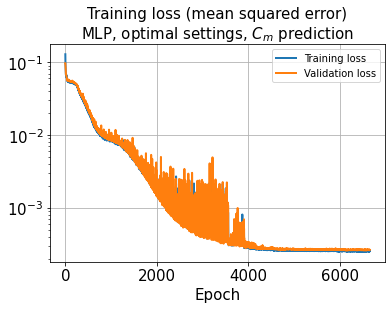

In [31]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

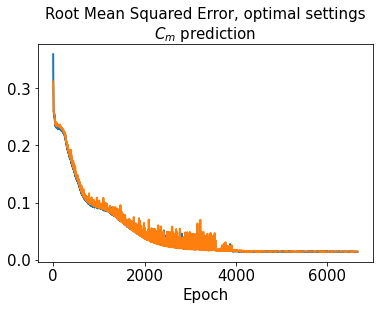

In [32]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

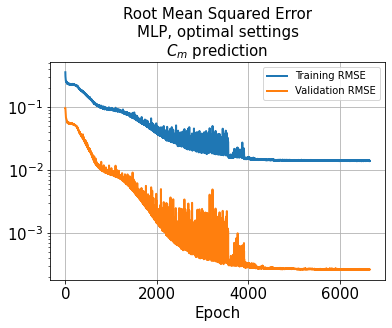

In [33]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [34]:
train_results = model.evaluate(x_train, y_train)

329/329 [==============================] - 1s 3ms/step - loss: 2.5523e-04 - rmse: 0.0141


In [35]:
val_results = model.evaluate(x_val, y_val)

94/94 [==============================] - 0s 3ms/step - loss: 2.6095e-04 - rmse: 0.0143


In [36]:
test_results = model.evaluate(x_test, y_test)

47/47 [==============================] - 0s 3ms/step - loss: 2.4725e-04 - rmse: 0.0138


In [37]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

47/47 [==============================] - 0s 1ms/step


In [38]:
decoded_train_

array([[0.29414693],
       [0.00187233],
       [0.17718849],
       ...,
       [0.12330082],
       [0.35434538],
       [0.27571103]], dtype=float32)

In [39]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [40]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [41]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [42]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [43]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [44]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [45]:
model_directory = "D:\\TrainedModels\\20221227"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221227unsteadyValidation_MLP_3Flaps_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_randomState50CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [46]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [47]:
os.chdir(storage_dir)

In [48]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [49]:
l2_error_train = l2_error(decoded_train, y_train)
mape_train = smape(decoded_train, y_train)
print(l2_error_train)
print(mape_train)

0.041834058521405974
2.5333839556188673


In [50]:
l2_error_val = l2_error(decoded_val, y_val)
mape_val= smape(decoded_val, y_val)
print(l2_error_val)
print(mape_val)

0.042092679353427025
2.559013946335276


In [51]:
l2_error_test = l2_error(decoded_test, y_test)
mape_test= smape(decoded_test, y_test)
print(l2_error_test)
print(mape_test)

0.04075500262524963
2.4916141093926267


In [52]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [53]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [54]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [55]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [56]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [57]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [58]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

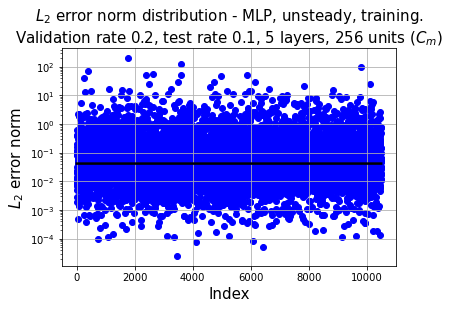

In [59]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

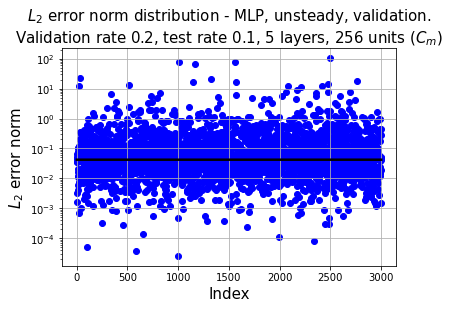

In [60]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

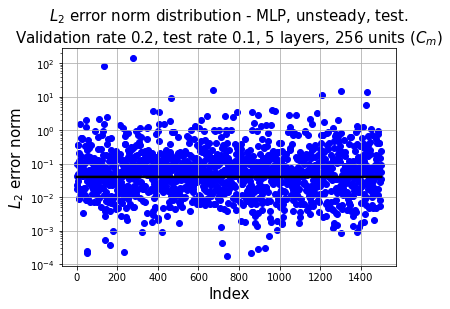

In [61]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [62]:
predicted = model.predict(x)

469/469 [==============================] - 1s 1ms/step


In [63]:
predicted.shape

(15000, 1)

In [70]:
l2_error(predicted, y)

0.03285139488563156

In [64]:
tTrain = x[index_train]+10
tVal = x[index_val]+10
tTest = x[index_test]+10

In [65]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [66]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [67]:
x += 10

In [80]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(x[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(x[:5000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0336


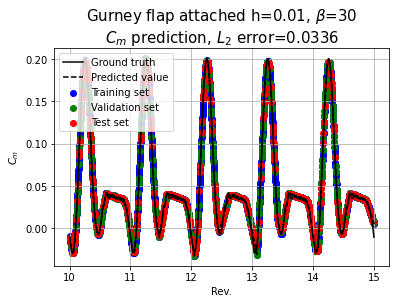

L2 error of Cm: 0.0254


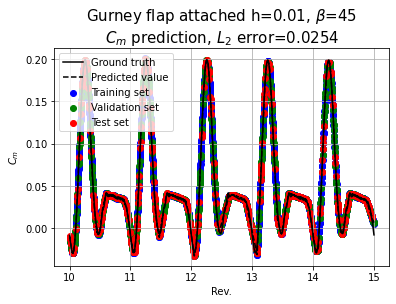

L2 error of Cm: 0.0384


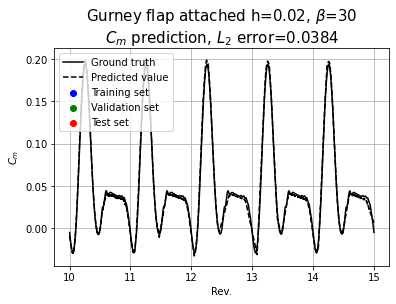

In [81]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90, 90, 60, 60, 60, 75, 75, 75]
for i in range(1, 4):
    # Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
#     # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*(i-1):t_len*(i),:]
    y_corres = y[t_len*(i-1):t_len*i,:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
    
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [74]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm), 'b--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0336


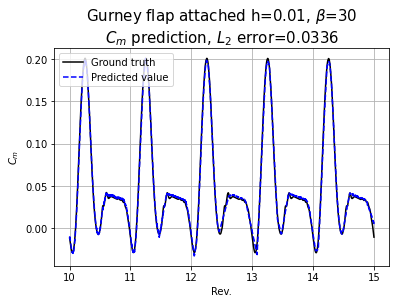

L2 error of Cm: 0.0254


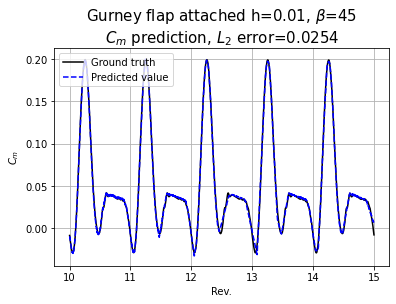

L2 error of Cm: 0.0384


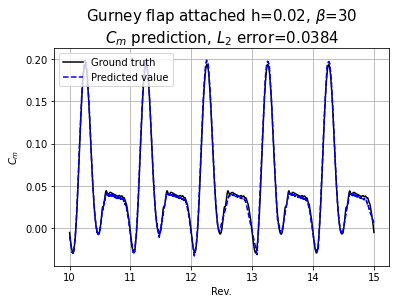

In [78]:
for i in range(1,4):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*(i-1):t_len*(i),:]
    y_corres = y[t_len*(i-1):t_len*(i),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [ ]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[1]) + r'$\beta$=%d'%(beta[1])+'\n$C_m$ prediction, training $L_2$ error=%.4f'%(l2_error_train)
title_Cm = title_n_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
# plt.scatter(tVal, iVal, color='g', label='Validation set')
# plt.scatter(tTest,iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [ ]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap attached h=%.2f, '%(h[1]) + r'$\beta$=%d'%(beta[1])+'\n$C_m$ prediction, validation $L_2$ error=%.4f'%(l2_error_val)
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#plt.scatter(tTest, iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [ ]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap attached h=%.2f, '%(h[1]) + r'$\beta$=%d'%(beta[1])+'\n$C_m$ prediction, test $L_2$ error=%.4f'%(l2_error_test)
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
#plt.scatter(tVal, iVal, color='g', label='Validation set')
plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()